In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import logging
import pathlib
import os
import tempfile
import subprocess
import time 
import json
import shutil
import glob
import concurrent.futures

import pandas as pd
import seaborn
import pydub
from tqdm.notebook import tqdm
import boto3
import webrtcvad
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.visual import plot_spectrogram
from TTS.config import load_config
from librosa import display
from matplotlib import pylab as plt
import IPython

import barbero_coqui_ai_tts.split_files
from barbero_coqui_ai_tts.wada_snr import wada_snr

tqdm.pandas()
logger = logging.getLogger(__name__)

# Constants

In [38]:
bucket = "barbero-tts2"
region = "eu-central-1"
vocabulary_file = pathlib.Path("vocabulary/vocabulary.txt")
vocabulary_name = "barbero-guerre"
data_local = pathlib.Path("../data")
frame_rate = 16000
max_chunk_duration_seconds = 10
target_normalization_db = -23
config_path = data_local / "generic_config.json"

In [3]:
boto3.setup_default_session(region_name=region)

# Convert original file to wav

In [236]:
lines = pd.read_csv("../data/original_files.csv")
lines["from"] = lines["from"].apply(pd.Timedelta)
lines["to"] = lines["to"].apply(pd.Timedelta)
lines

,original_audio,from,to
0,/ssd500gb/archivio_barbero/original/7_La_Prima...,0 days 00:01:23,0 days 01:09:48
1,/ssd500gb/archivio_barbero/original/8_Come_sco...,0 days 00:00:00,0 days 01:07:37
2,/ssd500gb/archivio_barbero/original/9_La_Guerr...,0 days 00:00:55,0 days 01:01:36


In [237]:
def convert(row):
    input_file = pathlib.Path(row["original_audio"])
    folder = input_file.parent.parent
    name = input_file.stem
    output_folder = folder / "wav"
    output_name = output_folder / f"{name}.wav"
    output_folder.mkdir(exist_ok=True, parents=True)
    sound = pydub.AudioSegment.from_mp3(input_file)
    sound = sound.set_channels(1)  # save to mono
    # cut the section between from and to
    beginning = 1000 * int(row["from"].total_seconds())
    end = 1000 * int(row["to"].total_seconds())
    sound = sound[beginning:end]
    sound = sound.set_frame_rate(frame_rate)
    sound.export(output_name, format="wav")
    logger.debug("converted %s to %s", input_file, output_name)
    return output_name

In [238]:
lines["wav"] = lines.progress_apply(convert, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Normalize

In [245]:
def normalize(row):
    input_file = pathlib.Path(row["wav"])
    folder = input_file.parent.parent
    name = input_file.stem
    output_folder = folder / "normalized_wav"
    output_name = output_folder / f"{name}.wav"
    # stupid business with using a non-ext4 filesystem
    with tempfile.TemporaryDirectory() as tmpdirname:
        temp_out_name = pathlib.Path(tmpdirname) / output_name.name
        output_folder.mkdir(exist_ok=True, parents=True)
        command = f"ffmpeg-normalize -f --normalization-type rms --target-level {target_normalization_db} {row['wav']} -o {temp_out_name}"
        subprocess.check_call(command, shell=True)
        command = f"mv {temp_out_name} {output_name}"
        subprocess.check_call(command, shell=True)
    return output_name

In [246]:
lines["normalized_wav"] = lines.progress_apply(normalize, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

# Split wav file into chunks

In [247]:
vad = webrtcvad.Vad(3)

In [248]:
def load_sound(row):
    sound = pydub.AudioSegment.from_file(row["normalized_wav"], format="wav")
    return sound

In [249]:
lines["sound"] = lines.apply(load_sound, axis=1)

In [250]:
def split_row_on_silence(row):
    frame_duration_ms = 30
    chunks = list(barbero_coqui_ai_tts.split_files.vad_collector(
        frame_rate,
        frame_duration_ms, 20 * frame_duration_ms,
        vad,
        row["sound"][::frame_duration_ms],
    ))
    durations = pd.DataFrame(
        {
            "sound": chunks,
            "duration": [chunk.duration_seconds for chunk in chunks],
        }
    )
    durations["normalized_wav"] = row["normalized_wav"]
    return durations

In [251]:
raw_chunks = pd.concat(lines.progress_apply(split_row_on_silence, axis=1).tolist())

  0%|          | 0/3 [00:00<?, ?it/s]

In [252]:
raw_chunks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 497
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sound           1693 non-null   object 
 1   duration        1693 non-null   float64
 2   normalized_wav  1693 non-null   object 
dtypes: float64(1), object(2)
memory usage: 52.9+ KB


<Axes: ylabel='duration'>

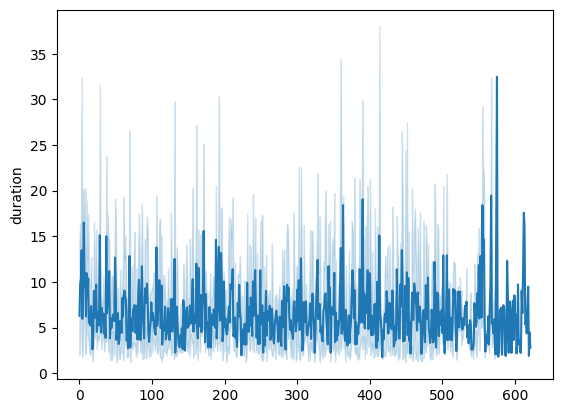

In [253]:
seaborn.lineplot(x=raw_chunks.index, y=raw_chunks.duration)

<Axes: xlabel='duration', ylabel='Count'>

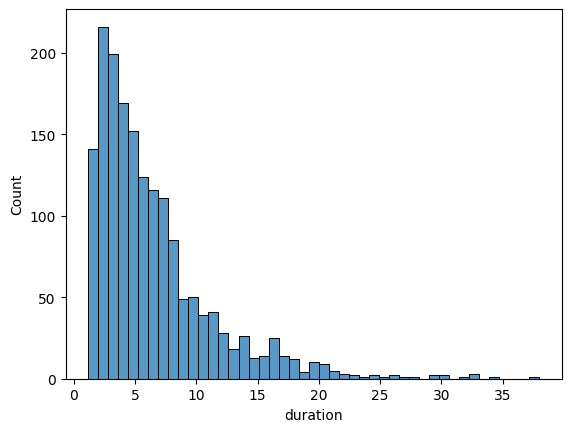

In [254]:
seaborn.histplot(raw_chunks.duration)

# Group up chunks that are too short

In [255]:
def group_chunks(df, min_duration_seconds=2, crossfade=0):
    current_duration = 0
    current_sound = pydub.AudioSegment.empty()
    current_normalized_wav = ""
    for index, row in df.iterrows():
        if not current_normalized_wav:
            # first row
            current_duration += row["duration"]
            current_sound = current_sound.append(row["sound"], crossfade=crossfade)
            current_normalized_wav = row["normalized_wav"]
        elif current_normalized_wav:
            if current_normalized_wav != row["normalized_wav"]:
                # we just changed file so we dont concatenate from different files
                yield {
                    "normalized_wav": current_normalized_wav,
                    "sound": current_sound,
                    "duration": current_duration,
                }
                current_duration = row["duration"]
                current_sound = row["sound"]
                current_normalized_wav = row["normalized_wav"]
            else:
                # we are within the same file
                if current_duration < min_duration_seconds:
                    # not enough duration, concatenate
                    current_duration += row["duration"]
                    current_sound = current_sound.append(row["sound"], crossfade=crossfade)
                else:
                    yield {
                        "normalized_wav": current_normalized_wav,
                        "sound": current_sound,
                        "duration": current_duration,
                    }
                    current_duration = row["duration"]
                    current_sound = row["sound"]
                    current_normalized_wav = row["normalized_wav"]

In [256]:
chunks = pd.DataFrame.from_records(group_chunks(raw_chunks))

In [257]:
chunks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   normalized_wav  1567 non-null   object 
 1   sound           1567 non-null   object 
 2   duration        1567 non-null   float64
dtypes: float64(1), object(2)
memory usage: 36.9+ KB


<Axes: xlabel='duration', ylabel='Count'>

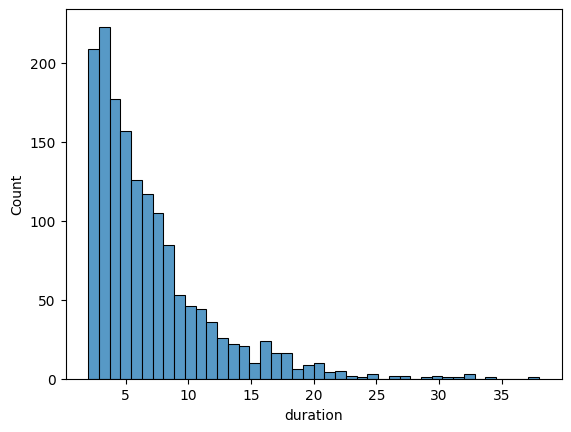

In [260]:
seaborn.histplot(chunks["duration"])

In [362]:
chunks["duration"].min()

2.01

In [290]:
def folder_from_normalized_wav(original_audio, subfolder):
    folder = pathlib.Path(original_audio).parent.parent / subfolder / original_audio.stem
    return folder

In [291]:
def save_chunk(row):
    folder = folder_from_normalized_wav(row["normalized_wav"], "splits")
    folder.mkdir(exist_ok=True, parents=True)
    output_name = folder / f"{row['index']:04}.wav"
    row["sound"].export(output_name, format="wav")
    return output_name

In [292]:
chunks["index"] = chunks.groupby("normalized_wav", as_index=False).cumcount()

In [293]:
chunks.groupby("normalized_wav", as_index=False).apply(
    lambda x: shutil.rmtree(
        folder_from_normalized_wav(x["normalized_wav"].iloc[0], "splits")
    )
)

""


In [294]:
chunks["path"] = chunks.progress_apply(save_chunk, axis=1)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [368]:
chunks["sound"].iloc[150]

In [286]:
chunks["sound"].iloc[20]

# Denoise Files

In [304]:
chunks.groupby("normalized_wav", as_index=False).apply(
    lambda x: shutil.rmtree(
        folder_from_normalized_wav(x["normalized_wav"].iloc[0], "splits_denoised"),
        ignore_errors=True,
    )
)

""


In [305]:
def denoise(group):
    original_audio = group["normalized_wav"].iloc[0]
    input_folder = folder_from_normalized_wav(original_audio, "splits")
    output_folder = folder_from_normalized_wav(original_audio, "splits_denoised")
    command = f"speech_enhance_inference -I {input_folder} -O {output_folder}"
    print(command)
    subprocess.check_call(command, shell=True)

In [306]:
chunks.groupby("normalized_wav", as_index=False).apply(denoise);

speech_enhance_inference -I /ssd500gb/archivio_barbero/splits/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014 -O /ssd500gb/archivio_barbero/splits_denoised/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014
Use default configuration: /home/user/src/FullSubNet-plus/speech_enhance/config/inference.toml
Use default model path: /home/user/.local/share/speech_enhance/best_model.tar
use specified dataset_dir_list: ('/ssd500gb/archivio_barbero/splits/7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_guerre__Barbero_Riserva_Festival_della_Mente_2014',), instead of in config
[2023-03-11 15:16:27.660]  Loading inference dataset...
[2023-03-11 15:16:27.695]  Loading model...
[2023-03-11 15:16:27.919]  The model breakpoint in tar format is currently being processed with epoch: 194.
[2023-03-11 15:16:28.778]  Configurations are as follows: 
[2023-03-11 15:16:28.778]  [acoustics]
n_fft = 512
win_length = 512
sr 

Inference:   0%|          | 0/587 [00:00<?, ?it/s]/home/user/src/FullSubNet-plus/speech_enhance/audio_zen/acoustics/feature.py:56: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:978.)
  return torch.istft(
Inference:   0%|          | 1/587 [00:00<01:43,  5.67it/s]

[2023-03-11 15:16:29.268]  model rtf: 0.0114661030185288
[2023-03-11 15:16:29.269]  0001, rtf: 0.01882513000934608
[2023-03-11 15:16:29.453]  model rtf: 0.01215617361808473
[2023-03-11 15:16:29.453]  0002, rtf: 0.018539893552192353


Inference:   1%|          | 3/587 [00:00<02:11,  4.45it/s]

[2023-03-11 15:16:29.554]  model rtf: 0.007114651227238202
[2023-03-11 15:16:29.554]  0003, rtf: 0.019221739335493607
[2023-03-11 15:16:29.665]  model rtf: 0.006733855156049336
[2023-03-11 15:16:29.665]  0004, rtf: 0.01591144631442414
[2023-03-11 15:16:29.748]  model rtf: 0.005881738342694788
[2023-03-11 15:16:29.748]  0005, rtf: 0.017231102757805948


Inference:   1%|          | 5/587 [00:00<01:28,  6.57it/s]

[2023-03-11 15:16:29.920]  model rtf: 0.009899623939680805
[2023-03-11 15:16:29.921]  0006, rtf: 0.015852503400695744
[2023-03-11 15:16:30.068]  model rtf: 0.009091505928645058
[2023-03-11 15:16:30.068]  0007, rtf: 0.01874392625516054


Inference:   1%|▏         | 8/587 [00:01<01:22,  7.05it/s]

[2023-03-11 15:16:30.128]  model rtf: 0.013678681616689644
[2023-03-11 15:16:30.128]  0008, rtf: 0.0267945083917356
[2023-03-11 15:16:30.186]  model rtf: 0.011215129482092233
[2023-03-11 15:16:30.186]  0009, rtf: 0.023285346695139438
[2023-03-11 15:16:30.313]  model rtf: 0.008275682834084966
[2023-03-11 15:16:30.314]  0010, rtf: 0.01772773453435502


Inference:   2%|▏         | 10/587 [00:01<01:00,  9.47it/s]

[2023-03-11 15:16:30.474]  model rtf: 0.009174804022629017
[2023-03-11 15:16:30.474]  0011, rtf: 0.016893696421371826
[2023-03-11 15:16:30.569]  model rtf: 0.011353706245991722
[2023-03-11 15:16:30.569]  0012, rtf: 0.022228796090652696


Inference:   2%|▏         | 12/587 [00:01<01:09,  8.29it/s]

[2023-03-11 15:16:30.751]  model rtf: 0.010077341832757339
[2023-03-11 15:16:30.752]  0013, rtf: 0.017044981664241676
[2023-03-11 15:16:30.828]  model rtf: 0.02236578945822559
[2023-03-11 15:16:30.829]  0014, rtf: 0.033290285459706484


Inference:   2%|▏         | 14/587 [00:01<01:12,  7.87it/s]

[2023-03-11 15:16:30.994]  model rtf: 0.009391925953052663
[2023-03-11 15:16:30.994]  0015, rtf: 0.016956556411016555
[2023-03-11 15:16:31.091]  model rtf: 0.007475515206654867
[2023-03-11 15:16:31.091]  0016, rtf: 0.01903042197227478


Inference:   3%|▎         | 16/587 [00:02<01:11,  7.99it/s]

[2023-03-11 15:16:31.207]  model rtf: 0.006940902972257012
[2023-03-11 15:16:31.207]  0017, rtf: 0.01659892243298358
[2023-03-11 15:16:31.278]  model rtf: 0.013003475738294197
[2023-03-11 15:16:31.278]  0018, rtf: 0.02465591286167954
[2023-03-11 15:16:31.333]  model rtf: 0.009469044061354648
[2023-03-11 15:16:31.334]  0019, rtf: 0.021046866114738053


Inference:   3%|▎         | 20/587 [00:02<00:57,  9.90it/s]

[2023-03-11 15:16:31.608]  model rtf: 0.011789892488584615
[2023-03-11 15:16:31.608]  0020, rtf: 0.016328989918565143
[2023-03-11 15:16:31.714]  model rtf: 0.005230989156817106
[2023-03-11 15:16:31.715]  0021, rtf: 0.014937583284705921


Inference:   4%|▍         | 23/587 [00:03<01:18,  7.18it/s]

[2023-03-11 15:16:31.899]  model rtf: 0.011080106099446613
[2023-03-11 15:16:31.899]  0022, rtf: 0.017758815442744772
[2023-03-11 15:16:32.061]  model rtf: 0.010095909679770329
[2023-03-11 15:16:32.062]  0023, rtf: 0.018564548922320418


Inference:   4%|▍         | 24/587 [00:03<01:21,  6.94it/s]

[2023-03-11 15:16:32.160]  model rtf: 0.009505386525541205
[2023-03-11 15:16:32.160]  0024, rtf: 0.02106939043317522
[2023-03-11 15:16:32.295]  model rtf: 0.00844057488998657
[2023-03-11 15:16:32.296]  0025, rtf: 0.01605926551208871


Inference:   4%|▍         | 26/587 [00:03<01:15,  7.46it/s]

[2023-03-11 15:16:32.507]  model rtf: 0.011241543400395022
[2023-03-11 15:16:32.507]  0026, rtf: 0.016819229875794206
[2023-03-11 15:16:32.642]  model rtf: 0.010909563229407794
[2023-03-11 15:16:32.642]  0027, rtf: 0.021451827289776407


Inference:   5%|▍         | 28/587 [00:03<01:21,  6.82it/s]

[2023-03-11 15:16:32.750]  model rtf: 0.0070668521680329974
[2023-03-11 15:16:32.750]  0028, rtf: 0.01804092474151076
[2023-03-11 15:16:32.858]  model rtf: 0.007212908336555494
[2023-03-11 15:16:32.859]  0029, rtf: 0.017446269440368548
[2023-03-11 15:16:32.939]  model rtf: 0.008750470479329427
[2023-03-11 15:16:32.939]  0030, rtf: 0.020192718505859374


Inference:   5%|▌         | 30/587 [00:04<01:12,  7.72it/s]

[2023-03-11 15:16:33.038]  model rtf: 0.005649301138791171
[2023-03-11 15:16:33.038]  0031, rtf: 0.017784490729823257
[2023-03-11 15:16:33.172]  model rtf: 0.008219222963592152
[2023-03-11 15:16:33.172]  0032, rtf: 0.019935104582044814


Inference:   6%|▌         | 33/587 [00:04<01:05,  8.50it/s]

[2023-03-11 15:16:33.352]  model rtf: 0.01014013074885654
[2023-03-11 15:16:33.352]  0033, rtf: 0.016405061588897995
[2023-03-11 15:16:33.435]  model rtf: 0.013289945411064865
[2023-03-11 15:16:33.436]  0034, rtf: 0.02519204778578675
[2023-03-11 15:16:33.505]  model rtf: 0.006743859553682631
[2023-03-11 15:16:33.505]  0035, rtf: 0.01885068589362545


Inference:   6%|▌         | 36/587 [00:04<01:00,  9.13it/s]

[2023-03-11 15:16:33.576]  model rtf: 0.007155007786220974
[2023-03-11 15:16:33.576]  0036, rtf: 0.01828544669681125
[2023-03-11 15:16:33.866]  model rtf: 0.012318333870033728
[2023-03-11 15:16:33.867]  0037, rtf: 0.016155735732884924
[2023-03-11 15:16:33.959]  model rtf: 0.011063367128372192
[2023-03-11 15:16:33.959]  0038, rtf: 0.022302878399689995
[2023-03-11 15:16:34.038]  model rtf: 0.009862389615786973
[2023-03-11 15:16:34.038]  0039, rtf: 0.019843796248077063


Inference:   7%|▋         | 40/587 [00:05<01:04,  8.44it/s]

[2023-03-11 15:16:34.132]  model rtf: 0.005018007187616257
[2023-03-11 15:16:34.132]  0040, rtf: 0.01700660160609654
[2023-03-11 15:16:34.356]  model rtf: 0.010834688269818878
[2023-03-11 15:16:34.357]  0041, rtf: 0.016148109746173145
[2023-03-11 15:16:34.508]  model rtf: 0.010675200055492594
[2023-03-11 15:16:34.508]  0042, rtf: 0.01996783399124041


Inference:   7%|▋         | 43/587 [00:05<01:13,  7.36it/s]

[2023-03-11 15:16:34.610]  model rtf: 0.004709593939095383
[2023-03-11 15:16:34.610]  0043, rtf: 0.016326791340526187
[2023-03-11 15:16:34.743]  model rtf: 0.009012846250507786
[2023-03-11 15:16:34.743]  0044, rtf: 0.017505637870347205


Inference:   8%|▊         | 45/587 [00:05<01:10,  7.72it/s]

[2023-03-11 15:16:34.847]  model rtf: 0.009338694847434577
[2023-03-11 15:16:34.847]  0045, rtf: 0.020099173781818164
[2023-03-11 15:16:34.967]  model rtf: 0.0072764356931050616
[2023-03-11 15:16:34.968]  0046, rtf: 0.016051199701097276


Inference:   8%|▊         | 47/587 [00:06<01:06,  8.16it/s]

[2023-03-11 15:16:35.160]  model rtf: 0.010136774082166514
[2023-03-11 15:16:35.160]  0047, rtf: 0.0169586420708846
[2023-03-11 15:16:35.268]  model rtf: 0.011285420121817755
[2023-03-11 15:16:35.268]  0048, rtf: 0.02348620316077923
[2023-03-11 15:16:35.336]  model rtf: 0.0076651208626750044
[2023-03-11 15:16:35.336]  0049, rtf: 0.019231119651677776


Inference:   8%|▊         | 49/587 [00:06<01:11,  7.57it/s]

[2023-03-11 15:16:35.435]  model rtf: 0.005226428282327492
[2023-03-11 15:16:35.435]  0050, rtf: 0.017482919177973514
[2023-03-11 15:16:35.498]  model rtf: 0.010925017939078227
[2023-03-11 15:16:35.498]  0051, rtf: 0.021856643733906837
[2023-03-11 15:16:35.603]  model rtf: 0.006873345335911843
[2023-03-11 15:16:35.603]  0052, rtf: 0.016694429081257536


Inference:   9%|▉         | 53/587 [00:06<00:53,  9.98it/s]

[2023-03-11 15:16:35.782]  model rtf: 0.009485884738767379
[2023-03-11 15:16:35.783]  0053, rtf: 0.015307292736396588
[2023-03-11 15:16:35.943]  model rtf: 0.01025286983681596
[2023-03-11 15:16:35.944]  0054, rtf: 0.017722774314009437


Inference:  10%|▉         | 56/587 [00:07<01:04,  8.21it/s]

[2023-03-11 15:16:36.053]  model rtf: 0.014054483058405858
[2023-03-11 15:16:36.053]  0055, rtf: 0.025424478100795372
[2023-03-11 15:16:36.190]  model rtf: 0.007425722225691921
[2023-03-11 15:16:36.190]  0056, rtf: 0.017049916338858984


Inference:  10%|▉         | 57/587 [00:07<01:06,  7.97it/s]

[2023-03-11 15:16:36.260]  model rtf: 0.0050482542618461275
[2023-03-11 15:16:36.260]  0057, rtf: 0.018672874008399853
[2023-03-11 15:16:36.476]  model rtf: 0.011448007571272865
[2023-03-11 15:16:36.476]  0058, rtf: 0.017093030380199645
[2023-03-11 15:16:36.567]  model rtf: 0.013595558577515059
[2023-03-11 15:16:36.568]  0059, rtf: 0.028848567795673203


Inference:  10%|█         | 59/587 [00:07<01:09,  7.55it/s]

[2023-03-11 15:16:36.691]  model rtf: 0.007170845705821332
[2023-03-11 15:16:36.692]  0060, rtf: 0.015826908300519787
[2023-03-11 15:16:36.800]  model rtf: 0.005779154701337998
[2023-03-11 15:16:36.801]  0061, rtf: 0.0142492538641307


Inference:  11%|█         | 62/587 [00:08<01:03,  8.30it/s]

[2023-03-11 15:16:36.930]  model rtf: 0.008474985758463541
[2023-03-11 15:16:36.931]  0062, rtf: 0.017676218181637164
[2023-03-11 15:16:37.013]  model rtf: 0.011154754323593634
[2023-03-11 15:16:37.013]  0063, rtf: 0.02286420107591117
[2023-03-11 15:16:37.124]  model rtf: 0.005662138330205851
[2023-03-11 15:16:37.125]  0064, rtf: 0.01585030947743688


Inference:  11%|█         | 65/587 [00:08<00:58,  8.88it/s]

[2023-03-11 15:16:37.263]  model rtf: 0.008511608415614061
[2023-03-11 15:16:37.264]  0065, rtf: 0.01823771846750395
[2023-03-11 15:16:37.331]  model rtf: 0.014774314252845136
[2023-03-11 15:16:37.331]  0066, rtf: 0.026834062683633912
[2023-03-11 15:16:37.417]  model rtf: 0.003834931153217464
[2023-03-11 15:16:37.418]  0067, rtf: 0.016786374441197557


Inference:  12%|█▏        | 68/587 [00:08<00:53,  9.77it/s]

[2023-03-11 15:16:37.467]  model rtf: 0.005620249201742451
[2023-03-11 15:16:37.467]  0068, rtf: 0.016649474811911136
[2023-03-11 15:16:37.579]  model rtf: 0.00638687307416515
[2023-03-11 15:16:37.580]  0069, rtf: 0.014609696874656831


Inference:  12%|█▏        | 70/587 [00:08<00:49, 10.54it/s]

[2023-03-11 15:16:37.757]  model rtf: 0.010727441798873812
[2023-03-11 15:16:37.758]  0070, rtf: 0.01678843247263055
[2023-03-11 15:16:37.869]  model rtf: 0.007157720863931373
[2023-03-11 15:16:37.869]  0071, rtf: 0.01948050410958558
[2023-03-11 15:16:37.931]  model rtf: 0.006457935414912139
[2023-03-11 15:16:37.931]  0072, rtf: 0.01777443317098355


Inference:  13%|█▎        | 74/587 [00:09<00:49, 10.40it/s]

[2023-03-11 15:16:37.998]  model rtf: 0.012076220749895235
[2023-03-11 15:16:37.999]  0073, rtf: 0.024581320897829488
[2023-03-11 15:16:38.130]  model rtf: 0.00798808418304814
[2023-03-11 15:16:38.131]  0074, rtf: 0.017339369224311528
[2023-03-11 15:16:38.266]  model rtf: 0.008929715611627982
[2023-03-11 15:16:38.266]  0075, rtf: 0.018145269707855183
[2023-03-11 15:16:38.377]  model rtf: 0.00759072057278611
[2023-03-11 15:16:38.378]  0076, rtf: 0.019201790372743114


Inference:  13%|█▎        | 76/587 [00:09<00:55,  9.25it/s]

[2023-03-11 15:16:38.517]  model rtf: 0.00886067365988707
[2023-03-11 15:16:38.517]  0077, rtf: 0.01736598137097481
[2023-03-11 15:16:38.678]  model rtf: 0.010111107922240393
[2023-03-11 15:16:38.678]  0078, rtf: 0.017574222829251217


Inference:  13%|█▎        | 79/587 [00:09<01:02,  8.18it/s]

[2023-03-11 15:16:38.888]  model rtf: 0.012328066267408767
[2023-03-11 15:16:38.889]  0079, rtf: 0.01853004232183233
[2023-03-11 15:16:38.971]  model rtf: 0.012229254216323664
[2023-03-11 15:16:38.971]  0080, rtf: 0.024172626895669066
[2023-03-11 15:16:39.047]  model rtf: 0.0083344698609071
[2023-03-11 15:16:39.047]  0081, rtf: 0.02001914767851186


Inference:  14%|█▍        | 82/587 [00:10<00:59,  8.50it/s]

[2023-03-11 15:16:39.343]  model rtf: 0.011954330778741216
[2023-03-11 15:16:39.344]  0082, rtf: 0.01581255749706582
[2023-03-11 15:16:39.505]  model rtf: 0.010021527608235676
[2023-03-11 15:16:39.505]  0083, rtf: 0.01663379648876901


Inference:  14%|█▍        | 84/587 [00:10<01:18,  6.39it/s]

[2023-03-11 15:16:39.580]  model rtf: 0.0037000292823428198
[2023-03-11 15:16:39.580]  0084, rtf: 0.016101742007024165
[2023-03-11 15:16:39.728]  model rtf: 0.009083747863769531
[2023-03-11 15:16:39.728]  0085, rtf: 0.01625450881751808


Inference:  15%|█▍        | 88/587 [00:11<01:01,  8.13it/s]

[2023-03-11 15:16:39.815]  model rtf: 0.002899765968322754
[2023-03-11 15:16:39.816]  0086, rtf: 0.015741135134841457
[2023-03-11 15:16:39.917]  model rtf: 0.00893934619712414
[2023-03-11 15:16:39.917]  0087, rtf: 0.021300959950698486
[2023-03-11 15:16:39.987]  model rtf: 0.010202349727726325
[2023-03-11 15:16:39.987]  0088, rtf: 0.02288587631717805
[2023-03-11 15:16:40.030]  model rtf: 0.0057681843086525245
[2023-03-11 15:16:40.030]  0089, rtf: 0.018617621174565068
[2023-03-11 15:16:40.090]  model rtf: 0.008952286508348253
[2023-03-11 15:16:40.090]  0090, rtf: 0.019773675335778132


Inference:  15%|█▌        | 90/587 [00:11<00:49, 10.01it/s]

[2023-03-11 15:16:40.234]  model rtf: 0.008444167648159197
[2023-03-11 15:16:40.234]  0091, rtf: 0.0159516947532541
[2023-03-11 15:16:40.383]  model rtf: 0.008918284226378663
[2023-03-11 15:16:40.384]  0092, rtf: 0.017353870885835277
[2023-03-11 15:16:40.432]  model rtf: 0.006313138193898386
[2023-03-11 15:16:40.432]  0093, rtf: 0.01956848871140253


Inference:  16%|█▌        | 94/587 [00:11<00:49,  9.99it/s]

[2023-03-11 15:16:40.584]  model rtf: 0.009344898777090625
[2023-03-11 15:16:40.585]  0094, rtf: 0.01605310481348079
[2023-03-11 15:16:40.648]  model rtf: 0.0037004796598240036
[2023-03-11 15:16:40.648]  0095, rtf: 0.0163523618839989
[2023-03-11 15:16:40.705]  model rtf: 0.0051265098268468085
[2023-03-11 15:16:40.705]  0096, rtf: 0.01636543040610964
[2023-03-11 15:16:40.782]  model rtf: 0.01608738823542519
[2023-03-11 15:16:40.782]  0097, rtf: 0.029206465161035932


Inference:  17%|█▋        | 98/587 [00:12<00:44, 10.93it/s]

[2023-03-11 15:16:40.867]  model rtf: 0.007910776257813723
[2023-03-11 15:16:40.868]  0098, rtf: 0.020592852045121346
[2023-03-11 15:16:40.937]  model rtf: 0.005096701247182059
[2023-03-11 15:16:40.937]  0099, rtf: 0.016496786430700502


Inference:  17%|█▋        | 100/587 [00:12<00:42, 11.40it/s]

[2023-03-11 15:16:41.098]  model rtf: 0.009359196894983086
[2023-03-11 15:16:41.098]  0100, rtf: 0.015753714828647233
[2023-03-11 15:16:41.206]  model rtf: 0.007707792169907514
[2023-03-11 15:16:41.206]  0101, rtf: 0.019884202994552316


Inference:  18%|█▊        | 104/587 [00:12<00:46, 10.35it/s]

[2023-03-11 15:16:41.329]  model rtf: 0.007845919116649752
[2023-03-11 15:16:41.329]  0102, rtf: 0.01898957233802945
[2023-03-11 15:16:41.378]  model rtf: 0.004843558265028821
[2023-03-11 15:16:41.378]  0103, rtf: 0.017019693324628396
[2023-03-11 15:16:41.515]  model rtf: 0.008674595583474916
[2023-03-11 15:16:41.516]  0104, rtf: 0.016599871412085777
[2023-03-11 15:16:41.652]  model rtf: 0.009195858606628617
[2023-03-11 15:16:41.652]  0105, rtf: 0.02108750605660349
[2023-03-11 15:16:41.833]  model rtf: 0.010340888293183484
[2023-03-11 15:16:41.833]  0106, rtf: 0.016480556277890388


Inference:  18%|█▊        | 107/587 [00:13<00:58,  8.21it/s]

[2023-03-11 15:16:41.989]  model rtf: 0.010404399797028186
[2023-03-11 15:16:41.989]  0107, rtf: 0.018592412565268723
[2023-03-11 15:16:42.093]  model rtf: 0.008100849666675937
[2023-03-11 15:16:42.093]  0108, rtf: 0.02110789093790175


Inference:  19%|█▊        | 109/587 [00:13<00:58,  8.13it/s]

[2023-03-11 15:16:42.218]  model rtf: 0.006743038401884191
[2023-03-11 15:16:42.218]  0109, rtf: 0.014863849854936786
[2023-03-11 15:16:42.264]  model rtf: 0.0053965168081836785
[2023-03-11 15:16:42.265]  0110, rtf: 0.018376808661919136
[2023-03-11 15:16:42.414]  model rtf: 0.009418575653571465
[2023-03-11 15:16:42.414]  0111, rtf: 0.018192141243581022


Inference:  19%|█▉        | 112/587 [00:13<00:53,  8.84it/s]

[2023-03-11 15:16:42.512]  model rtf: 0.009904502305669033
[2023-03-11 15:16:42.512]  0112, rtf: 0.023855083164671297
[2023-03-11 15:16:42.563]  model rtf: 0.004960099856058757
[2023-03-11 15:16:42.563]  0113, rtf: 0.016785413026809692
[2023-03-11 15:16:42.641]  model rtf: 0.008225941595442965
[2023-03-11 15:16:42.641]  0114, rtf: 0.01944569465056492


Inference:  20%|█▉        | 116/587 [00:13<00:42, 10.98it/s]

[2023-03-11 15:16:42.716]  model rtf: 0.00754653329381031
[2023-03-11 15:16:42.716]  0115, rtf: 0.01859972951332112
[2023-03-11 15:16:42.781]  model rtf: 0.005100405435236733
[2023-03-11 15:16:42.781]  0116, rtf: 0.01619343995422203
[2023-03-11 15:16:43.055]  model rtf: 0.011534265012600046
[2023-03-11 15:16:43.056]  0117, rtf: 0.01518494440020148
[2023-03-11 15:16:43.151]  model rtf: 0.01045980571228781
[2023-03-11 15:16:43.151]  0118, rtf: 0.021536615159776475


Inference:  20%|██        | 118/587 [00:14<00:55,  8.49it/s]

[2023-03-11 15:16:43.263]  model rtf: 0.006259404695951021
[2023-03-11 15:16:43.263]  0119, rtf: 0.014638321602392776
[2023-03-11 15:16:43.361]  model rtf: 0.008855444012266216
[2023-03-11 15:16:43.361]  0120, rtf: 0.020363526942926053
[2023-03-11 15:16:43.437]  model rtf: 0.00817072196084945
[2023-03-11 15:16:43.437]  0121, rtf: 0.019753565553758963


Inference:  21%|██        | 122/587 [00:14<00:48,  9.52it/s]

[2023-03-11 15:16:43.491]  model rtf: 0.004516627250697075
[2023-03-11 15:16:43.491]  0122, rtf: 0.016056327306060277
[2023-03-11 15:16:43.538]  model rtf: 0.009811492193312872
[2023-03-11 15:16:43.538]  0123, rtf: 0.02086843763078962
[2023-03-11 15:16:43.744]  model rtf: 0.010069988775944365
[2023-03-11 15:16:43.745]  0124, rtf: 0.014686532642530357
[2023-03-11 15:16:43.824]  model rtf: 0.017160434348910465
[2023-03-11 15:16:43.824]  0125, rtf: 0.028414726257324222
[2023-03-11 15:16:43.879]  model rtf: 0.004692912503123685
[2023-03-11 15:16:43.879]  0126, rtf: 0.017463799678918087


Inference:  22%|██▏       | 127/587 [00:15<00:42, 10.71it/s]

[2023-03-11 15:16:43.957]  model rtf: 0.011419332944429837
[2023-03-11 15:16:43.957]  0127, rtf: 0.02374618481367062
[2023-03-11 15:16:44.018]  model rtf: 0.006752221480659816
[2023-03-11 15:16:44.018]  0128, rtf: 0.016763175743213597
[2023-03-11 15:16:44.068]  model rtf: 0.004862094747609106
[2023-03-11 15:16:44.068]  0129, rtf: 0.018033122650964965
[2023-03-11 15:16:44.126]  model rtf: 0.006817147723235537
[2023-03-11 15:16:44.127]  0130, rtf: 0.019803012998300642


Inference:  22%|██▏       | 131/587 [00:15<00:35, 12.94it/s]

[2023-03-11 15:16:44.233]  model rtf: 0.007581086683023662
[2023-03-11 15:16:44.234]  0131, rtf: 0.01806871637207883
[2023-03-11 15:16:44.305]  model rtf: 0.017697141881574667
[2023-03-11 15:16:44.305]  0132, rtf: 0.0287339352724845


Inference:  23%|██▎       | 133/587 [00:15<00:36, 12.39it/s]

[2023-03-11 15:16:44.490]  model rtf: 0.009766578674316406
[2023-03-11 15:16:44.491]  0133, rtf: 0.01516189177831014
[2023-03-11 15:16:44.570]  model rtf: 0.017012089721916257
[2023-03-11 15:16:44.571]  0134, rtf: 0.02828457558801932
[2023-03-11 15:16:44.620]  model rtf: 0.005298877449192628
[2023-03-11 15:16:44.620]  0135, rtf: 0.01893396730776186
[2023-03-11 15:16:44.675]  model rtf: 0.004322072606027862
[2023-03-11 15:16:44.675]  0136, rtf: 0.016060287569775993


Inference:  23%|██▎       | 137/587 [00:15<00:37, 12.04it/s]

[2023-03-11 15:16:44.767]  model rtf: 0.012960153467514935
[2023-03-11 15:16:44.767]  0137, rtf: 0.028921731936386207
[2023-03-11 15:16:44.924]  model rtf: 0.008447261167481668
[2023-03-11 15:16:44.924]  0138, rtf: 0.01891653476166109


Inference:  24%|██▎       | 139/587 [00:16<00:42, 10.47it/s]

[2023-03-11 15:16:45.049]  model rtf: 0.00622083609770588
[2023-03-11 15:16:45.049]  0139, rtf: 0.01806596291261225
[2023-03-11 15:16:45.176]  model rtf: 0.009209441506052097
[2023-03-11 15:16:45.176]  0140, rtf: 0.02042673911225934


Inference:  24%|██▍       | 141/587 [00:16<00:46,  9.57it/s]

[2023-03-11 15:16:45.279]  model rtf: 0.006990331087925637
[2023-03-11 15:16:45.279]  0141, rtf: 0.019176801045735676
[2023-03-11 15:16:45.392]  model rtf: 0.007037152635290268
[2023-03-11 15:16:45.392]  0142, rtf: 0.018232257653635446


Inference:  24%|██▍       | 143/587 [00:16<00:46,  9.47it/s]

[2023-03-11 15:16:45.553]  model rtf: 0.00930448433548484
[2023-03-11 15:16:45.554]  0143, rtf: 0.015973030252659576
[2023-03-11 15:16:45.616]  model rtf: 0.0035940318979242793
[2023-03-11 15:16:45.616]  0144, rtf: 0.01579196222366825
[2023-03-11 15:16:45.747]  model rtf: 0.009084435940476896
[2023-03-11 15:16:45.748]  0145, rtf: 0.017988114129929317


Inference:  25%|██▍       | 146/587 [00:16<00:49,  8.96it/s]

[2023-03-11 15:16:45.887]  model rtf: 0.010205279500580897
[2023-03-11 15:16:45.887]  0146, rtf: 0.018912911248838885
[2023-03-11 15:16:45.987]  model rtf: 0.004410869196841591
[2023-03-11 15:16:45.987]  0147, rtf: 0.016767351250899464


Inference:  25%|██▌       | 147/587 [00:17<00:51,  8.53it/s]

[2023-03-11 15:16:46.090]  model rtf: 0.008136470143387958
[2023-03-11 15:16:46.090]  0148, rtf: 0.02029833754872888
[2023-03-11 15:16:46.215]  model rtf: 0.008193576505398863
[2023-03-11 15:16:46.215]  0149, rtf: 0.019119173806237195
[2023-03-11 15:16:46.283]  model rtf: 0.017568224294174123
[2023-03-11 15:16:46.284]  0150, rtf: 0.030003308098097356


Inference:  26%|██▌       | 150/587 [00:17<00:50,  8.71it/s]

[2023-03-11 15:16:46.721]  model rtf: 0.013358045624318238
[2023-03-11 15:16:46.723]  0151, rtf: 0.015926887394313517
[2023-03-11 15:16:46.787]  model rtf: 0.004617584138493271
[2023-03-11 15:16:46.787]  0152, rtf: 0.017282463456325475


Inference:  26%|██▌       | 152/587 [00:17<01:12,  6.02it/s]

[2023-03-11 15:16:46.991]  model rtf: 0.011389170726337543
[2023-03-11 15:16:46.991]  0153, rtf: 0.016555340453748176
[2023-03-11 15:16:47.096]  model rtf: 0.009470886991788375
[2023-03-11 15:16:47.096]  0154, rtf: 0.02125554783329083
[2023-03-11 15:16:47.145]  model rtf: 0.008910580685264187
[2023-03-11 15:16:47.145]  0155, rtf: 0.019728510003340874


Inference:  26%|██▋       | 155/587 [00:18<01:02,  6.90it/s]

[2023-03-11 15:16:47.249]  model rtf: 0.006854534149169922
[2023-03-11 15:16:47.249]  0156, rtf: 0.018422813205928593
[2023-03-11 15:16:47.332]  model rtf: 0.0033160411950313683
[2023-03-11 15:16:47.332]  0157, rtf: 0.01606478835597183
[2023-03-11 15:16:47.411]  model rtf: 0.0031114121278127036
[2023-03-11 15:16:47.411]  0158, rtf: 0.015726486841837566


Inference:  27%|██▋       | 159/587 [00:18<00:45,  9.37it/s]

[2023-03-11 15:16:47.502]  model rtf: 0.004086755150419905
[2023-03-11 15:16:47.502]  0159, rtf: 0.015445319012569583
[2023-03-11 15:16:47.920]  model rtf: 0.013826293140139442
[2023-03-11 15:16:47.920]  0160, rtf: 0.016455980754382864
[2023-03-11 15:16:48.036]  model rtf: 0.006175041198730469
[2023-03-11 15:16:48.036]  0161, rtf: 0.014851128685007854


Inference:  28%|██▊       | 162/587 [00:19<01:02,  6.77it/s]

[2023-03-11 15:16:48.138]  model rtf: 0.009472095049344577
[2023-03-11 15:16:48.138]  0162, rtf: 0.020874565483158473
[2023-03-11 15:16:48.207]  model rtf: 0.0037286538151618375
[2023-03-11 15:16:48.207]  0163, rtf: 0.01722158096593822
[2023-03-11 15:16:48.330]  model rtf: 0.007563315588852455
[2023-03-11 15:16:48.330]  0164, rtf: 0.017138287938874345


Inference:  28%|██▊       | 165/587 [00:19<00:51,  8.19it/s]

[2023-03-11 15:16:48.403]  model rtf: 0.0034731283955190375
[2023-03-11 15:16:48.404]  0165, rtf: 0.0160604783858376
[2023-03-11 15:16:48.460]  model rtf: 0.00998284443315253
[2023-03-11 15:16:48.460]  0166, rtf: 0.021332622053154022
[2023-03-11 15:16:48.518]  model rtf: 0.004347446745475836
[2023-03-11 15:16:48.518]  0167, rtf: 0.016043179154747705


Inference:  29%|██▉       | 169/587 [00:19<00:40, 10.27it/s]

[2023-03-11 15:16:48.635]  model rtf: 0.00670606171183722
[2023-03-11 15:16:48.636]  0168, rtf: 0.014162122686260843
[2023-03-11 15:16:48.709]  model rtf: 0.009056684133168813
[2023-03-11 15:16:48.710]  0169, rtf: 0.020927996248812288
[2023-03-11 15:16:48.760]  model rtf: 0.009818055314016125
[2023-03-11 15:16:48.760]  0170, rtf: 0.021525387350282713


Inference:  29%|██▉       | 173/587 [00:20<00:35, 11.67it/s]

[2023-03-11 15:16:48.849]  model rtf: 0.006325611335312773
[2023-03-11 15:16:48.849]  0171, rtf: 0.01716984960133444
[2023-03-11 15:16:48.930]  model rtf: 0.006144539291310199
[2023-03-11 15:16:48.930]  0172, rtf: 0.018166656225499973
[2023-03-11 15:16:48.982]  model rtf: 0.00979971681904589
[2023-03-11 15:16:48.982]  0173, rtf: 0.02075352220453768
[2023-03-11 15:16:49.085]  model rtf: 0.006003060444864529
[2023-03-11 15:16:49.085]  0174, rtf: 0.015477710795179705
[2023-03-11 15:16:49.151]  model rtf: 0.010350210624828673
[2023-03-11 15:16:49.151]  0175, rtf: 0.021829856069464432
[2023-03-11 15:16:49.211]  model rtf: 0.004181293172573824
[2023-03-11 15:16:49.212]  0176, rtf: 0.017537983185654388


Inference:  30%|███       | 177/587 [00:20<00:31, 12.99it/s]

[2023-03-11 15:16:49.394]  model rtf: 0.009625501583277253
[2023-03-11 15:16:49.395]  0177, rtf: 0.015460538946491038
[2023-03-11 15:16:49.468]  model rtf: 0.009468816361337338
[2023-03-11 15:16:49.468]  0178, rtf: 0.02172802979091428
[2023-03-11 15:16:49.526]  model rtf: 0.011516683469942914
[2023-03-11 15:16:49.527]  0179, rtf: 0.0225745565522977


Inference:  31%|███       | 181/587 [00:20<00:38, 10.57it/s]

[2023-03-11 15:16:49.665]  model rtf: 0.007372155998869664
[2023-03-11 15:16:49.666]  0180, rtf: 0.013835127855858676
[2023-03-11 15:16:49.792]  model rtf: 0.007518906420685081
[2023-03-11 15:16:49.793]  0181, rtf: 0.015321325571200672
[2023-03-11 15:16:49.932]  model rtf: 0.009547782779203779
[2023-03-11 15:16:49.932]  0182, rtf: 0.017542164922533642
[2023-03-11 15:16:50.054]  model rtf: 0.00889202434290349
[2023-03-11 15:16:50.054]  0183, rtf: 0.018846209159498202


Inference:  31%|███       | 183/587 [00:21<00:42,  9.41it/s]

[2023-03-11 15:16:50.340]  model rtf: 0.011903932779142172
[2023-03-11 15:16:50.340]  0184, rtf: 0.015467438105047077
[2023-03-11 15:16:50.491]  model rtf: 0.010284818248984254
[2023-03-11 15:16:50.491]  0185, rtf: 0.017956774911762757


Inference:  32%|███▏      | 186/587 [00:21<00:55,  7.23it/s]

[2023-03-11 15:16:50.581]  model rtf: 0.011055342623499595
[2023-03-11 15:16:50.581]  0186, rtf: 0.024071928499793473
[2023-03-11 15:16:50.743]  model rtf: 0.008614084742090723
[2023-03-11 15:16:50.743]  0187, rtf: 0.014296394210677963


Inference:  32%|███▏      | 189/587 [00:22<00:51,  7.78it/s]

[2023-03-11 15:16:50.848]  model rtf: 0.0053152464659065235
[2023-03-11 15:16:50.848]  0188, rtf: 0.015268804820160888
[2023-03-11 15:16:50.985]  model rtf: 0.007846126888831977
[2023-03-11 15:16:50.985]  0189, rtf: 0.014474656846788194


Inference:  33%|███▎      | 191/587 [00:22<00:50,  7.87it/s]

[2023-03-11 15:16:51.101]  model rtf: 0.008407442106140984
[2023-03-11 15:16:51.101]  0190, rtf: 0.01939878695540958
[2023-03-11 15:16:51.165]  model rtf: 0.003953006755070192
[2023-03-11 15:16:51.165]  0191, rtf: 0.01681719173570307
[2023-03-11 15:16:51.277]  model rtf: 0.0053435349017166645
[2023-03-11 15:16:51.277]  0192, rtf: 0.015661520359320044


Inference:  33%|███▎      | 195/587 [00:22<00:36, 10.79it/s]

[2023-03-11 15:16:51.345]  model rtf: 0.013880332310994467
[2023-03-11 15:16:51.345]  0193, rtf: 0.026600460211435955
[2023-03-11 15:16:51.398]  model rtf: 0.00458979139141008
[2023-03-11 15:16:51.399]  0194, rtf: 0.016485787684621375
[2023-03-11 15:16:51.476]  model rtf: 0.002994889508702322
[2023-03-11 15:16:51.476]  0195, rtf: 0.014751542828040209
[2023-03-11 15:16:51.557]  model rtf: 0.002981147380790325
[2023-03-11 15:16:51.557]  0196, rtf: 0.01566289651273477


Inference:  34%|███▎      | 197/587 [00:22<00:34, 11.35it/s]

[2023-03-11 15:16:51.802]  model rtf: 0.011064809806337964
[2023-03-11 15:16:51.803]  0197, rtf: 0.015076567022392663
[2023-03-11 15:16:51.920]  model rtf: 0.009455895638680673
[2023-03-11 15:16:51.920]  0198, rtf: 0.020350378912848396


Inference:  34%|███▍      | 200/587 [00:23<00:48,  8.03it/s]

[2023-03-11 15:16:52.068]  model rtf: 0.0089496889741363
[2023-03-11 15:16:52.069]  0199, rtf: 0.016622559834516586
[2023-03-11 15:16:52.157]  model rtf: 0.0037684545412168396
[2023-03-11 15:16:52.157]  0200, rtf: 0.015496683644724417
[2023-03-11 15:16:52.203]  model rtf: 0.006037514384199933
[2023-03-11 15:16:52.204]  0201, rtf: 0.017487130514005335
[2023-03-11 15:16:52.257]  model rtf: 0.007050945645286923
[2023-03-11 15:16:52.258]  0202, rtf: 0.020017983421446783


Inference:  35%|███▍      | 204/587 [00:23<00:34, 11.21it/s]

[2023-03-11 15:16:52.321]  model rtf: 0.004534484926334097
[2023-03-11 15:16:52.321]  0203, rtf: 0.01661225783923441
[2023-03-11 15:16:52.450]  model rtf: 0.00948003334517213
[2023-03-11 15:16:52.451]  0204, rtf: 0.018891633725633808
[2023-03-11 15:16:52.493]  model rtf: 0.00589579752046768
[2023-03-11 15:16:52.493]  0205, rtf: 0.017464433086517194


Inference:  35%|███▌      | 208/587 [00:23<00:32, 11.56it/s]

[2023-03-11 15:16:52.599]  model rtf: 0.0075705102545011345
[2023-03-11 15:16:52.599]  0206, rtf: 0.020080514353850665
[2023-03-11 15:16:52.659]  model rtf: 0.004240810007288836
[2023-03-11 15:16:52.659]  0207, rtf: 0.01621813013933707
[2023-03-11 15:16:52.803]  model rtf: 0.007640773026400774
[2023-03-11 15:16:52.803]  0208, rtf: 0.014824413117908298
[2023-03-11 15:16:53.016]  model rtf: 0.011332235603689034
[2023-03-11 15:16:53.017]  0209, rtf: 0.016239591848070375
[2023-03-11 15:16:53.065]  model rtf: 0.005042368127394092
[2023-03-11 15:16:53.065]  0210, rtf: 0.01723581506300342
[2023-03-11 15:16:53.147]  model rtf: 0.002864565168108259
[2023-03-11 15:16:53.147]  0211, rtf: 0.014876138596307664


Inference:  36%|███▌      | 212/587 [00:24<00:37, 10.03it/s]

[2023-03-11 15:16:53.229]  model rtf: 0.0030978705531866974
[2023-03-11 15:16:53.230]  0212, rtf: 0.015300558518993762
[2023-03-11 15:16:53.288]  model rtf: 0.005627394438505889
[2023-03-11 15:16:53.288]  0213, rtf: 0.016511309970248567
[2023-03-11 15:16:53.373]  model rtf: 0.01221134744841477
[2023-03-11 15:16:53.373]  0214, rtf: 0.023528967780628424


Inference:  36%|███▋      | 214/587 [00:24<00:33, 11.01it/s]

[2023-03-11 15:16:53.496]  model rtf: 0.007307824436060032
[2023-03-11 15:16:53.497]  0215, rtf: 0.017418229770799216
[2023-03-11 15:16:53.542]  model rtf: 0.007325300463923701
[2023-03-11 15:16:53.543]  0216, rtf: 0.019695913350140606


Inference:  37%|███▋      | 216/587 [00:24<00:35, 10.53it/s]

[2023-03-11 15:16:53.707]  model rtf: 0.009368997841065633
[2023-03-11 15:16:53.707]  0217, rtf: 0.015498681920738036
[2023-03-11 15:16:53.802]  model rtf: 0.007941799779092111
[2023-03-11 15:16:53.802]  0218, rtf: 0.019428294192078293
[2023-03-11 15:16:53.889]  model rtf: 0.0068374045260317685
[2023-03-11 15:16:53.889]  0219, rtf: 0.018824918850048167


Inference:  37%|███▋      | 220/587 [00:25<00:35, 10.43it/s]

[2023-03-11 15:16:53.944]  model rtf: 0.0066403270691864245
[2023-03-11 15:16:53.944]  0220, rtf: 0.019910538843435834
[2023-03-11 15:16:53.994]  model rtf: 0.006260426063847736
[2023-03-11 15:16:53.994]  0221, rtf: 0.019145884164949743


Inference:  38%|███▊      | 222/587 [00:25<00:30, 12.07it/s]

[2023-03-11 15:16:54.210]  model rtf: 0.010489901422938227
[2023-03-11 15:16:54.210]  0222, rtf: 0.015276076989772517
[2023-03-11 15:16:54.334]  model rtf: 0.009494280853517197
[2023-03-11 15:16:54.334]  0223, rtf: 0.019234505252561707
[2023-03-11 15:16:54.397]  model rtf: 0.006303499484884328
[2023-03-11 15:16:54.397]  0224, rtf: 0.016972525366421402


Inference:  38%|███▊      | 224/587 [00:25<00:39,  9.16it/s]

[2023-03-11 15:16:54.709]  model rtf: 0.012383220392629641
[2023-03-11 15:16:54.710]  0225, rtf: 0.015697919143692313
[2023-03-11 15:16:54.755]  model rtf: 0.005563925871085295
[2023-03-11 15:16:54.756]  0226, rtf: 0.017402388832785866
[2023-03-11 15:16:54.893]  model rtf: 0.009705174353814894
[2023-03-11 15:16:54.894]  0227, rtf: 0.018076646712518508


Inference:  39%|███▉      | 228/587 [00:26<00:43,  8.30it/s]

[2023-03-11 15:16:55.072]  model rtf: 0.010140453843765608
[2023-03-11 15:16:55.073]  0228, rtf: 0.015908789961305386
[2023-03-11 15:16:55.125]  model rtf: 0.005922379431786475
[2023-03-11 15:16:55.125]  0229, rtf: 0.020847692118062602
[2023-03-11 15:16:55.208]  model rtf: 0.014621285638448708
[2023-03-11 15:16:55.208]  0230, rtf: 0.02742428140541942
[2023-03-11 15:16:55.261]  model rtf: 0.006387652462101325
[2023-03-11 15:16:55.261]  0231, rtf: 0.017755262313350555


Inference:  39%|███▉      | 231/587 [00:26<00:38,  9.13it/s]

[2023-03-11 15:16:55.326]  model rtf: 0.004966052498404435
[2023-03-11 15:16:55.327]  0232, rtf: 0.01633329967188397
[2023-03-11 15:16:55.481]  model rtf: 0.00914559309851467
[2023-03-11 15:16:55.481]  0233, rtf: 0.015630504176376517


Inference:  40%|███▉      | 233/587 [00:26<00:33, 10.72it/s]

[2023-03-11 15:16:55.557]  model rtf: 0.012470563252766928
[2023-03-11 15:16:55.557]  0234, rtf: 0.02379306157430013
[2023-03-11 15:16:55.721]  model rtf: 0.009162370028070441
[2023-03-11 15:16:55.721]  0235, rtf: 0.015066397581861611


Inference:  40%|████      | 235/587 [00:26<00:35,  9.99it/s]

[2023-03-11 15:16:55.884]  model rtf: 0.010100652774175009
[2023-03-11 15:16:55.884]  0236, rtf: 0.016537184516588848
[2023-03-11 15:16:55.966]  model rtf: 0.014879065992194655
[2023-03-11 15:16:55.966]  0237, rtf: 0.028307359297196945
[2023-03-11 15:16:56.026]  model rtf: 0.004102455245123969
[2023-03-11 15:16:56.027]  0238, rtf: 0.0160245762930976


Inference:  41%|████      | 239/587 [00:27<00:36,  9.53it/s]

[2023-03-11 15:16:56.097]  model rtf: 0.013624930727309076
[2023-03-11 15:16:56.097]  0239, rtf: 0.024321545725283417
[2023-03-11 15:16:56.164]  model rtf: 0.008136601675124396
[2023-03-11 15:16:56.164]  0240, rtf: 0.018928945064544678
[2023-03-11 15:16:56.210]  model rtf: 0.005382425171413502
[2023-03-11 15:16:56.210]  0241, rtf: 0.01790855504289458
[2023-03-11 15:16:56.292]  model rtf: 0.00890606925601051
[2023-03-11 15:16:56.292]  0242, rtf: 0.020715357765318857


Inference:  41%|████▏     | 243/587 [00:27<00:29, 11.80it/s]

[2023-03-11 15:16:56.470]  model rtf: 0.009889775519872744
[2023-03-11 15:16:56.470]  0243, rtf: 0.015414108964429293
[2023-03-11 15:16:56.636]  model rtf: 0.009990342055694965
[2023-03-11 15:16:56.636]  0244, rtf: 0.017032140417944028


Inference:  42%|████▏     | 247/587 [00:28<00:34,  9.81it/s]

[2023-03-11 15:16:56.690]  model rtf: 0.005278362569584188
[2023-03-11 15:16:56.690]  0245, rtf: 0.016646031980161312
[2023-03-11 15:16:56.796]  model rtf: 0.00575642940426661
[2023-03-11 15:16:56.797]  0246, rtf: 0.014188992418861915
[2023-03-11 15:16:56.879]  model rtf: 0.003101474554963814
[2023-03-11 15:16:56.880]  0247, rtf: 0.015218544375988864
[2023-03-11 15:16:56.968]  model rtf: 0.008931473223832401
[2023-03-11 15:16:56.968]  0248, rtf: 0.020482940395383068
[2023-03-11 15:16:57.019]  model rtf: 0.0048189537197935815
[2023-03-11 15:16:57.019]  0249, rtf: 0.01862619437423407
[2023-03-11 15:16:57.096]  model rtf: 0.003016827825062765
[2023-03-11 15:16:57.096]  0250, rtf: 0.014813550694022112


Inference:  43%|████▎     | 251/587 [00:28<00:29, 11.48it/s]

[2023-03-11 15:16:57.201]  model rtf: 0.005769118284567809
[2023-03-11 15:16:57.201]  0251, rtf: 0.01523127922644982
[2023-03-11 15:16:57.280]  model rtf: 0.0029172801008128155
[2023-03-11 15:16:57.281]  0252, rtf: 0.015241064206518308
[2023-03-11 15:16:57.344]  model rtf: 0.0037702049796036847
[2023-03-11 15:16:57.344]  0253, rtf: 0.01573462498782501
[2023-03-11 15:16:57.398]  model rtf: 0.004412364033819402
[2023-03-11 15:16:57.398]  0254, rtf: 0.016334141728175884


Inference:  43%|████▎     | 255/587 [00:28<00:26, 12.57it/s]

[2023-03-11 15:16:57.538]  model rtf: 0.009441765599280783
[2023-03-11 15:16:57.538]  0255, rtf: 0.017189409747813484
[2023-03-11 15:16:57.630]  model rtf: 0.0038731665838332404
[2023-03-11 15:16:57.630]  0256, rtf: 0.016133951180147165
[2023-03-11 15:16:57.736]  model rtf: 0.0054810811015008724
[2023-03-11 15:16:57.737]  0257, rtf: 0.0165816263859326


Inference:  44%|████▍     | 257/587 [00:28<00:29, 11.04it/s]

[2023-03-11 15:16:57.838]  model rtf: 0.0077594984446140314
[2023-03-11 15:16:57.838]  0258, rtf: 0.021671090957607917
[2023-03-11 15:16:57.883]  model rtf: 0.006681283315022786
[2023-03-11 15:16:57.883]  0259, rtf: 0.019854136875697544
[2023-03-11 15:16:58.029]  model rtf: 0.008836143834579395
[2023-03-11 15:16:58.030]  0260, rtf: 0.017225483189458435


Inference:  44%|████▍     | 261/587 [00:29<00:30, 10.53it/s]

[2023-03-11 15:16:58.152]  model rtf: 0.008328023709748921
[2023-03-11 15:16:58.152]  0261, rtf: 0.01729587365312186
[2023-03-11 15:16:58.210]  model rtf: 0.005954466525863551
[2023-03-11 15:16:58.210]  0262, rtf: 0.017047603175325214
[2023-03-11 15:16:58.286]  model rtf: 0.01370663545569595
[2023-03-11 15:16:58.286]  0263, rtf: 0.024569683334454386


Inference:  45%|████▌     | 265/587 [00:29<00:29, 10.93it/s]

[2023-03-11 15:16:58.383]  model rtf: 0.007064855075211684
[2023-03-11 15:16:58.383]  0264, rtf: 0.018562696859446268
[2023-03-11 15:16:58.497]  model rtf: 0.005972488173123063
[2023-03-11 15:16:58.497]  0265, rtf: 0.015785399524644875
[2023-03-11 15:16:58.638]  model rtf: 0.00786275803288327
[2023-03-11 15:16:58.639]  0266, rtf: 0.014446581466288506
[2023-03-11 15:16:58.680]  model rtf: 0.006296899583604601
[2023-03-11 15:16:58.680]  0267, rtf: 0.0182295767005515
[2023-03-11 15:16:58.735]  model rtf: 0.008287330468495687
[2023-03-11 15:16:58.736]  0268, rtf: 0.021722217400868736


Inference:  45%|████▌     | 267/587 [00:29<00:32,  9.77it/s]

[2023-03-11 15:16:58.993]  model rtf: 0.01311375049300963
[2023-03-11 15:16:58.994]  0269, rtf: 0.018018666276206508
[2023-03-11 15:16:59.116]  model rtf: 0.009010522581478993
[2023-03-11 15:16:59.117]  0270, rtf: 0.022798512482689062


Inference:  46%|████▌     | 271/587 [00:30<00:35,  9.03it/s]

[2023-03-11 15:16:59.357]  model rtf: 0.01092544038787143
[2023-03-11 15:16:59.358]  0271, rtf: 0.015056679267009706
[2023-03-11 15:16:59.422]  model rtf: 0.00347949429691916
[2023-03-11 15:16:59.422]  0272, rtf: 0.015420383877224391
[2023-03-11 15:16:59.494]  model rtf: 0.003439563888687271
[2023-03-11 15:16:59.495]  0273, rtf: 0.01554279714017301


Inference:  47%|████▋     | 274/587 [00:30<00:35,  8.94it/s]

[2023-03-11 15:16:59.591]  model rtf: 0.01643624222069456
[2023-03-11 15:16:59.592]  0274, rtf: 0.027271948362651625
[2023-03-11 15:16:59.715]  model rtf: 0.007933045731109827
[2023-03-11 15:16:59.715]  0275, rtf: 0.016287297618632415


Inference:  47%|████▋     | 277/587 [00:31<00:33,  9.13it/s]

[2023-03-11 15:16:59.817]  model rtf: 0.005732269750701057
[2023-03-11 15:16:59.817]  0276, rtf: 0.01701518065399594
[2023-03-11 15:16:59.871]  model rtf: 0.006921482488575867
[2023-03-11 15:16:59.871]  0277, rtf: 0.020971781090845035
[2023-03-11 15:16:59.917]  model rtf: 0.007393289718949845
[2023-03-11 15:16:59.917]  0278, rtf: 0.01799899314526264
[2023-03-11 15:16:59.971]  model rtf: 0.005746729233685662
[2023-03-11 15:16:59.971]  0279, rtf: 0.019728529687021296


Inference:  48%|████▊     | 280/587 [00:31<00:25, 12.01it/s]

[2023-03-11 15:17:00.108]  model rtf: 0.009255482319214336
[2023-03-11 15:17:00.108]  0280, rtf: 0.02518504058720965
[2023-03-11 15:17:00.221]  model rtf: 0.007566079689433343
[2023-03-11 15:17:00.222]  0281, rtf: 0.02021389991099883


Inference:  48%|████▊     | 284/587 [00:31<00:28, 10.72it/s]

[2023-03-11 15:17:00.337]  model rtf: 0.006470249758826362
[2023-03-11 15:17:00.337]  0282, rtf: 0.015475418832567003
[2023-03-11 15:17:00.396]  model rtf: 0.005223614599568273
[2023-03-11 15:17:00.396]  0283, rtf: 0.018438425931063564
[2023-03-11 15:17:00.507]  model rtf: 0.00598181241725778
[2023-03-11 15:17:00.507]  0284, rtf: 0.014970758137510079
[2023-03-11 15:17:00.667]  model rtf: 0.010425309818088667
[2023-03-11 15:17:00.667]  0285, rtf: 0.017860528393163166
[2023-03-11 15:17:00.746]  model rtf: 0.0032276302189021915
[2023-03-11 15:17:00.747]  0286, rtf: 0.016294052074481914


Inference:  49%|████▊     | 286/587 [00:31<00:31,  9.43it/s]

[2023-03-11 15:17:00.894]  model rtf: 0.009584117974774436
[2023-03-11 15:17:00.894]  0287, rtf: 0.01695467810748744
[2023-03-11 15:17:01.034]  model rtf: 0.00968771018529598
[2023-03-11 15:17:01.034]  0288, rtf: 0.017828683765195263


Inference:  49%|████▉     | 289/587 [00:32<00:33,  8.79it/s]

[2023-03-11 15:17:01.173]  model rtf: 0.007653711227001135
[2023-03-11 15:17:01.173]  0289, rtf: 0.01411480473772285
[2023-03-11 15:17:01.226]  model rtf: 0.0075566534902535235
[2023-03-11 15:17:01.226]  0290, rtf: 0.01937725964714499
[2023-03-11 15:17:01.279]  model rtf: 0.004898768798433075
[2023-03-11 15:17:01.279]  0291, rtf: 0.015948814095802677
[2023-03-11 15:17:01.364]  model rtf: 0.012220231826696019
[2023-03-11 15:17:01.365]  0292, rtf: 0.0231971848482466


Inference:  50%|████▉     | 292/587 [00:32<00:27, 10.55it/s]

[2023-03-11 15:17:01.421]  model rtf: 0.005569248079503857
[2023-03-11 15:17:01.421]  0293, rtf: 0.01670579490421703
[2023-03-11 15:17:01.541]  model rtf: 0.006847793673291619
[2023-03-11 15:17:01.541]  0294, rtf: 0.014409871748936029


Inference:  50%|█████     | 294/587 [00:32<00:25, 11.55it/s]

[2023-03-11 15:17:01.645]  model rtf: 0.005488122390585967
[2023-03-11 15:17:01.646]  0295, rtf: 0.015085315272818863
[2023-03-11 15:17:01.761]  model rtf: 0.006359725659112708
[2023-03-11 15:17:01.761]  0296, rtf: 0.01527641699310847


Inference:  50%|█████     | 296/587 [00:32<00:27, 10.51it/s]

[2023-03-11 15:17:01.848]  model rtf: 0.004607309721395579
[2023-03-11 15:17:01.848]  0297, rtf: 0.016314837589301537
[2023-03-11 15:17:01.908]  model rtf: 0.00607275668485665
[2023-03-11 15:17:01.908]  0298, rtf: 0.01753921862001772
[2023-03-11 15:17:02.033]  model rtf: 0.009454295166537294
[2023-03-11 15:17:02.033]  0299, rtf: 0.020736262329623233


Inference:  51%|█████     | 300/587 [00:33<00:27, 10.45it/s]

[2023-03-11 15:17:02.159]  model rtf: 0.006931303749888064
[2023-03-11 15:17:02.159]  0300, rtf: 0.01514280004867686
[2023-03-11 15:17:02.463]  model rtf: 0.012950060660378973
[2023-03-11 15:17:02.464]  0301, rtf: 0.01746031275966711
[2023-03-11 15:17:02.515]  model rtf: 0.007532344144933365
[2023-03-11 15:17:02.515]  0302, rtf: 0.01840348337210861


Inference:  51%|█████▏    | 302/587 [00:33<00:37,  7.53it/s]

[2023-03-11 15:17:02.761]  model rtf: 0.011362001192091641
[2023-03-11 15:17:02.761]  0303, rtf: 0.015688961387699485


Inference:  52%|█████▏    | 304/587 [00:33<00:38,  7.27it/s]

[2023-03-11 15:17:03.012]  model rtf: 0.011604684938319737
[2023-03-11 15:17:03.012]  0304, rtf: 0.015711967409686712
[2023-03-11 15:17:03.102]  model rtf: 0.004171632293962006
[2023-03-11 15:17:03.103]  0305, rtf: 0.014669752528524807
[2023-03-11 15:17:03.190]  model rtf: 0.002854069073994954
[2023-03-11 15:17:03.190]  0306, rtf: 0.01581473784013228


Inference:  52%|█████▏    | 307/587 [00:34<00:37,  7.44it/s]

[2023-03-11 15:17:03.282]  model rtf: 0.013317194851962004
[2023-03-11 15:17:03.282]  0307, rtf: 0.026675932335131096
[2023-03-11 15:17:03.351]  model rtf: 0.008455689451033453
[2023-03-11 15:17:03.351]  0308, rtf: 0.020519966648375135


Inference:  53%|█████▎    | 310/587 [00:34<00:36,  7.62it/s]

[2023-03-11 15:17:03.543]  model rtf: 0.01012551651720114
[2023-03-11 15:17:03.544]  0309, rtf: 0.0161809602556008
[2023-03-11 15:17:03.769]  model rtf: 0.011379289485159375
[2023-03-11 15:17:03.770]  0310, rtf: 0.016436264628455752
[2023-03-11 15:17:03.943]  model rtf: 0.008503397305806478
[2023-03-11 15:17:03.943]  0311, rtf: 0.014023880163828531


Inference:  53%|█████▎    | 312/587 [00:35<00:43,  6.39it/s]

[2023-03-11 15:17:04.007]  model rtf: 0.00377533927796379
[2023-03-11 15:17:04.007]  0312, rtf: 0.015775362650553387
[2023-03-11 15:17:04.168]  model rtf: 0.00844548408737048
[2023-03-11 15:17:04.169]  0313, rtf: 0.013940170328453105


Inference:  53%|█████▎    | 314/587 [00:35<00:37,  7.19it/s]

[2023-03-11 15:17:04.465]  model rtf: 0.012751100780246974
[2023-03-11 15:17:04.467]  0314, rtf: 0.0170080533950201
[2023-03-11 15:17:04.516]  model rtf: 0.005025457042132237
[2023-03-11 15:17:04.516]  0315, rtf: 0.017374338105667467
[2023-03-11 15:17:04.618]  model rtf: 0.008793561546890823
[2023-03-11 15:17:04.618]  0316, rtf: 0.022774162115874113


Inference:  54%|█████▍    | 317/587 [00:35<00:36,  7.36it/s]

[2023-03-11 15:17:04.671]  model rtf: 0.00838075645666554
[2023-03-11 15:17:04.671]  0317, rtf: 0.02041039643464265
[2023-03-11 15:17:04.752]  model rtf: 0.004451357441031056
[2023-03-11 15:17:04.752]  0318, rtf: 0.01671267794324206
[2023-03-11 15:17:04.818]  model rtf: 0.005415702859560649
[2023-03-11 15:17:04.818]  0319, rtf: 0.016267597675323486


Inference:  54%|█████▍    | 319/587 [00:35<00:29,  8.98it/s]

[2023-03-11 15:17:04.971]  model rtf: 0.009226617012315124
[2023-03-11 15:17:04.971]  0320, rtf: 0.018945874755315804


Inference:  55%|█████▍    | 321/587 [00:36<00:29,  9.03it/s]

[2023-03-11 15:17:05.328]  model rtf: 0.013006617734720418
[2023-03-11 15:17:05.329]  0321, rtf: 0.016112991305061313
[2023-03-11 15:17:05.393]  model rtf: 0.004041920537533967
[2023-03-11 15:17:05.393]  0322, rtf: 0.016301472981770832
[2023-03-11 15:17:05.459]  model rtf: 0.004203676812874797
[2023-03-11 15:17:05.459]  0323, rtf: 0.01915952116706685
[2023-03-11 15:17:05.510]  model rtf: 0.00458173325790982
[2023-03-11 15:17:05.510]  0324, rtf: 0.016459238897893847


Inference:  55%|█████▌    | 324/587 [00:36<00:32,  8.00it/s]

[2023-03-11 15:17:05.775]  model rtf: 0.012024784205006618
[2023-03-11 15:17:05.775]  0325, rtf: 0.015962708230112112
[2023-03-11 15:17:05.923]  model rtf: 0.008913198502495867
[2023-03-11 15:17:05.923]  0326, rtf: 0.018138244880318493
[2023-03-11 15:17:05.971]  model rtf: 0.006682191576276506
[2023-03-11 15:17:05.971]  0327, rtf: 0.021130130404517763


Inference:  56%|█████▌    | 327/587 [00:37<00:36,  7.22it/s]

[2023-03-11 15:17:06.018]  model rtf: 0.005280120032174247
[2023-03-11 15:17:06.018]  0328, rtf: 0.016950236426459417
[2023-03-11 15:17:06.121]  model rtf: 0.005563850566552944
[2023-03-11 15:17:06.121]  0329, rtf: 0.014256271340475232
[2023-03-11 15:17:06.174]  model rtf: 0.004724143207937048
[2023-03-11 15:17:06.174]  0330, rtf: 0.017007364742997765


Inference:  57%|█████▋    | 332/587 [00:37<00:23, 10.95it/s]

[2023-03-11 15:17:06.236]  model rtf: 0.0036723134475203263
[2023-03-11 15:17:06.236]  0331, rtf: 0.014925488382198732
[2023-03-11 15:17:06.303]  model rtf: 0.003684768381044846
[2023-03-11 15:17:06.303]  0332, rtf: 0.015584935821612059
[2023-03-11 15:17:06.457]  model rtf: 0.00895964978921293
[2023-03-11 15:17:06.458]  0333, rtf: 0.015275309784243804
[2023-03-11 15:17:06.578]  model rtf: 0.008134389009099708
[2023-03-11 15:17:06.578]  0334, rtf: 0.020870726595642746


Inference:  57%|█████▋    | 334/587 [00:37<00:24, 10.33it/s]

[2023-03-11 15:17:06.773]  model rtf: 0.010178361729915207
[2023-03-11 15:17:06.773]  0335, rtf: 0.015369321605049661
[2023-03-11 15:17:06.830]  model rtf: 0.008471996065170045
[2023-03-11 15:17:06.830]  0336, rtf: 0.019959324882144018
[2023-03-11 15:17:06.945]  model rtf: 0.009847773281437022
[2023-03-11 15:17:06.946]  0337, rtf: 0.022593640392611487


Inference:  58%|█████▊    | 338/587 [00:38<00:26,  9.41it/s]

[2023-03-11 15:17:07.003]  model rtf: 0.004960768150560784
[2023-03-11 15:17:07.003]  0338, rtf: 0.016289335308652935
[2023-03-11 15:17:07.172]  model rtf: 0.009580805639486671
[2023-03-11 15:17:07.173]  0339, rtf: 0.016907595713204198


Inference:  58%|█████▊    | 342/587 [00:38<00:25,  9.63it/s]

[2023-03-11 15:17:07.270]  model rtf: 0.004446818566447153
[2023-03-11 15:17:07.271]  0340, rtf: 0.01633117336253221
[2023-03-11 15:17:07.359]  model rtf: 0.016155888145119444
[2023-03-11 15:17:07.359]  0341, rtf: 0.02795611277665242
[2023-03-11 15:17:07.892]  model rtf: 0.013319381064226794
[2023-03-11 15:17:07.893]  0342, rtf: 0.015312493869434503
[2023-03-11 15:17:08.014]  model rtf: 0.008870744862572196
[2023-03-11 15:17:08.014]  0343, rtf: 0.018830897391039155


Inference:  59%|█████▊    | 344/587 [00:39<00:41,  5.85it/s]

[2023-03-11 15:17:08.098]  model rtf: 0.0028754102772679826
[2023-03-11 15:17:08.099]  0344, rtf: 0.0155597811001014
[2023-03-11 15:17:08.414]  model rtf: 0.012348379407610213
[2023-03-11 15:17:08.415]  0345, rtf: 0.015972662663114243
[2023-03-11 15:17:08.471]  model rtf: 0.007286613240783468
[2023-03-11 15:17:08.471]  0346, rtf: 0.017808557866693855
[2023-03-11 15:17:08.541]  model rtf: 0.005291598711827004
[2023-03-11 15:17:08.541]  0347, rtf: 0.016426732065757732
[2023-03-11 15:17:08.603]  model rtf: 0.005825151476943702
[2023-03-11 15:17:08.604]  0348, rtf: 0.01714083186367102


Inference:  59%|█████▉    | 348/587 [00:39<00:34,  6.91it/s]

[2023-03-11 15:17:08.798]  model rtf: 0.010591210851007709
[2023-03-11 15:17:08.799]  0349, rtf: 0.016188258447017767
[2023-03-11 15:17:08.899]  model rtf: 0.005848451237971114
[2023-03-11 15:17:08.899]  0350, rtf: 0.015866143588798357
[2023-03-11 15:17:08.946]  model rtf: 0.006815615822287167
[2023-03-11 15:17:08.946]  0351, rtf: 0.02120557953329647


Inference:  60%|█████▉    | 352/587 [00:40<00:28,  8.34it/s]

[2023-03-11 15:17:09.025]  model rtf: 0.005941920810275608
[2023-03-11 15:17:09.025]  0352, rtf: 0.01862955682071639
[2023-03-11 15:17:09.087]  model rtf: 0.0041222014622381556
[2023-03-11 15:17:09.087]  0353, rtf: 0.017250002476206998
[2023-03-11 15:17:09.151]  model rtf: 0.0040505136360461024
[2023-03-11 15:17:09.152]  0354, rtf: 0.017957420124065208


Inference:  60%|██████    | 354/587 [00:40<00:24,  9.51it/s]

[2023-03-11 15:17:09.306]  model rtf: 0.010370051114799723
[2023-03-11 15:17:09.307]  0355, rtf: 0.01930901221693095


Inference:  61%|██████    | 356/587 [00:40<00:24,  9.35it/s]

[2023-03-11 15:17:09.602]  model rtf: 0.013090680829055018
[2023-03-11 15:17:09.603]  0356, rtf: 0.0172740406841397
[2023-03-11 15:17:09.877]  model rtf: 0.01309760543485565
[2023-03-11 15:17:09.878]  0357, rtf: 0.018655281014132465


Inference:  61%|██████    | 358/587 [00:41<00:36,  6.23it/s]

[2023-03-11 15:17:10.141]  model rtf: 0.012804113596536153
[2023-03-11 15:17:10.142]  0358, rtf: 0.017399846172138533
[2023-03-11 15:17:10.229]  model rtf: 0.004407970163912848
[2023-03-11 15:17:10.229]  0359, rtf: 0.017921876587323696
[2023-03-11 15:17:10.291]  model rtf: 0.005893510351490482
[2023-03-11 15:17:10.291]  0360, rtf: 0.01737628362875069
[2023-03-11 15:17:10.339]  model rtf: 0.0062518972691481675
[2023-03-11 15:17:10.340]  0361, rtf: 0.01813144218630907


Inference:  61%|██████▏   | 361/587 [00:41<00:32,  6.97it/s]

[2023-03-11 15:17:10.419]  model rtf: 0.0029815327037464485
[2023-03-11 15:17:10.419]  0362, rtf: 0.01538758326058436
[2023-03-11 15:17:10.499]  model rtf: 0.015308079144633408
[2023-03-11 15:17:10.500]  0363, rtf: 0.02725098995452232
[2023-03-11 15:17:10.579]  model rtf: 0.0030921853106954823
[2023-03-11 15:17:10.579]  0364, rtf: 0.015673578155707128


Inference:  62%|██████▏   | 365/587 [00:41<00:23,  9.46it/s]

[2023-03-11 15:17:10.824]  model rtf: 0.01128598100635019
[2023-03-11 15:17:10.825]  0365, rtf: 0.01564146479743928
[2023-03-11 15:17:11.011]  model rtf: 0.011255850656757374
[2023-03-11 15:17:11.012]  0366, rtf: 0.017565995716978727


Inference:  63%|██████▎   | 368/587 [00:42<00:31,  6.96it/s]

[2023-03-11 15:17:11.170]  model rtf: 0.00918140315046214
[2023-03-11 15:17:11.171]  0367, rtf: 0.015644906747220744
[2023-03-11 15:17:11.259]  model rtf: 0.009716098958795721
[2023-03-11 15:17:11.260]  0368, rtf: 0.021465980645382042
[2023-03-11 15:17:11.313]  model rtf: 0.004391068393744311
[2023-03-11 15:17:11.314]  0369, rtf: 0.016319713160443845
[2023-03-11 15:17:11.362]  model rtf: 0.0049376672552537545
[2023-03-11 15:17:11.363]  0370, rtf: 0.016640045846155447


Inference:  63%|██████▎   | 372/587 [00:42<00:22,  9.68it/s]

[2023-03-11 15:17:11.457]  model rtf: 0.0048445851615305695
[2023-03-11 15:17:11.457]  0371, rtf: 0.01702880145012216
[2023-03-11 15:17:11.572]  model rtf: 0.006319108859513157
[2023-03-11 15:17:11.573]  0372, rtf: 0.014427127148137844
[2023-03-11 15:17:11.696]  model rtf: 0.006724422088297237
[2023-03-11 15:17:11.696]  0373, rtf: 0.01420211113220432
[2023-03-11 15:17:11.809]  model rtf: 0.008494136989980505
[2023-03-11 15:17:11.809]  0374, rtf: 0.019672340241031372
[2023-03-11 15:17:11.852]  model rtf: 0.005718513771339698
[2023-03-11 15:17:11.853]  0375, rtf: 0.018440794061731408


Inference:  64%|██████▍   | 376/587 [00:43<00:20, 10.11it/s]

[2023-03-11 15:17:11.944]  model rtf: 0.008738608587355841
[2023-03-11 15:17:11.945]  0376, rtf: 0.02110169047401065
[2023-03-11 15:17:12.027]  model rtf: 0.0029763048009354936
[2023-03-11 15:17:12.027]  0377, rtf: 0.01482150351354318
[2023-03-11 15:17:12.119]  model rtf: 0.006921791735990547
[2023-03-11 15:17:12.119]  0378, rtf: 0.0181383066216614


Inference:  64%|██████▍   | 378/587 [00:43<00:19, 10.48it/s]

[2023-03-11 15:17:12.230]  model rtf: 0.00595108407442687
[2023-03-11 15:17:12.231]  0379, rtf: 0.014733388775684794
[2023-03-11 15:17:12.375]  model rtf: 0.009068160136847577
[2023-03-11 15:17:12.375]  0380, rtf: 0.018047734116955615


Inference:  65%|██████▍   | 380/587 [00:43<00:20, 10.27it/s]

[2023-03-11 15:17:12.452]  model rtf: 0.003074670766855215
[2023-03-11 15:17:12.452]  0381, rtf: 0.015775723890824753
[2023-03-11 15:17:12.515]  model rtf: 0.004452713264906702
[2023-03-11 15:17:12.515]  0382, rtf: 0.016418764413880908
[2023-03-11 15:17:12.562]  model rtf: 0.0078073533778452164
[2023-03-11 15:17:12.563]  0383, rtf: 0.018622402400407106
[2023-03-11 15:17:12.622]  model rtf: 0.006670010514243907
[2023-03-11 15:17:12.622]  0384, rtf: 0.017881470590733403


Inference:  65%|██████▌   | 384/587 [00:43<00:17, 11.43it/s]

[2023-03-11 15:17:12.683]  model rtf: 0.004521868694787738
[2023-03-11 15:17:12.683]  0385, rtf: 0.01658858924076475
[2023-03-11 15:17:12.805]  model rtf: 0.009064568954260171
[2023-03-11 15:17:12.805]  0386, rtf: 0.01991723670440466


Inference:  66%|██████▌   | 386/587 [00:43<00:15, 12.61it/s]

[2023-03-11 15:17:13.103]  model rtf: 0.01233494156146142
[2023-03-11 15:17:13.104]  0387, rtf: 0.01629834960582054
[2023-03-11 15:17:13.167]  model rtf: 0.004037024232638441
[2023-03-11 15:17:13.168]  0388, rtf: 0.01630474384822793
[2023-03-11 15:17:13.215]  model rtf: 0.00644751957484654
[2023-03-11 15:17:13.215]  0389, rtf: 0.019138096730946463


Inference:  66%|██████▋   | 390/587 [00:44<00:19, 10.03it/s]

[2023-03-11 15:17:13.395]  model rtf: 0.009167790412902832
[2023-03-11 15:17:13.395]  0390, rtf: 0.014632821083068848
[2023-03-11 15:17:13.495]  model rtf: 0.010941983412781494
[2023-03-11 15:17:13.496]  0391, rtf: 0.022934495116309298


Inference:  67%|██████▋   | 392/587 [00:44<00:21,  8.94it/s]

[2023-03-11 15:17:13.661]  model rtf: 0.009298489173723631
[2023-03-11 15:17:13.662]  0392, rtf: 0.01595300095086032
[2023-03-11 15:17:13.741]  model rtf: 0.0030798216660817466
[2023-03-11 15:17:13.741]  0393, rtf: 0.015638868014017742
[2023-03-11 15:17:13.796]  model rtf: 0.004123905558644989
[2023-03-11 15:17:13.796]  0394, rtf: 0.01609008989216369


Inference:  67%|██████▋   | 396/587 [00:45<00:19,  9.83it/s]

[2023-03-11 15:17:13.881]  model rtf: 0.003631407754463062
[2023-03-11 15:17:13.882]  0395, rtf: 0.014262032090571888
[2023-03-11 15:17:13.966]  model rtf: 0.0027849433127413977
[2023-03-11 15:17:13.966]  0396, rtf: 0.015155697583259268
[2023-03-11 15:17:14.094]  model rtf: 0.009361758376612808
[2023-03-11 15:17:14.094]  0397, rtf: 0.018772211941805755
[2023-03-11 15:17:14.224]  model rtf: 0.009302755372714152
[2023-03-11 15:17:14.224]  0398, rtf: 0.01854706654506447


Inference:  68%|██████▊   | 398/587 [00:45<00:19,  9.70it/s]

[2023-03-11 15:17:14.361]  model rtf: 0.0073976365346757195
[2023-03-11 15:17:14.362]  0399, rtf: 0.014094549512106275


Inference:  68%|██████▊   | 400/587 [00:45<00:21,  8.90it/s]

[2023-03-11 15:17:14.567]  model rtf: 0.011040492823664655
[2023-03-11 15:17:14.567]  0400, rtf: 0.016196453350027114
[2023-03-11 15:17:14.673]  model rtf: 0.0057209637148160465
[2023-03-11 15:17:14.673]  0401, rtf: 0.014402917090882646
[2023-03-11 15:17:14.728]  model rtf: 0.004487673441569011
[2023-03-11 15:17:14.728]  0402, rtf: 0.017187118530273438


Inference:  68%|██████▊   | 402/587 [00:45<00:22,  8.06it/s]

[2023-03-11 15:17:14.798]  model rtf: 0.003132777459402746
[2023-03-11 15:17:14.799]  0403, rtf: 0.014941484336084969
[2023-03-11 15:17:14.857]  model rtf: 0.004146120569727442
[2023-03-11 15:17:14.857]  0404, rtf: 0.016544029877350496
[2023-03-11 15:17:14.956]  model rtf: 0.004745659485361935
[2023-03-11 15:17:14.956]  0405, rtf: 0.015582017649232952


Inference:  69%|██████▉   | 406/587 [00:46<00:16, 10.65it/s]

[2023-03-11 15:17:15.067]  model rtf: 0.005928542878892686
[2023-03-11 15:17:15.067]  0406, rtf: 0.014850331677330865
[2023-03-11 15:17:15.183]  model rtf: 0.006328521195764755
[2023-03-11 15:17:15.184]  0407, rtf: 0.014843959582181787


Inference:  70%|██████▉   | 408/587 [00:46<00:17,  9.96it/s]

[2023-03-11 15:17:15.274]  model rtf: 0.012060176273356817
[2023-03-11 15:17:15.275]  0408, rtf: 0.024828544029822718
[2023-03-11 15:17:15.398]  model rtf: 0.007220040196957795
[2023-03-11 15:17:15.398]  0409, rtf: 0.017387314119200775


Inference:  70%|██████▉   | 410/587 [00:46<00:18,  9.75it/s]

[2023-03-11 15:17:15.611]  model rtf: 0.010907431870295874
[2023-03-11 15:17:15.611]  0410, rtf: 0.016609789742869616
[2023-03-11 15:17:15.685]  model rtf: 0.003287692864735921
[2023-03-11 15:17:15.685]  0411, rtf: 0.016090936130947534
[2023-03-11 15:17:15.745]  model rtf: 0.004125129409700806
[2023-03-11 15:17:15.745]  0412, rtf: 0.016547225372135987


Inference:  71%|███████   | 414/587 [00:47<00:17,  9.91it/s]

[2023-03-11 15:17:15.822]  model rtf: 0.003337459884387412
[2023-03-11 15:17:15.823]  0413, rtf: 0.017690944442931983
[2023-03-11 15:17:15.909]  model rtf: 0.004353194401181978
[2023-03-11 15:17:15.909]  0414, rtf: 0.015876028272840712
[2023-03-11 15:17:15.956]  model rtf: 0.005789058198654112
[2023-03-11 15:17:15.956]  0415, rtf: 0.017796426152986752
[2023-03-11 15:17:16.010]  model rtf: 0.004529714584350586
[2023-03-11 15:17:16.010]  0416, rtf: 0.016893943150838215


Inference:  71%|███████   | 418/587 [00:47<00:15, 10.87it/s]

[2023-03-11 15:17:16.146]  model rtf: 0.009733744829936875
[2023-03-11 15:17:16.146]  0417, rtf: 0.019367360858665163
[2023-03-11 15:17:16.395]  model rtf: 0.011190460689032258
[2023-03-11 15:17:16.396]  0418, rtf: 0.015194988369348633
[2023-03-11 15:17:16.505]  model rtf: 0.005851417291359823
[2023-03-11 15:17:16.505]  0419, rtf: 0.014295017784410486


Inference:  72%|███████▏  | 421/587 [00:47<00:19,  8.49it/s]

[2023-03-11 15:17:16.620]  model rtf: 0.012704215714835668
[2023-03-11 15:17:16.620]  0420, rtf: 0.026317860217804603
[2023-03-11 15:17:16.755]  model rtf: 0.0076878321953717955
[2023-03-11 15:17:16.756]  0421, rtf: 0.01629385658651775


Inference:  72%|███████▏  | 423/587 [00:48<00:19,  8.34it/s]

[2023-03-11 15:17:16.870]  model rtf: 0.005793468260661864
[2023-03-11 15:17:16.870]  0422, rtf: 0.015865672718394886
[2023-03-11 15:17:17.013]  model rtf: 0.010233980170043382
[2023-03-11 15:17:17.013]  0423, rtf: 0.021306856802897886


Inference:  73%|███████▎  | 426/587 [00:48<00:18,  8.94it/s]

[2023-03-11 15:17:17.073]  model rtf: 0.005228079638434846
[2023-03-11 15:17:17.074]  0424, rtf: 0.01833006787840217
[2023-03-11 15:17:17.197]  model rtf: 0.009416166202042454
[2023-03-11 15:17:17.198]  0425, rtf: 0.018645441809365917
[2023-03-11 15:17:17.279]  model rtf: 0.023263853949469487
[2023-03-11 15:17:17.279]  0426, rtf: 0.03492262986329225
[2023-03-11 15:17:17.327]  model rtf: 0.004501178346831223
[2023-03-11 15:17:17.327]  0427, rtf: 0.01715444513664392


Inference:  73%|███████▎  | 428/587 [00:48<00:15, 10.60it/s]

[2023-03-11 15:17:17.570]  model rtf: 0.010999812378874138
[2023-03-11 15:17:17.570]  0428, rtf: 0.015416120729624725
[2023-03-11 15:17:17.673]  model rtf: 0.011343886886817823
[2023-03-11 15:17:17.674]  0429, rtf: 0.023925765125071947
[2023-03-11 15:17:17.749]  model rtf: 0.0037913960394134866
[2023-03-11 15:17:17.749]  0430, rtf: 0.01624527972301388


Inference:  73%|███████▎  | 430/587 [00:48<00:19,  8.22it/s]

[2023-03-11 15:17:17.892]  model rtf: 0.009123363880196004
[2023-03-11 15:17:17.893]  0431, rtf: 0.01762292601845481
[2023-03-11 15:17:17.953]  model rtf: 0.004279035510438862
[2023-03-11 15:17:17.953]  0432, rtf: 0.017202695210774742


Inference:  74%|███████▎  | 432/587 [00:49<00:18,  8.50it/s]

[2023-03-11 15:17:18.149]  model rtf: 0.010120177614516107
[2023-03-11 15:17:18.149]  0433, rtf: 0.016340311022772308


Inference:  74%|███████▍  | 434/587 [00:49<00:18,  8.25it/s]

[2023-03-11 15:17:18.362]  model rtf: 0.010845170798876607
[2023-03-11 15:17:18.362]  0434, rtf: 0.016371953947700038
[2023-03-11 15:17:18.471]  model rtf: 0.005798825876115111
[2023-03-11 15:17:18.471]  0435, rtf: 0.014358643986305259


Inference:  74%|███████▍  | 436/587 [00:49<00:19,  7.58it/s]

[2023-03-11 15:17:18.752]  model rtf: 0.011659410264756944
[2023-03-11 15:17:18.753]  0436, rtf: 0.015352911419338651
[2023-03-11 15:17:18.949]  model rtf: 0.009130930555039557
[2023-03-11 15:17:18.949]  0437, rtf: 0.013812037481777908


Inference:  75%|███████▍  | 438/587 [00:50<00:25,  5.75it/s]

[2023-03-11 15:17:19.143]  model rtf: 0.011346231516820177
[2023-03-11 15:17:19.143]  0438, rtf: 0.016922243372258384
[2023-03-11 15:17:19.204]  model rtf: 0.004685482783624303
[2023-03-11 15:17:19.204]  0439, rtf: 0.016471168451141893
[2023-03-11 15:17:19.272]  model rtf: 0.003497159039532697
[2023-03-11 15:17:19.272]  0440, rtf: 0.0157798366782106


Inference:  75%|███████▌  | 441/587 [00:50<00:18,  7.70it/s]

[2023-03-11 15:17:19.420]  model rtf: 0.009106685375345164
[2023-03-11 15:17:19.420]  0441, rtf: 0.016636711427535134


Inference:  75%|███████▌  | 442/587 [00:50<00:19,  7.44it/s]

[2023-03-11 15:17:19.672]  model rtf: 0.01032208936042504
[2023-03-11 15:17:19.672]  0442, rtf: 0.014009345735358218
[2023-03-11 15:17:19.777]  model rtf: 0.00545373038640098
[2023-03-11 15:17:19.777]  0443, rtf: 0.014420918055943081
[2023-03-11 15:17:19.837]  model rtf: 0.005140900611877441
[2023-03-11 15:17:19.837]  0444, rtf: 0.017854036428989507


Inference:  76%|███████▌  | 444/587 [00:50<00:21,  6.75it/s]

[2023-03-11 15:17:19.877]  model rtf: 0.0053312264236749386
[2023-03-11 15:17:19.877]  0445, rtf: 0.017885834563012216
[2023-03-11 15:17:20.006]  model rtf: 0.007273990817715555
[2023-03-11 15:17:20.006]  0446, rtf: 0.01427167104779657


Inference:  76%|███████▋  | 448/587 [00:51<00:16,  8.23it/s]

[2023-03-11 15:17:20.173]  model rtf: 0.010726915026868941
[2023-03-11 15:17:20.173]  0447, rtf: 0.017940919130843207
[2023-03-11 15:17:20.242]  model rtf: 0.004188219706217448
[2023-03-11 15:17:20.242]  0448, rtf: 0.015892292938980403
[2023-03-11 15:17:20.408]  model rtf: 0.00956278471719651
[2023-03-11 15:17:20.408]  0449, rtf: 0.016095855879405187


Inference:  77%|███████▋  | 450/587 [00:51<00:16,  8.32it/s]

[2023-03-11 15:17:20.617]  model rtf: 0.009566800414666139
[2023-03-11 15:17:20.617]  0450, rtf: 0.013863433402813137
[2023-03-11 15:17:20.675]  model rtf: 0.005537195083422538
[2023-03-11 15:17:20.675]  0451, rtf: 0.017028512098850347


Inference:  77%|███████▋  | 451/587 [00:51<00:18,  7.22it/s]

[2023-03-11 15:17:20.879]  model rtf: 0.010701432917852822
[2023-03-11 15:17:20.879]  0452, rtf: 0.015725598395245628
[2023-03-11 15:17:20.964]  model rtf: 0.003246355323152169
[2023-03-11 15:17:20.965]  0453, rtf: 0.015097046253623465
[2023-03-11 15:17:21.057]  model rtf: 0.0047402535194874616
[2023-03-11 15:17:21.058]  0454, rtf: 0.015076646950039161


Inference:  78%|███████▊  | 455/587 [00:52<00:15,  8.37it/s]

[2023-03-11 15:17:21.119]  model rtf: 0.0057730467423148775
[2023-03-11 15:17:21.119]  0455, rtf: 0.016675410063370415
[2023-03-11 15:17:21.313]  model rtf: 0.009169353955033896
[2023-03-11 15:17:21.314]  0456, rtf: 0.013817963392838186


Inference:  78%|███████▊  | 459/587 [00:52<00:13,  9.57it/s]

[2023-03-11 15:17:21.373]  model rtf: 0.004039709118829257
[2023-03-11 15:17:21.374]  0457, rtf: 0.01601571622102157
[2023-03-11 15:17:21.447]  model rtf: 0.0031089885926349854
[2023-03-11 15:17:21.447]  0458, rtf: 0.015225038900003804
[2023-03-11 15:17:21.503]  model rtf: 0.004243999255409122
[2023-03-11 15:17:21.504]  0459, rtf: 0.016342219533949997
[2023-03-11 15:17:21.585]  model rtf: 0.002818996623411017
[2023-03-11 15:17:21.585]  0460, rtf: 0.014658971021404375


Inference:  79%|███████▊  | 461/587 [00:52<00:11, 10.73it/s]

[2023-03-11 15:17:21.862]  model rtf: 0.011711182150107574
[2023-03-11 15:17:21.863]  0461, rtf: 0.015302860375606651
[2023-03-11 15:17:21.909]  model rtf: 0.008670488993326822
[2023-03-11 15:17:21.909]  0462, rtf: 0.019441379441155326
[2023-03-11 15:17:21.973]  model rtf: 0.004198816087510851
[2023-03-11 15:17:21.973]  0463, rtf: 0.016019205567698


Inference:  79%|███████▉  | 463/587 [00:53<00:14,  8.73it/s]

[2023-03-11 15:17:22.205]  model rtf: 0.010032031465979183
[2023-03-11 15:17:22.206]  0464, rtf: 0.013939671072305418
[2023-03-11 15:17:22.263]  model rtf: 0.00537577129545666
[2023-03-11 15:17:22.263]  0465, rtf: 0.016861258845626215
[2023-03-11 15:17:22.320]  model rtf: 0.0043197509345658325
[2023-03-11 15:17:22.320]  0466, rtf: 0.0164341124555022


Inference:  80%|███████▉  | 467/587 [00:53<00:12,  9.63it/s]

[2023-03-11 15:17:22.423]  model rtf: 0.005406115023575166
[2023-03-11 15:17:22.423]  0467, rtf: 0.014602805374302353
[2023-03-11 15:17:22.501]  model rtf: 0.0029733151565363375
[2023-03-11 15:17:22.502]  0468, rtf: 0.015398455254825544
[2023-03-11 15:17:22.602]  model rtf: 0.00935280532167669
[2023-03-11 15:17:22.602]  0469, rtf: 0.02125653258541174


Inference:  80%|███████▉  | 469/587 [00:53<00:11, 10.01it/s]

[2023-03-11 15:17:22.737]  model rtf: 0.007413142024518583
[2023-03-11 15:17:22.737]  0470, rtf: 0.013997430364671732
[2023-03-11 15:17:22.825]  model rtf: 0.00389109375656292
[2023-03-11 15:17:22.825]  0471, rtf: 0.014888684809421553
[2023-03-11 15:17:22.908]  model rtf: 0.0028252377123931484
[2023-03-11 15:17:22.909]  0472, rtf: 0.01509445535261079


Inference:  81%|████████  | 473/587 [00:54<00:11, 10.06it/s]

[2023-03-11 15:17:22.993]  model rtf: 0.002833877163433404
[2023-03-11 15:17:22.994]  0473, rtf: 0.015226151612814
[2023-03-11 15:17:23.039]  model rtf: 0.00584334135055542
[2023-03-11 15:17:23.040]  0474, rtf: 0.017630060513814293
[2023-03-11 15:17:23.112]  model rtf: 0.0031583141862300407
[2023-03-11 15:17:23.112]  0475, rtf: 0.015093569169964708


Inference:  81%|████████▏ | 477/587 [00:54<00:09, 11.65it/s]

[2023-03-11 15:17:23.195]  model rtf: 0.0028849097070496412
[2023-03-11 15:17:23.196]  0476, rtf: 0.015112909220032774
[2023-03-11 15:17:23.260]  model rtf: 0.0036117449328674014
[2023-03-11 15:17:23.261]  0477, rtf: 0.015230083940041007
[2023-03-11 15:17:23.335]  model rtf: 0.003094006610173051
[2023-03-11 15:17:23.335]  0478, rtf: 0.015294987668273268


Inference:  82%|████████▏ | 479/587 [00:54<00:08, 12.34it/s]

[2023-03-11 15:17:23.438]  model rtf: 0.008687483189740771
[2023-03-11 15:17:23.438]  0479, rtf: 0.02071317636741782
[2023-03-11 15:17:23.570]  model rtf: 0.008075743010549835
[2023-03-11 15:17:23.570]  0480, rtf: 0.015551306984641335
[2023-03-11 15:17:23.624]  model rtf: 0.005030875303307358
[2023-03-11 15:17:23.625]  0481, rtf: 0.01721909257019458


Inference:  82%|████████▏ | 483/587 [00:54<00:09, 10.66it/s]

[2023-03-11 15:17:23.765]  model rtf: 0.007679052879473915
[2023-03-11 15:17:23.766]  0482, rtf: 0.014031177161905177
[2023-03-11 15:17:23.826]  model rtf: 0.004280171199151647
[2023-03-11 15:17:23.826]  0483, rtf: 0.016458968670047515
[2023-03-11 15:17:23.868]  model rtf: 0.006036021283283326
[2023-03-11 15:17:23.868]  0484, rtf: 0.018501512094396325


Inference:  83%|████████▎ | 485/587 [00:55<00:08, 12.37it/s]

[2023-03-11 15:17:24.035]  model rtf: 0.010471882040209405
[2023-03-11 15:17:24.035]  0485, rtf: 0.01690358108615283
[2023-03-11 15:17:24.227]  model rtf: 0.01024377757105334
[2023-03-11 15:17:24.227]  0486, rtf: 0.01537897708185005


Inference:  83%|████████▎ | 489/587 [00:55<00:10,  9.80it/s]

[2023-03-11 15:17:24.297]  model rtf: 0.0033337161654517764
[2023-03-11 15:17:24.297]  0487, rtf: 0.015539214724586123
[2023-03-11 15:17:24.392]  model rtf: 0.004700032601225972
[2023-03-11 15:17:24.392]  0488, rtf: 0.014714419169894355
[2023-03-11 15:17:24.455]  model rtf: 0.003770392710768332
[2023-03-11 15:17:24.456]  0489, rtf: 0.015648769268526493
[2023-03-11 15:17:24.514]  model rtf: 0.00407918851975112
[2023-03-11 15:17:24.514]  0490, rtf: 0.016020682820102626
[2023-03-11 15:17:24.644]  model rtf: 0.00669031380758591
[2023-03-11 15:17:24.645]  0491, rtf: 0.015054676739205105


Inference:  84%|████████▎ | 491/587 [00:55<00:08, 11.15it/s]

[2023-03-11 15:17:24.722]  model rtf: 0.003021668088261187
[2023-03-11 15:17:24.722]  0492, rtf: 0.015368351646439335
[2023-03-11 15:17:24.798]  model rtf: 0.004081977041144121
[2023-03-11 15:17:24.798]  0493, rtf: 0.015911721346671123
[2023-03-11 15:17:24.909]  model rtf: 0.0059472404510868705
[2023-03-11 15:17:24.909]  0494, rtf: 0.0144211065109603


Inference:  84%|████████▍ | 495/587 [00:56<00:08, 10.65it/s]

[2023-03-11 15:17:25.021]  model rtf: 0.006202613415361262
[2023-03-11 15:17:25.022]  0495, rtf: 0.014703484619555831
[2023-03-11 15:17:25.188]  model rtf: 0.009420139542042884
[2023-03-11 15:17:25.188]  0496, rtf: 0.01774102612271335


Inference:  85%|████████▌ | 499/587 [00:56<00:09,  9.77it/s]

[2023-03-11 15:17:25.275]  model rtf: 0.0036970344749656884
[2023-03-11 15:17:25.276]  0497, rtf: 0.015032871349437817
[2023-03-11 15:17:25.368]  model rtf: 0.004694066415670862
[2023-03-11 15:17:25.368]  0498, rtf: 0.01454051883741357
[2023-03-11 15:17:25.476]  model rtf: 0.006071185389309065
[2023-03-11 15:17:25.476]  0499, rtf: 0.014729161634512827
[2023-03-11 15:17:25.569]  model rtf: 0.004926719118617341
[2023-03-11 15:17:25.569]  0500, rtf: 0.015896879216676117
[2023-03-11 15:17:25.682]  model rtf: 0.006588300069173177
[2023-03-11 15:17:25.682]  0501, rtf: 0.014865072698541025


Inference:  85%|████████▌ | 501/587 [00:56<00:08,  9.83it/s]

[2023-03-11 15:17:25.810]  model rtf: 0.009286793924513318
[2023-03-11 15:17:25.810]  0502, rtf: 0.01844937602678935
[2023-03-11 15:17:25.882]  model rtf: 0.0045887857889957565
[2023-03-11 15:17:25.883]  0503, rtf: 0.016109205836014783
[2023-03-11 15:17:25.944]  model rtf: 0.003532764038752988
[2023-03-11 15:17:25.944]  0504, rtf: 0.015963947838121426


Inference:  86%|████████▌ | 505/587 [00:57<00:07, 10.50it/s]

[2023-03-11 15:17:26.022]  model rtf: 0.002735985649956597
[2023-03-11 15:17:26.022]  0505, rtf: 0.014993831364795415
[2023-03-11 15:17:26.084]  model rtf: 0.0037998281499390957
[2023-03-11 15:17:26.085]  0506, rtf: 0.015878100549021074
[2023-03-11 15:17:26.171]  model rtf: 0.0039552675142910535
[2023-03-11 15:17:26.171]  0507, rtf: 0.01456649215133102
[2023-03-11 15:17:26.221]  model rtf: 0.004598455152649811
[2023-03-11 15:17:26.221]  0508, rtf: 0.017119922499725784


Inference:  87%|████████▋ | 509/587 [00:57<00:06, 12.21it/s]

[2023-03-11 15:17:26.350]  model rtf: 0.00712646423617592
[2023-03-11 15:17:26.351]  0509, rtf: 0.01427820789393576
[2023-03-11 15:17:26.398]  model rtf: 0.005187542457890704
[2023-03-11 15:17:26.398]  0510, rtf: 0.017596357237032758
[2023-03-11 15:17:26.443]  model rtf: 0.006312660024135927
[2023-03-11 15:17:26.443]  0511, rtf: 0.01777294818862078
[2023-03-11 15:17:26.503]  model rtf: 0.0038868139597995222
[2023-03-11 15:17:26.504]  0512, rtf: 0.01574061790445291


Inference:  87%|████████▋ | 513/587 [00:57<00:05, 13.42it/s]

[2023-03-11 15:17:26.564]  model rtf: 0.003990588437755575
[2023-03-11 15:17:26.564]  0513, rtf: 0.015743573506673176
[2023-03-11 15:17:26.745]  model rtf: 0.00904784599939982
[2023-03-11 15:17:26.745]  0514, rtf: 0.0147817333539327


Inference:  88%|████████▊ | 517/587 [00:58<00:06, 11.09it/s]

[2023-03-11 15:17:26.887]  model rtf: 0.008629343044832817
[2023-03-11 15:17:26.887]  0515, rtf: 0.01729752282676457
[2023-03-11 15:17:26.934]  model rtf: 0.005669614453336377
[2023-03-11 15:17:26.934]  0516, rtf: 0.018348631920752586
[2023-03-11 15:17:27.032]  model rtf: 0.0053847409401762344
[2023-03-11 15:17:27.033]  0517, rtf: 0.015775916192859757
[2023-03-11 15:17:27.189]  model rtf: 0.010250887392839907
[2023-03-11 15:17:27.190]  0518, rtf: 0.017820927368733155
[2023-03-11 15:17:27.317]  model rtf: 0.006473478663381923
[2023-03-11 15:17:27.317]  0519, rtf: 0.015873583740862795
[2023-03-11 15:17:27.366]  model rtf: 0.005037254757351345
[2023-03-11 15:17:27.367]  0520, rtf: 0.018233817721170092


Inference:  89%|████████▉ | 521/587 [00:58<00:06, 10.25it/s]

[2023-03-11 15:17:27.562]  model rtf: 0.011082751022966306
[2023-03-11 15:17:27.563]  0521, rtf: 0.016840236393485482
[2023-03-11 15:17:27.645]  model rtf: 0.0028984474413322678
[2023-03-11 15:17:27.645]  0522, rtf: 0.015680380541868884
[2023-03-11 15:17:27.759]  model rtf: 0.006130214565056415
[2023-03-11 15:17:27.759]  0523, rtf: 0.015221515634499963


Inference:  89%|████████▉ | 524/587 [00:58<00:06,  9.02it/s]

[2023-03-11 15:17:27.913]  model rtf: 0.010909722521414164
[2023-03-11 15:17:27.913]  0524, rtf: 0.01957114225898693
[2023-03-11 15:17:28.022]  model rtf: 0.0070461078926368995
[2023-03-11 15:17:28.023]  0525, rtf: 0.019565246723316332


Inference:  90%|████████▉ | 526/587 [00:59<00:07,  8.52it/s]

[2023-03-11 15:17:28.374]  model rtf: 0.012587283247260637
[2023-03-11 15:17:28.375]  0526, rtf: 0.015512674940102417
[2023-03-11 15:17:28.558]  model rtf: 0.011278518849173509
[2023-03-11 15:17:28.558]  0527, rtf: 0.020088826195668368


Inference:  90%|████████▉ | 528/587 [00:59<00:10,  5.64it/s]

[2023-03-11 15:17:28.610]  model rtf: 0.005615634835643686
[2023-03-11 15:17:28.610]  0528, rtf: 0.019483339218866257
[2023-03-11 15:17:28.698]  model rtf: 0.0041055578081977346
[2023-03-11 15:17:28.698]  0529, rtf: 0.017883468838507457
[2023-03-11 15:17:28.776]  model rtf: 0.0043553741354691354
[2023-03-11 15:17:28.777]  0530, rtf: 0.016542223461887294


Inference:  91%|█████████ | 532/587 [01:00<00:05,  9.19it/s]

[2023-03-11 15:17:28.842]  model rtf: 0.004447788320561891
[2023-03-11 15:17:28.842]  0531, rtf: 0.016620082239950856
[2023-03-11 15:17:28.943]  model rtf: 0.0048701045582595385
[2023-03-11 15:17:28.943]  0532, rtf: 0.0157464283569731
[2023-03-11 15:17:29.018]  model rtf: 0.0037442985458753597
[2023-03-11 15:17:29.018]  0533, rtf: 0.017851620764281623


Inference:  91%|█████████ | 534/587 [01:00<00:05,  9.85it/s]

[2023-03-11 15:17:29.104]  model rtf: 0.003359792840769393
[2023-03-11 15:17:29.105]  0534, rtf: 0.015421286641552462
[2023-03-11 15:17:29.305]  model rtf: 0.010694851210764394
[2023-03-11 15:17:29.305]  0535, rtf: 0.01601873613900058


Inference:  91%|█████████▏| 537/587 [01:00<00:05,  8.40it/s]

[2023-03-11 15:17:29.439]  model rtf: 0.00978806696900534
[2023-03-11 15:17:29.439]  0536, rtf: 0.019849331007091277
[2023-03-11 15:17:29.590]  model rtf: 0.009567494416118262
[2023-03-11 15:17:29.590]  0537, rtf: 0.018277512260930457


Inference:  92%|█████████▏| 540/587 [01:00<00:04,  9.82it/s]

[2023-03-11 15:17:29.659]  model rtf: 0.00484658296776827
[2023-03-11 15:17:29.659]  0538, rtf: 0.017106596124235287
[2023-03-11 15:17:29.716]  model rtf: 0.006484595778720831
[2023-03-11 15:17:29.716]  0539, rtf: 0.01761999005585714
[2023-03-11 15:17:29.770]  model rtf: 0.007580258085736237
[2023-03-11 15:17:29.770]  0540, rtf: 0.018155788435303608
[2023-03-11 15:17:29.840]  model rtf: 0.004139298298319832
[2023-03-11 15:17:29.840]  0541, rtf: 0.01820807899933695


Inference:  92%|█████████▏| 542/587 [01:01<00:03, 11.38it/s]

[2023-03-11 15:17:30.107]  model rtf: 0.012030905802749198
[2023-03-11 15:17:30.107]  0542, rtf: 0.01626565701604037
[2023-03-11 15:17:30.686]  model rtf: 0.014887896130574167
[2023-03-11 15:17:30.689]  0543, rtf: 0.01765849483064568
[2023-03-11 15:17:30.757]  model rtf: 0.00402340813288613
[2023-03-11 15:17:30.757]  0544, rtf: 0.015826515419773323
[2023-03-11 15:17:30.806]  model rtf: 0.006763339042663574
[2023-03-11 15:17:30.806]  0545, rtf: 0.018853644529978435


Inference:  93%|█████████▎| 546/587 [01:02<00:06,  6.48it/s]

[2023-03-11 15:17:30.918]  model rtf: 0.006318229368363304
[2023-03-11 15:17:30.918]  0546, rtf: 0.015587059930823315
[2023-03-11 15:17:31.028]  model rtf: 0.005967335930037186
[2023-03-11 15:17:31.029]  0547, rtf: 0.015523027644927846


Inference:  94%|█████████▎| 550/587 [01:02<00:04,  7.94it/s]

[2023-03-11 15:17:31.135]  model rtf: 0.005740500893054148
[2023-03-11 15:17:31.135]  0548, rtf: 0.014242999557005644
[2023-03-11 15:17:31.216]  model rtf: 0.02509966418517763
[2023-03-11 15:17:31.216]  0549, rtf: 0.03690304447762409
[2023-03-11 15:17:31.338]  model rtf: 0.007667682938656564
[2023-03-11 15:17:31.338]  0550, rtf: 0.016719237559259276
[2023-03-11 15:17:31.456]  model rtf: 0.006576539367757817
[2023-03-11 15:17:31.456]  0551, rtf: 0.015038091649291336


Inference:  94%|█████████▍| 554/587 [01:02<00:03,  8.75it/s]

[2023-03-11 15:17:31.590]  model rtf: 0.009228777449509933
[2023-03-11 15:17:31.590]  0552, rtf: 0.01784145580565376
[2023-03-11 15:17:31.640]  model rtf: 0.007883809570573334
[2023-03-11 15:17:31.640]  0553, rtf: 0.01979016850137303
[2023-03-11 15:17:31.733]  model rtf: 0.004059994947098489
[2023-03-11 15:17:31.734]  0554, rtf: 0.016088724990899417
[2023-03-11 15:17:31.942]  model rtf: 0.010857116885301542
[2023-03-11 15:17:31.943]  0555, rtf: 0.016468947495871442
[2023-03-11 15:17:32.084]  model rtf: 0.007676532041849002
[2023-03-11 15:17:32.085]  0556, rtf: 0.0156409688558502


Inference:  95%|█████████▍| 557/587 [01:03<00:03,  7.78it/s]

[2023-03-11 15:17:32.158]  model rtf: 0.01862992180718316
[2023-03-11 15:17:32.158]  0557, rtf: 0.03059207068549262
[2023-03-11 15:17:32.225]  model rtf: 0.005271179335457938
[2023-03-11 15:17:32.225]  0558, rtf: 0.018928732190813338
[2023-03-11 15:17:32.350]  model rtf: 0.006564003213974659
[2023-03-11 15:17:32.350]  0559, rtf: 0.015446490610525504


Inference:  95%|█████████▌| 559/587 [01:03<00:03,  9.21it/s]

[2023-03-11 15:17:32.462]  model rtf: 0.006450522696733841
[2023-03-11 15:17:32.462]  0560, rtf: 0.016601440910187004
[2023-03-11 15:17:32.508]  model rtf: 0.006825429899198514
[2023-03-11 15:17:32.508]  0561, rtf: 0.019013129913055142
[2023-03-11 15:17:32.601]  model rtf: 0.0045300428027711575
[2023-03-11 15:17:32.601]  0562, rtf: 0.01684909935500438


Inference:  96%|█████████▌| 563/587 [01:03<00:02, 10.16it/s]

[2023-03-11 15:17:32.729]  model rtf: 0.007133543866235505
[2023-03-11 15:17:32.729]  0563, rtf: 0.015600222461628463
[2023-03-11 15:17:32.797]  model rtf: 0.006208669383992177
[2023-03-11 15:17:32.797]  0564, rtf: 0.017599888741149063


Inference:  96%|█████████▋| 565/587 [01:04<00:02, 10.13it/s]

[2023-03-11 15:17:32.960]  model rtf: 0.010573444232134752
[2023-03-11 15:17:32.961]  0565, rtf: 0.018403283866918144
[2023-03-11 15:17:33.086]  model rtf: 0.009649654604353994
[2023-03-11 15:17:33.086]  0566, rtf: 0.019129754612280888


Inference:  97%|█████████▋| 568/587 [01:04<00:02,  9.05it/s]

[2023-03-11 15:17:33.187]  model rtf: 0.004983616766528549
[2023-03-11 15:17:33.188]  0567, rtf: 0.015178090686738676
[2023-03-11 15:17:33.240]  model rtf: 0.008413195610046387
[2023-03-11 15:17:33.240]  0568, rtf: 0.022647778193155922
[2023-03-11 15:17:33.315]  model rtf: 0.003668651488668101
[2023-03-11 15:17:33.315]  0569, rtf: 0.016390355888772128


Inference:  97%|█████████▋| 570/587 [01:04<00:01, 10.58it/s]

[2023-03-11 15:17:33.502]  model rtf: 0.011743022581186804
[2023-03-11 15:17:33.502]  0570, rtf: 0.01888174578976729
[2023-03-11 15:17:33.565]  model rtf: 0.005569922849067352
[2023-03-11 15:17:33.565]  0571, rtf: 0.018442576786257187
[2023-03-11 15:17:33.632]  model rtf: 0.006453663695092295
[2023-03-11 15:17:33.632]  0572, rtf: 0.01774047937045912
[2023-03-11 15:17:33.680]  model rtf: 0.008000336684189834
[2023-03-11 15:17:33.680]  0573, rtf: 0.01927959970581583


Inference:  98%|█████████▊| 574/587 [01:04<00:01, 11.18it/s]

[2023-03-11 15:17:33.723]  model rtf: 0.005500166265814154
[2023-03-11 15:17:33.723]  0574, rtf: 0.018128511067983265
[2023-03-11 15:17:33.896]  model rtf: 0.010452159615450127
[2023-03-11 15:17:33.896]  0575, rtf: 0.018415181739781784


Inference:  98%|█████████▊| 576/587 [01:05<00:01, 10.48it/s]

[2023-03-11 15:17:33.997]  model rtf: 0.005585708211727519
[2023-03-11 15:17:33.998]  0576, rtf: 0.014780318900330425
[2023-03-11 15:17:34.168]  model rtf: 0.008596075413819439
[2023-03-11 15:17:34.169]  0577, rtf: 0.014711079820924686


Inference:  98%|█████████▊| 578/587 [01:05<00:00,  9.25it/s]

[2023-03-11 15:17:34.437]  model rtf: 0.01106123875432454
[2023-03-11 15:17:34.438]  0578, rtf: 0.015007798582213731
[2023-03-11 15:17:34.712]  model rtf: 0.012765567105515558
[2023-03-11 15:17:34.713]  0579, rtf: 0.016841748005764226
[2023-03-11 15:17:34.801]  model rtf: 0.0033471468236115987
[2023-03-11 15:17:34.801]  0580, rtf: 0.015572796153665035
[2023-03-11 15:17:34.892]  model rtf: 0.004016211692323076
[2023-03-11 15:17:34.892]  0581, rtf: 0.015460937581163773


Inference:  99%|█████████▉| 582/587 [01:06<00:00,  7.29it/s]

[2023-03-11 15:17:34.965]  model rtf: 0.0032988910017342408
[2023-03-11 15:17:34.965]  0582, rtf: 0.016001065572102867
[2023-03-11 15:17:35.077]  model rtf: 0.0058299531050718546
[2023-03-11 15:17:35.077]  0583, rtf: 0.014369507304957655


Inference: 100%|█████████▉| 585/587 [01:06<00:00,  7.91it/s]

[2023-03-11 15:17:35.215]  model rtf: 0.007586941940372
[2023-03-11 15:17:35.216]  0584, rtf: 0.014135505579694917
[2023-03-11 15:17:35.316]  model rtf: 0.0050933106140520585
[2023-03-11 15:17:35.316]  0585, rtf: 0.015156074140056873
[2023-03-11 15:17:35.367]  model rtf: 0.004706502388027833
[2023-03-11 15:17:35.367]  0586, rtf: 0.016886957230106477


Inference: 100%|██████████| 587/587 [01:06<00:00,  8.82it/s]


speech_enhance_inference -I /ssd500gb/archivio_barbero/splits/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2 -O /ssd500gb/archivio_barbero/splits_denoised/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2
Use default configuration: /home/user/src/FullSubNet-plus/speech_enhance/config/inference.toml
Use default model path: /home/user/.local/share/speech_enhance/best_model.tar
use specified dataset_dir_list: ('/ssd500gb/archivio_barbero/splits/8_Come_scoppiano_le_guerre_La_seconda_guerra_mondiale_2014_2',), instead of in config
[2023-03-11 15:17:40.838]  Loading inference dataset...
[2023-03-11 15:17:40.871]  Loading model...
[2023-03-11 15:17:41.082]  The model breakpoint in tar format is currently being processed with epoch: 194.
[2023-03-11 15:17:41.848]  Configurations are as follows: 
[2023-03-11 15:17:41.848]  [acoustics]
n_fft = 512
win_length = 512
sr = 16000
hop_length = 256

[inferencer]
path = "speech_enhance.fullsubnet_plus.inferencer.inferencer.Infer

Inference:   0%|          | 0/520 [00:00<?, ?it/s]/home/user/src/FullSubNet-plus/speech_enhance/audio_zen/acoustics/feature.py:56: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:978.)
  return torch.istft(
Inference:   0%|          | 2/520 [00:00<01:55,  4.48it/s]

[2023-03-11 15:17:42.220]  model rtf: 0.019921510397982435
[2023-03-11 15:17:42.221]  0000, rtf: 0.02508815453977001
[2023-03-11 15:17:42.337]  model rtf: 0.009092131813803871
[2023-03-11 15:17:42.338]  0001, rtf: 0.020307455307398088
[2023-03-11 15:17:42.497]  model rtf: 0.009066074048701803
[2023-03-11 15:17:42.497]  0002, rtf: 0.015289368321053423
[2023-03-11 15:17:42.574]  model rtf: 0.012773703905492047
[2023-03-11 15:17:42.575]  0003, rtf: 0.023607023401198045


Inference:   1%|          | 3/520 [00:00<01:40,  5.15it/s]

[2023-03-11 15:17:42.723]  model rtf: 0.008521879775614678
[2023-03-11 15:17:42.723]  0004, rtf: 0.015108872063552277
[2023-03-11 15:17:42.818]  model rtf: 0.010662844151626398
[2023-03-11 15:17:42.818]  0005, rtf: 0.02212259504530165


Inference:   1%|          | 5/520 [00:00<01:16,  6.74it/s]

[2023-03-11 15:17:43.101]  model rtf: 0.011338153334135456
[2023-03-11 15:17:43.103]  0006, rtf: 0.014718766544550928
[2023-03-11 15:17:43.299]  model rtf: 0.010434486203389845
[2023-03-11 15:17:43.299]  0007, rtf: 0.015769076887846595


Inference:   2%|▏         | 8/520 [00:01<01:29,  5.74it/s]

[2023-03-11 15:17:43.476]  model rtf: 0.010155911035870921
[2023-03-11 15:17:43.477]  0008, rtf: 0.016005586294547017
[2023-03-11 15:17:43.647]  model rtf: 0.009892872401646205
[2023-03-11 15:17:43.648]  0009, rtf: 0.015855721064976284


Inference:   2%|▏         | 10/520 [00:01<01:28,  5.77it/s]

[2023-03-11 15:17:43.771]  model rtf: 0.008261032488154268
[2023-03-11 15:17:43.771]  0010, rtf: 0.01703846728664705
[2023-03-11 15:17:43.969]  model rtf: 0.010532303900726368
[2023-03-11 15:17:43.970]  0011, rtf: 0.01565062481424083


Inference:   2%|▏         | 12/520 [00:02<01:27,  5.83it/s]

[2023-03-11 15:17:44.250]  model rtf: 0.01185092432745572
[2023-03-11 15:17:44.251]  0012, rtf: 0.015677611033121746
[2023-03-11 15:17:44.328]  model rtf: 0.011857350667317709
[2023-03-11 15:17:44.328]  0013, rtf: 0.023642388900907915
[2023-03-11 15:17:44.440]  model rtf: 0.00717837672464911
[2023-03-11 15:17:44.440]  0014, rtf: 0.01699361069847907


Inference:   3%|▎         | 15/520 [00:02<01:17,  6.52it/s]

[2023-03-11 15:17:44.526]  model rtf: 0.008900622104076628
[2023-03-11 15:17:44.526]  0015, rtf: 0.019555959859356528
[2023-03-11 15:17:44.719]  model rtf: 0.009957930576876274
[2023-03-11 15:17:44.720]  0016, rtf: 0.014876307181592257


Inference:   4%|▎         | 19/520 [00:03<01:02,  7.97it/s]

[2023-03-11 15:17:44.807]  model rtf: 0.01814422153291248
[2023-03-11 15:17:44.808]  0017, rtf: 0.028457933542679767
[2023-03-11 15:17:44.889]  model rtf: 0.009319476592235077
[2023-03-11 15:17:44.890]  0018, rtf: 0.02010938448783679
[2023-03-11 15:17:44.971]  model rtf: 0.006019455741182536
[2023-03-11 15:17:44.971]  0019, rtf: 0.01741149014807921
[2023-03-11 15:17:45.086]  model rtf: 0.007769237599970733
[2023-03-11 15:17:45.086]  0020, rtf: 0.017029101695489445


Inference:   4%|▍         | 21/520 [00:03<00:58,  8.60it/s]

[2023-03-11 15:17:45.299]  model rtf: 0.010392999136319725
[2023-03-11 15:17:45.300]  0021, rtf: 0.01499063225202663
[2023-03-11 15:17:45.398]  model rtf: 0.013971641620625974
[2023-03-11 15:17:45.399]  0022, rtf: 0.02472319315111856


Inference:   4%|▍         | 22/520 [00:03<01:07,  7.39it/s]

[2023-03-11 15:17:45.632]  model rtf: 0.010613243316981047
[2023-03-11 15:17:45.633]  0023, rtf: 0.014645647592343974
[2023-03-11 15:17:45.711]  model rtf: 0.017383911600514848
[2023-03-11 15:17:45.711]  0024, rtf: 0.028142070404871215
[2023-03-11 15:17:45.791]  model rtf: 0.005525047942239454
[2023-03-11 15:17:45.791]  0025, rtf: 0.016925877030058937


Inference:   5%|▌         | 26/520 [00:03<01:01,  8.10it/s]

[2023-03-11 15:17:45.868]  model rtf: 0.008373724089728462
[2023-03-11 15:17:45.868]  0026, rtf: 0.02049565315246582
[2023-03-11 15:17:45.939]  model rtf: 0.007206073371312951
[2023-03-11 15:17:45.939]  0027, rtf: 0.01811103154254216


Inference:   5%|▌         | 28/520 [00:04<00:52,  9.31it/s]

[2023-03-11 15:17:46.413]  model rtf: 0.012691445877447124
[2023-03-11 15:17:46.414]  0028, rtf: 0.014844813200445558
[2023-03-11 15:17:46.535]  model rtf: 0.008951743443806967
[2023-03-11 15:17:46.535]  0029, rtf: 0.019092440605163574


Inference:   6%|▌         | 31/520 [00:04<01:16,  6.40it/s]

[2023-03-11 15:17:46.640]  model rtf: 0.005849373751673205
[2023-03-11 15:17:46.640]  0030, rtf: 0.014550932522477775
[2023-03-11 15:17:46.780]  model rtf: 0.009199884596662745
[2023-03-11 15:17:46.780]  0031, rtf: 0.016859088836253946


Inference:   6%|▋         | 33/520 [00:05<01:13,  6.66it/s]

[2023-03-11 15:17:46.923]  model rtf: 0.009710696774737565
[2023-03-11 15:17:46.924]  0032, rtf: 0.018175574373607794
[2023-03-11 15:17:47.011]  model rtf: 0.0074218522320996525
[2023-03-11 15:17:47.011]  0033, rtf: 0.018926300444044506
[2023-03-11 15:17:47.066]  model rtf: 0.010680357615152996
[2023-03-11 15:17:47.067]  0034, rtf: 0.021641254425048828


Inference:   7%|▋         | 37/520 [00:05<00:49,  9.68it/s]

[2023-03-11 15:17:47.132]  model rtf: 0.0031326397654576218
[2023-03-11 15:17:47.132]  0035, rtf: 0.014659980791962174
[2023-03-11 15:17:47.218]  model rtf: 0.0062953484685797445
[2023-03-11 15:17:47.218]  0036, rtf: 0.01808389237052516
[2023-03-11 15:17:47.290]  model rtf: 0.007386741742410294
[2023-03-11 15:17:47.290]  0037, rtf: 0.01875761428165957
[2023-03-11 15:17:47.400]  model rtf: 0.007239182790120443
[2023-03-11 15:17:47.400]  0038, rtf: 0.016873450506301155


Inference:   8%|▊         | 39/520 [00:05<00:47, 10.08it/s]

[2023-03-11 15:17:47.674]  model rtf: 0.011755235540042135
[2023-03-11 15:17:47.675]  0039, rtf: 0.015443239708230319
[2023-03-11 15:17:47.739]  model rtf: 0.014946780679545878
[2023-03-11 15:17:47.739]  0040, rtf: 0.02583569778508438


Inference:   8%|▊         | 41/520 [00:05<00:58,  8.19it/s]

[2023-03-11 15:17:47.959]  model rtf: 0.010352833151898916
[2023-03-11 15:17:47.960]  0041, rtf: 0.014777725318945245
[2023-03-11 15:17:48.052]  model rtf: 0.012536488251311347
[2023-03-11 15:17:48.052]  0042, rtf: 0.023846509979992377
[2023-03-11 15:17:48.150]  model rtf: 0.005019559395893683
[2023-03-11 15:17:48.150]  0043, rtf: 0.017762898505850232


Inference:   8%|▊         | 44/520 [00:06<00:59,  8.01it/s]

[2023-03-11 15:17:48.314]  model rtf: 0.009151703893801587
[2023-03-11 15:17:48.315]  0044, rtf: 0.015074160588438678
[2023-03-11 15:17:48.487]  model rtf: 0.009931004449222866
[2023-03-11 15:17:48.487]  0045, rtf: 0.01572136128886362


Inference:   9%|▉         | 46/520 [00:06<01:07,  7.06it/s]

[2023-03-11 15:17:48.585]  model rtf: 0.008939568714428973
[2023-03-11 15:17:48.586]  0046, rtf: 0.020152881581296203
[2023-03-11 15:17:48.640]  model rtf: 0.007151827520253707
[2023-03-11 15:17:48.640]  0047, rtf: 0.017344951629638672


Inference:   9%|▉         | 49/520 [00:06<00:59,  7.87it/s]

[2023-03-11 15:17:48.805]  model rtf: 0.009268844285628602
[2023-03-11 15:17:48.805]  0048, rtf: 0.016424634041042503
[2023-03-11 15:17:49.072]  model rtf: 0.011626291722758836
[2023-03-11 15:17:49.073]  0049, rtf: 0.015378907812593129
[2023-03-11 15:17:49.215]  model rtf: 0.009268376172757616
[2023-03-11 15:17:49.215]  0050, rtf: 0.016832205594754686


Inference:  10%|▉         | 51/520 [00:07<01:12,  6.43it/s]

[2023-03-11 15:17:49.358]  model rtf: 0.009695688883463543
[2023-03-11 15:17:49.358]  0051, rtf: 0.017281195417565495
[2023-03-11 15:17:49.460]  model rtf: 0.008306310634420375
[2023-03-11 15:17:49.460]  0052, rtf: 0.01970507881858132
[2023-03-11 15:17:49.536]  model rtf: 0.0097866030945175
[2023-03-11 15:17:49.536]  0053, rtf: 0.020929725690819752


Inference:  10%|█         | 53/520 [00:07<01:04,  7.23it/s]

[2023-03-11 15:17:49.633]  model rtf: 0.0060176336637107275
[2023-03-11 15:17:49.633]  0054, rtf: 0.016698828734804654
[2023-03-11 15:17:49.724]  model rtf: 0.0063086912883975645
[2023-03-11 15:17:49.724]  0055, rtf: 0.017736840054271667
[2023-03-11 15:17:49.781]  model rtf: 0.013066626883841848
[2023-03-11 15:17:49.781]  0056, rtf: 0.02411679104641751


Inference:  11%|█         | 57/520 [00:07<00:46, 10.06it/s]

[2023-03-11 15:17:49.937]  model rtf: 0.008881224928897445
[2023-03-11 15:17:49.938]  0057, rtf: 0.01551138714574874
[2023-03-11 15:17:50.122]  model rtf: 0.010218772263900666
[2023-03-11 15:17:50.123]  0058, rtf: 0.015539860129869775


Inference:  12%|█▏        | 61/520 [00:08<00:53,  8.60it/s]

[2023-03-11 15:17:50.219]  model rtf: 0.010975433962188497
[2023-03-11 15:17:50.219]  0059, rtf: 0.02243112763639204
[2023-03-11 15:17:50.321]  model rtf: 0.006432233213567409
[2023-03-11 15:17:50.321]  0060, rtf: 0.016688773421203198
[2023-03-11 15:17:50.555]  model rtf: 0.010964069416914038
[2023-03-11 15:17:50.555]  0061, rtf: 0.0151859547095324
[2023-03-11 15:17:50.746]  model rtf: 0.010662335357127788
[2023-03-11 15:17:50.747]  0062, rtf: 0.01641055684030792


Inference:  12%|█▏        | 63/520 [00:08<01:08,  6.64it/s]

[2023-03-11 15:17:50.840]  model rtf: 0.013314988002304204
[2023-03-11 15:17:50.840]  0063, rtf: 0.02448184431091813
[2023-03-11 15:17:51.017]  model rtf: 0.009447891261911683
[2023-03-11 15:17:51.017]  0064, rtf: 0.015037821312382285


Inference:  12%|█▎        | 65/520 [00:09<01:05,  6.91it/s]

[2023-03-11 15:17:51.429]  model rtf: 0.012811735204981464
[2023-03-11 15:17:51.431]  0065, rtf: 0.015337371898093016
[2023-03-11 15:17:51.581]  model rtf: 0.009764324535023083
[2023-03-11 15:17:51.582]  0066, rtf: 0.016910018342914


Inference:  13%|█▎        | 67/520 [00:09<01:26,  5.26it/s]

[2023-03-11 15:17:51.646]  model rtf: 0.003892541583118543
[2023-03-11 15:17:51.647]  0067, rtf: 0.016598167315206892
[2023-03-11 15:17:51.799]  model rtf: 0.009108408212925773
[2023-03-11 15:17:51.799]  0068, rtf: 0.016065161357554356


Inference:  13%|█▎        | 69/520 [00:09<01:11,  6.35it/s]

[2023-03-11 15:17:52.004]  model rtf: 0.010444016167611788
[2023-03-11 15:17:52.004]  0069, rtf: 0.015171007676558062


Inference:  13%|█▎        | 70/520 [00:10<01:15,  5.95it/s]

[2023-03-11 15:17:52.247]  model rtf: 0.011279108604411437
[2023-03-11 15:17:52.247]  0070, rtf: 0.015375949923690282
[2023-03-11 15:17:52.327]  model rtf: 0.00398944063884456
[2023-03-11 15:17:52.328]  0071, rtf: 0.015370051066080729


Inference:  14%|█▎        | 71/520 [00:10<01:23,  5.37it/s]

[2023-03-11 15:17:52.540]  model rtf: 0.010987992928923298
[2023-03-11 15:17:52.540]  0072, rtf: 0.015700392654912645
[2023-03-11 15:17:52.625]  model rtf: 0.01384807221683455
[2023-03-11 15:17:52.626]  0073, rtf: 0.024958819518854588
[2023-03-11 15:17:52.715]  model rtf: 0.007214046951033112
[2023-03-11 15:17:52.715]  0074, rtf: 0.018449675323616747


Inference:  14%|█▍        | 75/520 [00:10<01:02,  7.17it/s]

[2023-03-11 15:17:52.799]  model rtf: 0.006760583890901579
[2023-03-11 15:17:52.799]  0075, rtf: 0.018821729646696077
[2023-03-11 15:17:52.871]  model rtf: 0.0032618239119246197
[2023-03-11 15:17:52.871]  0076, rtf: 0.015309963140401754
[2023-03-11 15:17:52.914]  model rtf: 0.005720864545117627
[2023-03-11 15:17:52.914]  0077, rtf: 0.0181015547331389
[2023-03-11 15:17:52.975]  model rtf: 0.003938939836290147
[2023-03-11 15:17:52.975]  0078, rtf: 0.01607908142937554


Inference:  15%|█▌        | 79/520 [00:11<00:42, 10.37it/s]

[2023-03-11 15:17:53.198]  model rtf: 0.010965490441997763
[2023-03-11 15:17:53.198]  0079, rtf: 0.015374890005529725
[2023-03-11 15:17:53.386]  model rtf: 0.010669696415569765
[2023-03-11 15:17:53.386]  0080, rtf: 0.01623586137244042


Inference:  16%|█▌        | 83/520 [00:11<00:53,  8.22it/s]

[2023-03-11 15:17:53.455]  model rtf: 0.0038343044383102377
[2023-03-11 15:17:53.455]  0081, rtf: 0.015817477465255997
[2023-03-11 15:17:53.586]  model rtf: 0.008464072703706199
[2023-03-11 15:17:53.587]  0082, rtf: 0.016316234837089917
[2023-03-11 15:17:53.716]  model rtf: 0.008586100944713097
[2023-03-11 15:17:53.716]  0083, rtf: 0.016747421050167466
[2023-03-11 15:17:53.815]  model rtf: 0.006613768564562584
[2023-03-11 15:17:53.815]  0084, rtf: 0.01853293145609181


Inference:  16%|█▌        | 84/520 [00:11<00:53,  8.13it/s]

[2023-03-11 15:17:53.923]  model rtf: 0.006148184853038569
[2023-03-11 15:17:53.924]  0085, rtf: 0.015049967272528287
[2023-03-11 15:17:54.074]  model rtf: 0.009334019096173507
[2023-03-11 15:17:54.075]  0086, rtf: 0.01685419989342269


Inference:  17%|█▋        | 87/520 [00:12<00:53,  8.11it/s]

[2023-03-11 15:17:54.149]  model rtf: 0.013809873346696819
[2023-03-11 15:17:54.150]  0087, rtf: 0.024851916129128973
[2023-03-11 15:17:54.259]  model rtf: 0.006678083847308981
[2023-03-11 15:17:54.259]  0088, rtf: 0.01528352156452749


Inference:  17%|█▋        | 90/520 [00:12<00:49,  8.62it/s]

[2023-03-11 15:17:54.391]  model rtf: 0.010494466097849719
[2023-03-11 15:17:54.391]  0089, rtf: 0.0201139435078363
[2023-03-11 15:17:54.466]  model rtf: 0.016645405643670133
[2023-03-11 15:17:54.466]  0090, rtf: 0.027839342753092446
[2023-03-11 15:17:54.591]  model rtf: 0.007666097645844515
[2023-03-11 15:17:54.591]  0091, rtf: 0.015424499074921353


Inference:  18%|█▊        | 93/520 [00:12<00:46,  9.09it/s]

[2023-03-11 15:17:54.701]  model rtf: 0.007763230208809494
[2023-03-11 15:17:54.701]  0092, rtf: 0.018726257567710066
[2023-03-11 15:17:54.765]  model rtf: 0.0037397482456305088
[2023-03-11 15:17:54.765]  0093, rtf: 0.015449951856564254
[2023-03-11 15:17:54.948]  model rtf: 0.01070840635161469
[2023-03-11 15:17:54.949]  0094, rtf: 0.01632871403210405
[2023-03-11 15:17:55.055]  model rtf: 0.007374722180842456
[2023-03-11 15:17:55.055]  0095, rtf: 0.019046052476556066


Inference:  18%|█▊        | 96/520 [00:13<00:48,  8.83it/s]

[2023-03-11 15:17:55.167]  model rtf: 0.00689626623083044
[2023-03-11 15:17:55.167]  0096, rtf: 0.0160657388192636
[2023-03-11 15:17:55.248]  model rtf: 0.011815057284590126
[2023-03-11 15:17:55.248]  0097, rtf: 0.022501116213591202


Inference:  19%|█▊        | 97/520 [00:13<00:47,  8.85it/s]

[2023-03-11 15:17:55.538]  model rtf: 0.011216322826639025
[2023-03-11 15:17:55.539]  0098, rtf: 0.014713091803604274
[2023-03-11 15:17:55.609]  model rtf: 0.01866795087644192
[2023-03-11 15:17:55.609]  0099, rtf: 0.030487132184382336
[2023-03-11 15:17:55.666]  model rtf: 0.011841959088160518
[2023-03-11 15:17:55.666]  0100, rtf: 0.02265781289917507


Inference:  19%|█▉        | 101/520 [00:13<00:47,  8.82it/s]

[2023-03-11 15:17:55.775]  model rtf: 0.007014913283163735
[2023-03-11 15:17:55.775]  0101, rtf: 0.016152223677032795
[2023-03-11 15:17:55.943]  model rtf: 0.00860610145190366
[2023-03-11 15:17:55.943]  0102, rtf: 0.014164595110090635


Inference:  20%|█▉        | 103/520 [00:14<00:50,  8.19it/s]

[2023-03-11 15:17:56.020]  model rtf: 0.004443301949449765
[2023-03-11 15:17:56.020]  0103, rtf: 0.015667074470109836
[2023-03-11 15:17:56.299]  model rtf: 0.012402743772821212
[2023-03-11 15:17:56.299]  0104, rtf: 0.016254151277553426
[2023-03-11 15:17:56.368]  model rtf: 0.012119960435580859
[2023-03-11 15:17:56.368]  0105, rtf: 0.0234592528570266
[2023-03-11 15:17:56.450]  model rtf: 0.0066351616519621055
[2023-03-11 15:17:56.450]  0106, rtf: 0.018182129695497713


Inference:  21%|██        | 107/520 [00:14<00:49,  8.36it/s]

[2023-03-11 15:17:56.614]  model rtf: 0.009150624607266821
[2023-03-11 15:17:56.615]  0107, rtf: 0.014898017699118556
[2023-03-11 15:17:56.772]  model rtf: 0.011465924340973859
[2023-03-11 15:17:56.772]  0108, rtf: 0.01922412488445546


Inference:  21%|██        | 109/520 [00:14<00:55,  7.42it/s]

[2023-03-11 15:17:56.852]  model rtf: 0.011703353258048962
[2023-03-11 15:17:56.853]  0109, rtf: 0.023261930957530277
[2023-03-11 15:17:56.909]  model rtf: 0.010194069889175842
[2023-03-11 15:17:56.909]  0110, rtf: 0.02119761394209651
[2023-03-11 15:17:57.025]  model rtf: 0.006977399190266927
[2023-03-11 15:17:57.025]  0111, rtf: 0.01503159205118815


Inference:  21%|██▏       | 111/520 [00:15<00:44,  9.15it/s]

[2023-03-11 15:17:57.205]  model rtf: 0.009724939024293578
[2023-03-11 15:17:57.206]  0112, rtf: 0.015259552827645174
[2023-03-11 15:17:57.338]  model rtf: 0.010084530526876091
[2023-03-11 15:17:57.339]  0113, rtf: 0.01933099996989669


Inference:  22%|██▏       | 114/520 [00:15<00:50,  8.00it/s]

[2023-03-11 15:17:57.408]  model rtf: 0.013545697385614569
[2023-03-11 15:17:57.408]  0114, rtf: 0.024869225241921162
[2023-03-11 15:17:57.520]  model rtf: 0.006386759685494049
[2023-03-11 15:17:57.520]  0115, rtf: 0.015818201310453358


Inference:  22%|██▎       | 117/520 [00:15<00:44,  8.99it/s]

[2023-03-11 15:17:57.624]  model rtf: 0.007568515321743564
[2023-03-11 15:17:57.625]  0116, rtf: 0.021115588941913982
[2023-03-11 15:17:57.778]  model rtf: 0.008031374109140312
[2023-03-11 15:17:57.778]  0117, rtf: 0.013916553248764773
[2023-03-11 15:17:57.822]  model rtf: 0.0056654483348399665
[2023-03-11 15:17:57.823]  0118, rtf: 0.018187041755195137


Inference:  23%|██▎       | 118/520 [00:15<00:48,  8.30it/s]

[2023-03-11 15:17:58.012]  model rtf: 0.010500898977526192
[2023-03-11 15:17:58.013]  0119, rtf: 0.01582868245183205
[2023-03-11 15:17:58.138]  model rtf: 0.0069676942158947005
[2023-03-11 15:17:58.139]  0120, rtf: 0.013933613264820146


Inference:  23%|██▎       | 121/520 [00:16<00:48,  8.28it/s]

[2023-03-11 15:17:58.264]  model rtf: 0.009391631609127845
[2023-03-11 15:17:58.264]  0121, rtf: 0.021342541595405162
[2023-03-11 15:17:58.455]  model rtf: 0.009970572612476117
[2023-03-11 15:17:58.455]  0122, rtf: 0.015067380700407728


Inference:  24%|██▎       | 123/520 [00:16<00:55,  7.17it/s]

[2023-03-11 15:17:58.659]  model rtf: 0.010872649536620704
[2023-03-11 15:17:58.660]  0123, rtf: 0.01593407967107759
[2023-03-11 15:17:58.779]  model rtf: 0.00902322004941176
[2023-03-11 15:17:58.780]  0124, rtf: 0.019449216348153574
[2023-03-11 15:17:58.856]  model rtf: 0.01041439078902073
[2023-03-11 15:17:58.856]  0125, rtf: 0.02145345232128042


Inference:  24%|██▍       | 125/520 [00:16<00:57,  6.82it/s]

[2023-03-11 15:17:58.914]  model rtf: 0.010183500865149119
[2023-03-11 15:17:58.914]  0126, rtf: 0.021497030106801835
[2023-03-11 15:17:58.956]  model rtf: 0.005692082482415276
[2023-03-11 15:17:58.956]  0127, rtf: 0.017722018130190736
[2023-03-11 15:17:59.015]  model rtf: 0.007187124209110791
[2023-03-11 15:17:59.015]  0128, rtf: 0.017989183320968282
[2023-03-11 15:17:59.062]  model rtf: 0.005083767942679945
[2023-03-11 15:17:59.062]  0129, rtf: 0.01705348953720211


Inference:  25%|██▍       | 129/520 [00:17<00:34, 11.37it/s]

[2023-03-11 15:17:59.126]  model rtf: 0.004253907892907967
[2023-03-11 15:17:59.126]  0130, rtf: 0.017786377650798244
[2023-03-11 15:17:59.241]  model rtf: 0.00638866899025381
[2023-03-11 15:17:59.241]  0131, rtf: 0.01391145720410703


Inference:  25%|██▌       | 131/520 [00:17<00:29, 13.10it/s]

[2023-03-11 15:17:59.393]  model rtf: 0.008077854939548759
[2023-03-11 15:17:59.393]  0132, rtf: 0.013912711888832337
[2023-03-11 15:17:59.469]  model rtf: 0.017233923369762944
[2023-03-11 15:17:59.469]  0133, rtf: 0.02820398293289484
[2023-03-11 15:17:59.524]  model rtf: 0.004360410902235243
[2023-03-11 15:17:59.524]  0134, rtf: 0.015883313284979925


Inference:  26%|██▌       | 135/520 [00:17<00:33, 11.66it/s]

[2023-03-11 15:17:59.735]  model rtf: 0.010159325752176963
[2023-03-11 15:17:59.736]  0135, rtf: 0.014732031425687549
[2023-03-11 15:17:59.920]  model rtf: 0.010467714017575926
[2023-03-11 15:17:59.920]  0136, rtf: 0.016151634422508446


Inference:  27%|██▋       | 139/520 [00:18<00:40,  9.40it/s]

[2023-03-11 15:17:59.997]  model rtf: 0.004055051722078242
[2023-03-11 15:17:59.998]  0137, rtf: 0.015600828024057243
[2023-03-11 15:18:00.067]  model rtf: 0.01889178742012477
[2023-03-11 15:18:00.067]  0138, rtf: 0.030080803997440425
[2023-03-11 15:18:00.144]  model rtf: 0.002983721291146627
[2023-03-11 15:18:00.144]  0139, rtf: 0.014944192839831841
[2023-03-11 15:18:00.282]  model rtf: 0.00849319687971832
[2023-03-11 15:18:00.282]  0140, rtf: 0.015889414658783175
[2023-03-11 15:18:00.412]  model rtf: 0.009243561190809225
[2023-03-11 15:18:00.412]  0141, rtf: 0.018277369558897947


Inference:  27%|██▋       | 141/520 [00:18<00:40,  9.36it/s]

[2023-03-11 15:18:00.610]  model rtf: 0.009163506355312528
[2023-03-11 15:18:00.610]  0142, rtf: 0.013642885720250976


Inference:  28%|██▊       | 143/520 [00:18<00:46,  8.04it/s]

[2023-03-11 15:18:00.940]  model rtf: 0.012772418834544995
[2023-03-11 15:18:00.940]  0143, rtf: 0.01601683063271605
[2023-03-11 15:18:01.067]  model rtf: 0.009949046831864577
[2023-03-11 15:18:01.068]  0144, rtf: 0.019595829340127796


Inference:  28%|██▊       | 145/520 [00:19<00:57,  6.49it/s]

[2023-03-11 15:18:01.172]  model rtf: 0.008992625566249555
[2023-03-11 15:18:01.173]  0145, rtf: 0.020904077012593208
[2023-03-11 15:18:01.296]  model rtf: 0.007918935243775245
[2023-03-11 15:18:01.297]  0146, rtf: 0.016309874398367747


Inference:  28%|██▊       | 147/520 [00:19<00:51,  7.20it/s]

[2023-03-11 15:18:01.389]  model rtf: 0.010182608419389868
[2023-03-11 15:18:01.389]  0147, rtf: 0.021456782497576817
[2023-03-11 15:18:01.493]  model rtf: 0.006674649596008406
[2023-03-11 15:18:01.493]  0148, rtf: 0.017438198412432365
[2023-03-11 15:18:01.566]  model rtf: 0.0031668601153414257
[2023-03-11 15:18:01.566]  0149, rtf: 0.01543629622832774


Inference:  29%|██▉       | 151/520 [00:19<00:38,  9.62it/s]

[2023-03-11 15:18:01.640]  model rtf: 0.00978502489271618
[2023-03-11 15:18:01.641]  0150, rtf: 0.02117433718272618
[2023-03-11 15:18:01.780]  model rtf: 0.009096723614316998
[2023-03-11 15:18:01.781]  0151, rtf: 0.0165402094523112
[2023-03-11 15:18:01.927]  model rtf: 0.008981572347560706
[2023-03-11 15:18:01.927]  0152, rtf: 0.016156751005587184
[2023-03-11 15:18:01.987]  model rtf: 0.0041776689989813445
[2023-03-11 15:18:01.987]  0153, rtf: 0.016041254175120388
[2023-03-11 15:18:02.103]  model rtf: 0.009583284754952985
[2023-03-11 15:18:02.103]  0154, rtf: 0.021893297602792464


Inference:  30%|██▉       | 155/520 [00:20<00:39,  9.28it/s]

[2023-03-11 15:18:02.174]  model rtf: 0.0031383245583348628
[2023-03-11 15:18:02.175]  0155, rtf: 0.01519819767416457
[2023-03-11 15:18:02.358]  model rtf: 0.009651646042496504
[2023-03-11 15:18:02.359]  0156, rtf: 0.01480070436725084


Inference:  31%|███       | 159/520 [00:20<00:38,  9.32it/s]

[2023-03-11 15:18:02.436]  model rtf: 0.0031337974974827735
[2023-03-11 15:18:02.437]  0157, rtf: 0.015131928659127119
[2023-03-11 15:18:02.543]  model rtf: 0.008137657528831846
[2023-03-11 15:18:02.543]  0158, rtf: 0.01963120415097191
[2023-03-11 15:18:02.684]  model rtf: 0.008768151063874295
[2023-03-11 15:18:02.684]  0159, rtf: 0.01608944834677826
[2023-03-11 15:18:02.750]  model rtf: 0.015217626196706397
[2023-03-11 15:18:02.750]  0160, rtf: 0.02661729470277444


Inference:  31%|███       | 160/520 [00:20<00:40,  8.81it/s]

[2023-03-11 15:18:02.919]  model rtf: 0.009179264041404248
[2023-03-11 15:18:02.920]  0161, rtf: 0.01473773184519613
[2023-03-11 15:18:03.020]  model rtf: 0.010535120964050293
[2023-03-11 15:18:03.021]  0162, rtf: 0.022418300310770668


Inference:  31%|███▏      | 163/520 [00:21<00:40,  8.92it/s]

[2023-03-11 15:18:03.168]  model rtf: 0.008936299218071831
[2023-03-11 15:18:03.168]  0163, rtf: 0.015949540668063693
[2023-03-11 15:18:03.221]  model rtf: 0.004404291461403221
[2023-03-11 15:18:03.222]  0164, rtf: 0.016412955306150733
[2023-03-11 15:18:03.366]  model rtf: 0.009349925177437919
[2023-03-11 15:18:03.366]  0165, rtf: 0.01676295484815325


Inference:  32%|███▏      | 166/520 [00:21<00:39,  8.94it/s]

[2023-03-11 15:18:03.412]  model rtf: 0.005288918813069662
[2023-03-11 15:18:03.412]  0166, rtf: 0.01776854197184245
[2023-03-11 15:18:03.553]  model rtf: 0.007672995902605453
[2023-03-11 15:18:03.554]  0167, rtf: 0.013940771541576136
[2023-03-11 15:18:03.612]  model rtf: 0.004005572788834923
[2023-03-11 15:18:03.612]  0168, rtf: 0.016149869710646546


Inference:  32%|███▏      | 168/520 [00:21<00:37,  9.48it/s]

[2023-03-11 15:18:03.763]  model rtf: 0.008075003794582102
[2023-03-11 15:18:03.764]  0169, rtf: 0.013871291711954524
[2023-03-11 15:18:03.926]  model rtf: 0.00950039886846775
[2023-03-11 15:18:03.926]  0170, rtf: 0.01605024667290168


Inference:  33%|███▎      | 171/520 [00:22<00:40,  8.59it/s]

[2023-03-11 15:18:04.055]  model rtf: 0.008417649935650568
[2023-03-11 15:18:04.055]  0171, rtf: 0.016737657208596504
[2023-03-11 15:18:04.148]  model rtf: 0.007648075813854928
[2023-03-11 15:18:04.148]  0172, rtf: 0.019248894282749722


Inference:  33%|███▎      | 172/520 [00:22<00:41,  8.40it/s]

[2023-03-11 15:18:04.326]  model rtf: 0.00949349276715093
[2023-03-11 15:18:04.327]  0173, rtf: 0.014948804049585861
[2023-03-11 15:18:04.400]  model rtf: 0.0030728129597453325
[2023-03-11 15:18:04.401]  0174, rtf: 0.015088490077427455


Inference:  33%|███▎      | 174/520 [00:22<00:43,  7.97it/s]

[2023-03-11 15:18:04.602]  model rtf: 0.010276561368108825
[2023-03-11 15:18:04.602]  0175, rtf: 0.016830889878083594
[2023-03-11 15:18:04.768]  model rtf: 0.008599127704577648
[2023-03-11 15:18:04.768]  0176, rtf: 0.01389534693150352


Inference:  34%|███▍      | 177/520 [00:22<00:47,  7.29it/s]

[2023-03-11 15:18:05.236]  model rtf: 0.012850297166175967
[2023-03-11 15:18:05.237]  0177, rtf: 0.015224568521228953
[2023-03-11 15:18:05.405]  model rtf: 0.010481983102777951
[2023-03-11 15:18:05.405]  0178, rtf: 0.017167291333598473


Inference:  34%|███▍      | 179/520 [00:23<01:08,  4.99it/s]

[2023-03-11 15:18:05.473]  model rtf: 0.015145782532730722
[2023-03-11 15:18:05.474]  0179, rtf: 0.02622856357233311
[2023-03-11 15:18:05.635]  model rtf: 0.00911250300104009
[2023-03-11 15:18:05.635]  0180, rtf: 0.014994966338502716


Inference:  35%|███▌      | 183/520 [00:23<00:46,  7.32it/s]

[2023-03-11 15:18:05.717]  model rtf: 0.002949252100047951
[2023-03-11 15:18:05.717]  0181, rtf: 0.015029697836992033
[2023-03-11 15:18:05.811]  model rtf: 0.009908392315819149
[2023-03-11 15:18:05.811]  0182, rtf: 0.021438030969528923
[2023-03-11 15:18:05.873]  model rtf: 0.008897566133075291
[2023-03-11 15:18:05.873]  0183, rtf: 0.020572543144226074
[2023-03-11 15:18:06.022]  model rtf: 0.009281359671476044
[2023-03-11 15:18:06.022]  0184, rtf: 0.016254848904079862
[2023-03-11 15:18:06.092]  model rtf: 0.01521924886193295
[2023-03-11 15:18:06.092]  0185, rtf: 0.02629541075278702
[2023-03-11 15:18:06.181]  model rtf: 0.006587287676055973
[2023-03-11 15:18:06.181]  0186, rtf: 0.017550998938817633


Inference:  36%|███▌      | 187/520 [00:24<00:36,  9.05it/s]

[2023-03-11 15:18:06.233]  model rtf: 0.004561255578281118
[2023-03-11 15:18:06.233]  0187, rtf: 0.016524840374382174
[2023-03-11 15:18:06.301]  model rtf: 0.0033525710410260137
[2023-03-11 15:18:06.301]  0188, rtf: 0.015259803609645111


Inference:  36%|███▋      | 189/520 [00:24<00:31, 10.55it/s]

[2023-03-11 15:18:06.513]  model rtf: 0.010256985433740554
[2023-03-11 15:18:06.514]  0189, rtf: 0.014884297018390509
[2023-03-11 15:18:06.631]  model rtf: 0.006544286664812316
[2023-03-11 15:18:06.632]  0190, rtf: 0.01439541654125728


Inference:  37%|███▋      | 191/520 [00:24<00:38,  8.59it/s]

[2023-03-11 15:18:06.906]  model rtf: 0.012221514225853061
[2023-03-11 15:18:06.907]  0191, rtf: 0.01601091568959825
[2023-03-11 15:18:07.035]  model rtf: 0.009212837562904702
[2023-03-11 15:18:07.035]  0192, rtf: 0.01847360943172787


Inference:  37%|███▋      | 194/520 [00:25<00:44,  7.30it/s]

[2023-03-11 15:18:07.145]  model rtf: 0.006102371215820313
[2023-03-11 15:18:07.145]  0193, rtf: 0.014108085632324218
[2023-03-11 15:18:07.242]  model rtf: 0.0049789368160187255
[2023-03-11 15:18:07.242]  0194, rtf: 0.01470395496913365
[2023-03-11 15:18:07.293]  model rtf: 0.006774734048282399
[2023-03-11 15:18:07.293]  0195, rtf: 0.01856841293035769


Inference:  38%|███▊      | 198/520 [00:25<00:34,  9.38it/s]

[2023-03-11 15:18:07.406]  model rtf: 0.007477950455615083
[2023-03-11 15:18:07.406]  0196, rtf: 0.016977259674547617
[2023-03-11 15:18:07.467]  model rtf: 0.004187828856087773
[2023-03-11 15:18:07.468]  0197, rtf: 0.01581158142923657
[2023-03-11 15:18:07.578]  model rtf: 0.007175665635329027
[2023-03-11 15:18:07.578]  0198, rtf: 0.017822135207999468
[2023-03-11 15:18:07.672]  model rtf: 0.005142490069071452
[2023-03-11 15:18:07.673]  0199, rtf: 0.01506662368774414
[2023-03-11 15:18:07.845]  model rtf: 0.009668500799881784
[2023-03-11 15:18:07.846]  0200, rtf: 0.015548105495238019


Inference:  38%|███▊      | 200/520 [00:25<00:33,  9.53it/s]

[2023-03-11 15:18:07.921]  model rtf: 0.00391953828319019
[2023-03-11 15:18:07.921]  0201, rtf: 0.015735889375867694
[2023-03-11 15:18:08.049]  model rtf: 0.006915034262787009
[2023-03-11 15:18:08.049]  0202, rtf: 0.014203199198548224


Inference:  39%|███▉      | 203/520 [00:26<00:36,  8.77it/s]

[2023-03-11 15:18:08.133]  model rtf: 0.009915871829641574
[2023-03-11 15:18:08.134]  0203, rtf: 0.020732066428014475
[2023-03-11 15:18:08.259]  model rtf: 0.007854346875791196
[2023-03-11 15:18:08.259]  0204, rtf: 0.016075215011677416


Inference:  40%|███▉      | 206/520 [00:26<00:38,  8.25it/s]

[2023-03-11 15:18:08.422]  model rtf: 0.009227983134068413
[2023-03-11 15:18:08.423]  0205, rtf: 0.015204569899477953
[2023-03-11 15:18:08.497]  model rtf: 0.0032190192351014934
[2023-03-11 15:18:08.498]  0206, rtf: 0.015602732862594637
[2023-03-11 15:18:08.693]  model rtf: 0.00988265924286424
[2023-03-11 15:18:08.693]  0207, rtf: 0.016008801727167447
[2023-03-11 15:18:08.815]  model rtf: 0.009005175435484337
[2023-03-11 15:18:08.815]  0208, rtf: 0.01927647488849308


Inference:  40%|████      | 209/520 [00:26<00:38,  7.98it/s]

[2023-03-11 15:18:08.943]  model rtf: 0.008349047332513527
[2023-03-11 15:18:08.943]  0209, rtf: 0.0169320510384815
[2023-03-11 15:18:09.006]  model rtf: 0.006680927057375853
[2023-03-11 15:18:09.006]  0210, rtf: 0.016963961480677813
[2023-03-11 15:18:09.134]  model rtf: 0.009035929448187015
[2023-03-11 15:18:09.135]  0211, rtf: 0.01764031453321209


Inference:  41%|████      | 212/520 [00:27<00:35,  8.76it/s]

[2023-03-11 15:18:09.215]  model rtf: 0.003838298296687579
[2023-03-11 15:18:09.216]  0212, rtf: 0.015522687122075244
[2023-03-11 15:18:09.436]  model rtf: 0.010585903275942972
[2023-03-11 15:18:09.437]  0213, rtf: 0.01516039489854312
[2023-03-11 15:18:09.586]  model rtf: 0.010879091454069142
[2023-03-11 15:18:09.586]  0214, rtf: 0.019516466755854084


Inference:  41%|████▏     | 215/520 [00:27<00:40,  7.59it/s]

[2023-03-11 15:18:09.706]  model rtf: 0.008885731068692466
[2023-03-11 15:18:09.707]  0215, rtf: 0.018135226050088573
[2023-03-11 15:18:09.829]  model rtf: 0.005967763005470743
[2023-03-11 15:18:09.829]  0216, rtf: 0.016047159830729168


Inference:  42%|████▏     | 217/520 [00:27<00:38,  7.84it/s]

[2023-03-11 15:18:09.947]  model rtf: 0.008524516049553366
[2023-03-11 15:18:09.948]  0217, rtf: 0.018666148964875662
[2023-03-11 15:18:10.015]  model rtf: 0.003932483160673683
[2023-03-11 15:18:10.015]  0218, rtf: 0.015106130002149897
[2023-03-11 15:18:10.107]  model rtf: 0.004159230642368139
[2023-03-11 15:18:10.107]  0219, rtf: 0.01481369987052957


Inference:  42%|████▏     | 220/520 [00:28<00:31,  9.44it/s]

[2023-03-11 15:18:10.236]  model rtf: 0.008897761586296113
[2023-03-11 15:18:10.237]  0220, rtf: 0.01726430811163136


Inference:  42%|████▎     | 221/520 [00:28<00:33,  8.99it/s]

[2023-03-11 15:18:10.508]  model rtf: 0.011811217300781536
[2023-03-11 15:18:10.508]  0221, rtf: 0.015614615173876181
[2023-03-11 15:18:10.674]  model rtf: 0.009743348146096254
[2023-03-11 15:18:10.675]  0222, rtf: 0.016252175355568912


Inference:  43%|████▎     | 223/520 [00:28<00:46,  6.44it/s]

[2023-03-11 15:18:10.773]  model rtf: 0.01035417051620135
[2023-03-11 15:18:10.773]  0223, rtf: 0.021532300400407347
[2023-03-11 15:18:10.972]  model rtf: 0.009806335379702626
[2023-03-11 15:18:10.973]  0224, rtf: 0.014584374047629111


Inference:  43%|████▎     | 225/520 [00:29<00:46,  6.40it/s]

[2023-03-11 15:18:11.038]  model rtf: 0.003803907048088425
[2023-03-11 15:18:11.038]  0225, rtf: 0.0166062740129507
[2023-03-11 15:18:11.171]  model rtf: 0.010235391568353536
[2023-03-11 15:18:11.172]  0226, rtf: 0.019428655171073606
[2023-03-11 15:18:11.218]  model rtf: 0.005172520149044874
[2023-03-11 15:18:11.218]  0227, rtf: 0.017277205862650056


Inference:  44%|████▎     | 227/520 [00:29<00:38,  7.64it/s]

[2023-03-11 15:18:11.480]  model rtf: 0.011675220599277414
[2023-03-11 15:18:11.481]  0228, rtf: 0.015502853645123452


Inference:  44%|████▍     | 229/520 [00:29<00:40,  7.13it/s]

[2023-03-11 15:18:11.772]  model rtf: 0.011881397286219042
[2023-03-11 15:18:11.772]  0229, rtf: 0.015340117568683063
[2023-03-11 15:18:11.846]  model rtf: 0.01215605025595807
[2023-03-11 15:18:11.846]  0230, rtf: 0.02359261749484015


Inference:  44%|████▍     | 230/520 [00:29<00:50,  5.75it/s]

[2023-03-11 15:18:12.020]  model rtf: 0.009204057546762321
[2023-03-11 15:18:12.021]  0231, rtf: 0.014572347331250835
[2023-03-11 15:18:12.078]  model rtf: 0.0042317090211091216
[2023-03-11 15:18:12.078]  0232, rtf: 0.016416149374879434
[2023-03-11 15:18:12.208]  model rtf: 0.007228413029498569
[2023-03-11 15:18:12.209]  0233, rtf: 0.014029468016767027


Inference:  45%|████▌     | 234/520 [00:30<00:37,  7.53it/s]

[2023-03-11 15:18:12.418]  model rtf: 0.010808033609133303
[2023-03-11 15:18:12.418]  0234, rtf: 0.015770810856279543
[2023-03-11 15:18:12.506]  model rtf: 0.0039172856183889515
[2023-03-11 15:18:12.506]  0235, rtf: 0.014907698477468184
[2023-03-11 15:18:12.589]  model rtf: 0.0032469543100100513
[2023-03-11 15:18:12.589]  0236, rtf: 0.014858217964395445


Inference:  46%|████▌     | 237/520 [00:30<00:35,  7.99it/s]

[2023-03-11 15:18:12.741]  model rtf: 0.01012268993589613
[2023-03-11 15:18:12.741]  0237, rtf: 0.017184184657202825
[2023-03-11 15:18:12.790]  model rtf: 0.004961298800062859
[2023-03-11 15:18:12.790]  0238, rtf: 0.01728817877641583


Inference:  46%|████▌     | 238/520 [00:30<00:36,  7.64it/s]

[2023-03-11 15:18:12.944]  model rtf: 0.009206681623972944
[2023-03-11 15:18:12.944]  0239, rtf: 0.016525476285726717
[2023-03-11 15:18:13.031]  model rtf: 0.00929971990997858
[2023-03-11 15:18:13.031]  0240, rtf: 0.021064615128301177
[2023-03-11 15:18:13.106]  model rtf: 0.010166715840999487
[2023-03-11 15:18:13.106]  0241, rtf: 0.020087600088253076


Inference:  47%|████▋     | 242/520 [00:31<00:29,  9.40it/s]

[2023-03-11 15:18:13.318]  model rtf: 0.010125529749316338
[2023-03-11 15:18:13.319]  0242, rtf: 0.01460981100755737
[2023-03-11 15:18:13.468]  model rtf: 0.009520876674404976
[2023-03-11 15:18:13.468]  0243, rtf: 0.017036678372620132


Inference:  47%|████▋     | 244/520 [00:31<00:36,  7.56it/s]

[2023-03-11 15:18:13.548]  model rtf: 0.0029114039257319285
[2023-03-11 15:18:13.548]  0244, rtf: 0.015386619953194049
[2023-03-11 15:18:13.698]  model rtf: 0.00898600226700908
[2023-03-11 15:18:13.698]  0245, rtf: 0.018488156675088286


Inference:  48%|████▊     | 247/520 [00:31<00:35,  7.69it/s]

[2023-03-11 15:18:13.844]  model rtf: 0.008719678510699356
[2023-03-11 15:18:13.844]  0246, rtf: 0.016513456378066747
[2023-03-11 15:18:13.991]  model rtf: 0.008963851092733451
[2023-03-11 15:18:13.991]  0247, rtf: 0.016414857928178164


Inference:  48%|████▊     | 249/520 [00:32<00:34,  7.83it/s]

[2023-03-11 15:18:14.100]  model rtf: 0.007715902693284665
[2023-03-11 15:18:14.100]  0248, rtf: 0.01912768421277322
[2023-03-11 15:18:14.148]  model rtf: 0.005038486894711043
[2023-03-11 15:18:14.148]  0249, rtf: 0.01725198686584946
[2023-03-11 15:18:14.258]  model rtf: 0.007825704356331138
[2023-03-11 15:18:14.259]  0250, rtf: 0.017781755817470265


Inference:  48%|████▊     | 252/520 [00:32<00:32,  8.36it/s]

[2023-03-11 15:18:14.418]  model rtf: 0.009712846108314774
[2023-03-11 15:18:14.419]  0251, rtf: 0.01617869360300858
[2023-03-11 15:18:14.530]  model rtf: 0.00591056962167063
[2023-03-11 15:18:14.531]  0252, rtf: 0.014411666060006746


Inference:  49%|████▉     | 254/520 [00:32<00:30,  8.82it/s]

[2023-03-11 15:18:14.632]  model rtf: 0.008119633917272443
[2023-03-11 15:18:14.632]  0253, rtf: 0.019305603508883443
[2023-03-11 15:18:14.711]  model rtf: 0.0074953662422964145
[2023-03-11 15:18:14.711]  0254, rtf: 0.01882018899559078
[2023-03-11 15:18:14.922]  model rtf: 0.010662815176121995
[2023-03-11 15:18:14.923]  0255, rtf: 0.015385219939301963
[2023-03-11 15:18:15.000]  model rtf: 0.0030226177639431427
[2023-03-11 15:18:15.000]  0256, rtf: 0.01533031463623047
[2023-03-11 15:18:15.088]  model rtf: 0.004061020403352689
[2023-03-11 15:18:15.088]  0257, rtf: 0.015095869700113932


Inference:  50%|████▉     | 258/520 [00:33<00:28,  9.08it/s]

[2023-03-11 15:18:15.138]  model rtf: 0.004823478586944469
[2023-03-11 15:18:15.138]  0258, rtf: 0.01685916285811763
[2023-03-11 15:18:15.220]  model rtf: 0.012656269651470762
[2023-03-11 15:18:15.220]  0259, rtf: 0.02386309883811257


Inference:  50%|█████     | 260/520 [00:33<00:24, 10.58it/s]

[2023-03-11 15:18:15.493]  model rtf: 0.011426213731451583
[2023-03-11 15:18:15.493]  0260, rtf: 0.0150302480147046
[2023-03-11 15:18:15.565]  model rtf: 0.003301075526646205
[2023-03-11 15:18:15.565]  0261, rtf: 0.015940495899745395


Inference:  51%|█████     | 263/520 [00:33<00:34,  7.41it/s]

[2023-03-11 15:18:15.759]  model rtf: 0.01040821091060654
[2023-03-11 15:18:15.760]  0262, rtf: 0.015564456911579103
[2023-03-11 15:18:15.863]  model rtf: 0.005472626054477831
[2023-03-11 15:18:15.864]  0263, rtf: 0.014468537320910236
[2023-03-11 15:18:15.916]  model rtf: 0.004684333260177721
[2023-03-11 15:18:15.916]  0264, rtf: 0.017223290517820535


Inference:  51%|█████     | 266/520 [00:34<00:28,  8.90it/s]

[2023-03-11 15:18:16.037]  model rtf: 0.010330305583235147
[2023-03-11 15:18:16.037]  0265, rtf: 0.021306112192679146
[2023-03-11 15:18:16.181]  model rtf: 0.008612884155805335
[2023-03-11 15:18:16.182]  0266, rtf: 0.01532093891650763
[2023-03-11 15:18:16.226]  model rtf: 0.005714534080191834
[2023-03-11 15:18:16.227]  0267, rtf: 0.018639542740773937


Inference:  51%|█████▏    | 267/520 [00:34<00:30,  8.38it/s]

[2023-03-11 15:18:16.393]  model rtf: 0.010495847303181208
[2023-03-11 15:18:16.393]  0268, rtf: 0.01688331797503043
[2023-03-11 15:18:16.500]  model rtf: 0.005775706498747687
[2023-03-11 15:18:16.500]  0269, rtf: 0.014132573256479479


Inference:  52%|█████▏    | 270/520 [00:34<00:28,  8.88it/s]

[2023-03-11 15:18:16.605]  model rtf: 0.00798082076056155
[2023-03-11 15:18:16.606]  0270, rtf: 0.01960131474313019
[2023-03-11 15:18:16.771]  model rtf: 0.00843418969048394
[2023-03-11 15:18:16.771]  0271, rtf: 0.013757261455568494


Inference:  52%|█████▏    | 272/520 [00:34<00:30,  8.02it/s]

[2023-03-11 15:18:16.964]  model rtf: 0.010590719104925388
[2023-03-11 15:18:16.964]  0272, rtf: 0.015946643851994458
[2023-03-11 15:18:17.011]  model rtf: 0.006566047668457031
[2023-03-11 15:18:17.012]  0273, rtf: 0.017874141534169517


Inference:  52%|█████▎    | 273/520 [00:35<00:35,  7.01it/s]

[2023-03-11 15:18:17.363]  model rtf: 0.012417239595459524
[2023-03-11 15:18:17.364]  0274, rtf: 0.015346893411598459
[2023-03-11 15:18:17.437]  model rtf: 0.00432230902056322
[2023-03-11 15:18:17.437]  0275, rtf: 0.015785508122004514
[2023-03-11 15:18:17.530]  model rtf: 0.004583731010581957
[2023-03-11 15:18:17.530]  0276, rtf: 0.015304249185354599


Inference:  53%|█████▎    | 277/520 [00:35<00:32,  7.41it/s]

[2023-03-11 15:18:17.618]  model rtf: 0.004084568595549837
[2023-03-11 15:18:17.619]  0277, rtf: 0.01496679988908179
[2023-03-11 15:18:17.684]  model rtf: 0.005110425333822927
[2023-03-11 15:18:17.684]  0278, rtf: 0.016587331730832336
[2023-03-11 15:18:17.753]  model rtf: 0.006079016472761494
[2023-03-11 15:18:17.754]  0279, rtf: 0.016518284503678628


Inference:  54%|█████▍    | 281/520 [00:36<00:24,  9.57it/s]

[2023-03-11 15:18:17.853]  model rtf: 0.013619420504329181
[2023-03-11 15:18:17.853]  0280, rtf: 0.024158966661703706
[2023-03-11 15:18:17.921]  model rtf: 0.005726838536541577
[2023-03-11 15:18:17.921]  0281, rtf: 0.016356606519859256
[2023-03-11 15:18:17.981]  model rtf: 0.0038685043001435494
[2023-03-11 15:18:17.981]  0282, rtf: 0.01544574570786106


Inference:  55%|█████▍    | 285/520 [00:36<00:21, 10.96it/s]

[2023-03-11 15:18:18.079]  model rtf: 0.005162345524592502
[2023-03-11 15:18:18.079]  0283, rtf: 0.014399607247168865
[2023-03-11 15:18:18.162]  model rtf: 0.01627275036641644
[2023-03-11 15:18:18.163]  0284, rtf: 0.026898512535223653
[2023-03-11 15:18:18.273]  model rtf: 0.007268503284300775
[2023-03-11 15:18:18.274]  0285, rtf: 0.017280778255247646
[2023-03-11 15:18:18.397]  model rtf: 0.0066598256429036455
[2023-03-11 15:18:18.397]  0286, rtf: 0.01497838482166986
[2023-03-11 15:18:18.479]  model rtf: 0.013555166048881335
[2023-03-11 15:18:18.479]  0287, rtf: 0.025234237695351623
[2023-03-11 15:18:18.581]  model rtf: 0.005344083633280777
[2023-03-11 15:18:18.581]  0288, rtf: 0.01818312391000531


Inference:  56%|█████▌    | 289/520 [00:36<00:22, 10.31it/s]

[2023-03-11 15:18:18.652]  model rtf: 0.004171621834633976
[2023-03-11 15:18:18.653]  0289, rtf: 0.02005782450898207
[2023-03-11 15:18:18.699]  model rtf: 0.005396403402948576
[2023-03-11 15:18:18.699]  0290, rtf: 0.017919658142843364
[2023-03-11 15:18:18.752]  model rtf: 0.004635051805145887
[2023-03-11 15:18:18.752]  0291, rtf: 0.016820187471350844
[2023-03-11 15:18:18.811]  model rtf: 0.012839529249403212
[2023-03-11 15:18:18.811]  0292, rtf: 0.024648560418023005


Inference:  56%|█████▋    | 293/520 [00:36<00:17, 13.09it/s]

[2023-03-11 15:18:18.943]  model rtf: 0.007982895924494816
[2023-03-11 15:18:18.944]  0293, rtf: 0.016594697267581254
[2023-03-11 15:18:19.066]  model rtf: 0.0067174575571190935
[2023-03-11 15:18:19.067]  0294, rtf: 0.014038204301333596
[2023-03-11 15:18:19.137]  model rtf: 0.0035198529561360674
[2023-03-11 15:18:19.138]  0295, rtf: 0.015856254668462844


Inference:  57%|█████▋    | 297/520 [00:37<00:20, 11.08it/s]

[2023-03-11 15:18:19.238]  model rtf: 0.004954865345588097
[2023-03-11 15:18:19.239]  0296, rtf: 0.015617639590532351
[2023-03-11 15:18:19.475]  model rtf: 0.011288765959282264
[2023-03-11 15:18:19.475]  0297, rtf: 0.016013435695482338
[2023-03-11 15:18:19.536]  model rtf: 0.00403785989398048
[2023-03-11 15:18:19.536]  0298, rtf: 0.016827029841286797
[2023-03-11 15:18:19.591]  model rtf: 0.004330113481935174
[2023-03-11 15:18:19.591]  0299, rtf: 0.016637681757362143


Inference:  57%|█████▊    | 299/520 [00:37<00:23,  9.27it/s]

[2023-03-11 15:18:19.757]  model rtf: 0.010218941902526776
[2023-03-11 15:18:19.757]  0300, rtf: 0.021058483346426998
[2023-03-11 15:18:19.837]  model rtf: 0.008791560928026836
[2023-03-11 15:18:19.837]  0301, rtf: 0.019792156914869945
[2023-03-11 15:18:19.957]  model rtf: 0.007347735207224768


Inference:  58%|█████▊    | 303/520 [00:38<00:23,  9.42it/s]

[2023-03-11 15:18:19.958]  0302, rtf: 0.01533140973469091
[2023-03-11 15:18:20.003]  model rtf: 0.008982112150237035
[2023-03-11 15:18:20.004]  0303, rtf: 0.019862394377659184
[2023-03-11 15:18:20.074]  model rtf: 0.00470030875433059
[2023-03-11 15:18:20.075]  0304, rtf: 0.016156548545474096
[2023-03-11 15:18:20.148]  model rtf: 0.004735398799815076
[2023-03-11 15:18:20.148]  0305, rtf: 0.016466212892645073


Inference:  59%|█████▉    | 307/520 [00:38<00:17, 12.15it/s]

[2023-03-11 15:18:20.195]  model rtf: 0.0062436592288133575
[2023-03-11 15:18:20.195]  0306, rtf: 0.0178169428817625
[2023-03-11 15:18:20.305]  model rtf: 0.0059540093350572655
[2023-03-11 15:18:20.305]  0307, rtf: 0.014428346335482435
[2023-03-11 15:18:20.354]  model rtf: 0.004570213429657094
[2023-03-11 15:18:20.354]  0308, rtf: 0.016595941760164476


Inference:  60%|█████▉    | 311/520 [00:38<00:17, 12.03it/s]

[2023-03-11 15:18:20.407]  model rtf: 0.004191151714633584
[2023-03-11 15:18:20.407]  0309, rtf: 0.01615498058232675
[2023-03-11 15:18:20.527]  model rtf: 0.007516872165136575
[2023-03-11 15:18:20.528]  0310, rtf: 0.017176255605644418
[2023-03-11 15:18:20.592]  model rtf: 0.0037165391839490895
[2023-03-11 15:18:20.592]  0311, rtf: 0.015546104683524173
[2023-03-11 15:18:20.789]  model rtf: 0.009953994073985535
[2023-03-11 15:18:20.789]  0312, rtf: 0.014879876448784345
[2023-03-11 15:18:20.950]  model rtf: 0.008224845995027538
[2023-03-11 15:18:20.951]  0313, rtf: 0.013925451220888079


Inference:  60%|██████    | 313/520 [00:38<00:20, 10.25it/s]

[2023-03-11 15:18:21.111]  model rtf: 0.009718948615331305
[2023-03-11 15:18:21.111]  0314, rtf: 0.01647978578150399
[2023-03-11 15:18:21.253]  model rtf: 0.0085419247804386
[2023-03-11 15:18:21.253]  0315, rtf: 0.01689352525849477


Inference:  61%|██████    | 316/520 [00:39<00:24,  8.27it/s]

[2023-03-11 15:18:21.477]  model rtf: 0.010818624942743838
[2023-03-11 15:18:21.478]  0316, rtf: 0.015808439151772154


Inference:  61%|██████    | 317/520 [00:39<00:28,  7.05it/s]

[2023-03-11 15:18:21.732]  model rtf: 0.012384294494380796
[2023-03-11 15:18:21.733]  0317, rtf: 0.01692799371755543
[2023-03-11 15:18:21.782]  model rtf: 0.00542828014918736
[2023-03-11 15:18:21.782]  0318, rtf: 0.01785830845908513


Inference:  61%|██████    | 318/520 [00:39<00:33,  5.98it/s]

[2023-03-11 15:18:22.096]  model rtf: 0.012385367379461915
[2023-03-11 15:18:22.097]  0319, rtf: 0.015735348005212545
[2023-03-11 15:18:22.220]  model rtf: 0.009049639177094237
[2023-03-11 15:18:22.221]  0320, rtf: 0.018856133760637835
[2023-03-11 15:18:22.267]  model rtf: 0.006525206372020691
[2023-03-11 15:18:22.267]  0321, rtf: 0.0174742404038344


Inference:  62%|██████▏   | 321/520 [00:40<00:32,  6.17it/s]

[2023-03-11 15:18:22.364]  model rtf: 0.005128424678796521
[2023-03-11 15:18:22.365]  0322, rtf: 0.014698449434808723
[2023-03-11 15:18:22.501]  model rtf: 0.010263716053758932
[2023-03-11 15:18:22.502]  0323, rtf: 0.018954141187531998
[2023-03-11 15:18:22.564]  model rtf: 0.018154447944603157
[2023-03-11 15:18:22.564]  0324, rtf: 0.02933971917451318


Inference:  62%|██████▏   | 324/520 [00:40<00:25,  7.72it/s]

[2023-03-11 15:18:22.655]  model rtf: 0.004214940427922878
[2023-03-11 15:18:22.656]  0325, rtf: 0.014961820070435401
[2023-03-11 15:18:22.762]  model rtf: 0.008177094989352755
[2023-03-11 15:18:22.762]  0326, rtf: 0.01898646354675293
[2023-03-11 15:18:22.833]  model rtf: 0.0037631232699592075
[2023-03-11 15:18:22.833]  0327, rtf: 0.015644371370613436


Inference:  63%|██████▎   | 327/520 [00:40<00:21,  9.19it/s]

[2023-03-11 15:18:22.906]  model rtf: 0.008688606111343297
[2023-03-11 15:18:22.906]  0328, rtf: 0.01963249034127273
[2023-03-11 15:18:22.976]  model rtf: 0.0042002795737384364
[2023-03-11 15:18:22.976]  0329, rtf: 0.015516436739123507


Inference:  63%|██████▎   | 329/520 [00:41<00:18, 10.54it/s]

[2023-03-11 15:18:23.251]  model rtf: 0.01058379501979539
[2023-03-11 15:18:23.251]  0330, rtf: 0.013947069245721188
[2023-03-11 15:18:23.444]  model rtf: 0.010992522394856341
[2023-03-11 15:18:23.445]  0331, rtf: 0.016502382048621134


Inference:  64%|██████▍   | 332/520 [00:41<00:25,  7.32it/s]

[2023-03-11 15:18:23.532]  model rtf: 0.0038087683379965484
[2023-03-11 15:18:23.532]  0332, rtf: 0.01460597628638858
[2023-03-11 15:18:23.649]  model rtf: 0.008656369449725207
[2023-03-11 15:18:23.649]  0333, rtf: 0.019108664162469594


Inference:  65%|██████▍   | 336/520 [00:41<00:19,  9.37it/s]

[2023-03-11 15:18:23.734]  model rtf: 0.007593488807586743
[2023-03-11 15:18:23.734]  0334, rtf: 0.019401154643911823
[2023-03-11 15:18:23.797]  model rtf: 0.004214465785093335
[2023-03-11 15:18:23.797]  0335, rtf: 0.01665544109184201
[2023-03-11 15:18:23.941]  model rtf: 0.008680299379304507
[2023-03-11 15:18:23.942]  0336, rtf: 0.01722430134867574
[2023-03-11 15:18:24.009]  model rtf: 0.017781938825334822
[2023-03-11 15:18:24.009]  0337, rtf: 0.030249300457182382
[2023-03-11 15:18:24.068]  model rtf: 0.0046149812469976235
[2023-03-11 15:18:24.068]  0338, rtf: 0.017989569111549353


Inference:  65%|██████▌   | 340/520 [00:42<00:16, 10.61it/s]

[2023-03-11 15:18:24.145]  model rtf: 0.003304161550678732
[2023-03-11 15:18:24.145]  0339, rtf: 0.016072353759369294
[2023-03-11 15:18:24.199]  model rtf: 0.00451791166055082
[2023-03-11 15:18:24.200]  0340, rtf: 0.017054153211189037
[2023-03-11 15:18:24.287]  model rtf: 0.008568671590464127
[2023-03-11 15:18:24.287]  0341, rtf: 0.020426367791954447


Inference:  66%|██████▌   | 342/520 [00:42<00:15, 11.49it/s]

[2023-03-11 15:18:24.529]  model rtf: 0.010755119820990821
[2023-03-11 15:18:24.529]  0342, rtf: 0.014744820171524323
[2023-03-11 15:18:24.666]  model rtf: 0.01019987709078438
[2023-03-11 15:18:24.666]  0343, rtf: 0.01907923176863149


Inference:  67%|██████▋   | 346/520 [00:42<00:18,  9.61it/s]

[2023-03-11 15:18:24.762]  model rtf: 0.005287016537172575
[2023-03-11 15:18:24.762]  0344, rtf: 0.016274984846723843
[2023-03-11 15:18:24.808]  model rtf: 0.005347232023874919
[2023-03-11 15:18:24.808]  0345, rtf: 0.017651518185933433
[2023-03-11 15:18:24.850]  model rtf: 0.005942412785121373
[2023-03-11 15:18:24.850]  0346, rtf: 0.018443380083356584
[2023-03-11 15:18:24.890]  model rtf: 0.005543409888424091
[2023-03-11 15:18:24.891]  0347, rtf: 0.018674817251328808
[2023-03-11 15:18:24.954]  model rtf: 0.0036815200189147333
[2023-03-11 15:18:24.954]  0348, rtf: 0.015290578206380209


Inference:  67%|██████▋   | 349/520 [00:43<00:14, 12.18it/s]

[2023-03-11 15:18:25.103]  model rtf: 0.009036476993973638
[2023-03-11 15:18:25.104]  0349, rtf: 0.015740890007514458
[2023-03-11 15:18:25.224]  model rtf: 0.006790032099387155
[2023-03-11 15:18:25.225]  0350, rtf: 0.01434570162352014


Inference:  68%|██████▊   | 353/520 [00:43<00:15, 10.96it/s]

[2023-03-11 15:18:25.326]  model rtf: 0.009784857432047525
[2023-03-11 15:18:25.326]  0351, rtf: 0.021625624762641057
[2023-03-11 15:18:25.379]  model rtf: 0.004398552731017079
[2023-03-11 15:18:25.380]  0352, rtf: 0.016311611558241366
[2023-03-11 15:18:25.485]  model rtf: 0.005668955422490021
[2023-03-11 15:18:25.486]  0353, rtf: 0.01400243389150484
[2023-03-11 15:18:25.823]  model rtf: 0.01236326298269369
[2023-03-11 15:18:25.824]  0354, rtf: 0.015995550567890794


Inference:  68%|██████▊   | 355/520 [00:43<00:21,  7.75it/s]

[2023-03-11 15:18:26.280]  model rtf: 0.012752369864079528
[2023-03-11 15:18:26.281]  0355, rtf: 0.015035929928821733
[2023-03-11 15:18:26.351]  model rtf: 0.004600536676100743
[2023-03-11 15:18:26.351]  0356, rtf: 0.015847771256058307


Inference:  68%|██████▊   | 356/520 [00:44<00:30,  5.41it/s]

[2023-03-11 15:18:26.588]  model rtf: 0.011242632885055849
[2023-03-11 15:18:26.588]  0357, rtf: 0.015569004508226592


Inference:  69%|██████▉   | 358/520 [00:44<00:28,  5.73it/s]

[2023-03-11 15:18:26.888]  model rtf: 0.012987223440687735
[2023-03-11 15:18:26.889]  0358, rtf: 0.016622831104706724
[2023-03-11 15:18:27.056]  model rtf: 0.009659604530113969
[2023-03-11 15:18:27.057]  0359, rtf: 0.015693317258978164


Inference:  69%|██████▉   | 360/520 [00:45<00:30,  5.21it/s]

[2023-03-11 15:18:27.161]  model rtf: 0.008159133803892327
[2023-03-11 15:18:27.161]  0360, rtf: 0.020123102578772117


Inference:  69%|██████▉   | 361/520 [00:45<00:27,  5.84it/s]

[2023-03-11 15:18:27.471]  model rtf: 0.011700647383870205
[2023-03-11 15:18:27.472]  0361, rtf: 0.01491343068797686
[2023-03-11 15:18:27.599]  model rtf: 0.008929627282278878
[2023-03-11 15:18:27.600]  0362, rtf: 0.01807124132201785


Inference:  70%|██████▉   | 363/520 [00:45<00:29,  5.40it/s]

[2023-03-11 15:18:27.726]  model rtf: 0.007094286442352964
[2023-03-11 15:18:27.727]  0363, rtf: 0.014196355175119508


Inference:  70%|███████   | 364/520 [00:45<00:26,  5.90it/s]

[2023-03-11 15:18:28.058]  model rtf: 0.012145111916151526
[2023-03-11 15:18:28.059]  0364, rtf: 0.015337566955021193
[2023-03-11 15:18:28.142]  model rtf: 0.002870317232810845
[2023-03-11 15:18:28.142]  0365, rtf: 0.014764485835131055


Inference:  70%|███████   | 365/520 [00:46<00:33,  4.64it/s]

[2023-03-11 15:18:28.352]  model rtf: 0.010771719039295594
[2023-03-11 15:18:28.353]  0366, rtf: 0.01551213127815166
[2023-03-11 15:18:28.450]  model rtf: 0.004897207161630264
[2023-03-11 15:18:28.450]  0367, rtf: 0.014517005060760068


Inference:  71%|███████   | 367/520 [00:46<00:28,  5.41it/s]

[2023-03-11 15:18:28.584]  model rtf: 0.008732379633487422
[2023-03-11 15:18:28.584]  0368, rtf: 0.016658953564814467
[2023-03-11 15:18:28.750]  model rtf: 0.00838911867020391
[2023-03-11 15:18:28.751]  0369, rtf: 0.013749836055377058


Inference:  71%|███████   | 370/520 [00:46<00:23,  6.26it/s]

[2023-03-11 15:18:28.804]  model rtf: 0.005754828453063965
[2023-03-11 15:18:28.804]  0370, rtf: 0.017151816023720637
[2023-03-11 15:18:28.912]  model rtf: 0.005836227313190901
[2023-03-11 15:18:28.912]  0371, rtf: 0.014197615539135577
[2023-03-11 15:18:28.964]  model rtf: 0.007498395311963427
[2023-03-11 15:18:28.964]  0372, rtf: 0.01779755393227378


Inference:  72%|███████▏  | 374/520 [00:47<00:15,  9.55it/s]

[2023-03-11 15:18:29.031]  model rtf: 0.005597926090726362
[2023-03-11 15:18:29.031]  0373, rtf: 0.017163036315421747
[2023-03-11 15:18:29.125]  model rtf: 0.004748541575211745
[2023-03-11 15:18:29.125]  0374, rtf: 0.014419624438652625
[2023-03-11 15:18:29.175]  model rtf: 0.008587333245006034
[2023-03-11 15:18:29.175]  0375, rtf: 0.01894555440763148


Inference:  72%|███████▏  | 376/520 [00:47<00:13, 10.67it/s]

[2023-03-11 15:18:29.334]  model rtf: 0.008433906064517258
[2023-03-11 15:18:29.335]  0376, rtf: 0.014050002547277922
[2023-03-11 15:18:29.440]  model rtf: 0.008924702803293865
[2023-03-11 15:18:29.441]  0377, rtf: 0.02052952845891317
[2023-03-11 15:18:29.515]  model rtf: 0.0026904543240865073
[2023-03-11 15:18:29.515]  0378, rtf: 0.014803856611251831


Inference:  73%|███████▎  | 380/520 [00:47<00:13, 10.51it/s]

[2023-03-11 15:18:29.582]  model rtf: 0.0043165713623352815
[2023-03-11 15:18:29.582]  0379, rtf: 0.015966635300103286
[2023-03-11 15:18:29.628]  model rtf: 0.005833511678581564
[2023-03-11 15:18:29.628]  0380, rtf: 0.018030863541823167
[2023-03-11 15:18:29.686]  model rtf: 0.016690797851857356
[2023-03-11 15:18:29.686]  0381, rtf: 0.026659228375568483
[2023-03-11 15:18:29.766]  model rtf: 0.004411707020769215
[2023-03-11 15:18:29.766]  0382, rtf: 0.015273912988527856


Inference:  74%|███████▍  | 384/520 [00:47<00:10, 12.69it/s]

[2023-03-11 15:18:29.831]  model rtf: 0.003871507942676544
[2023-03-11 15:18:29.831]  0383, rtf: 0.016044452786445618
[2023-03-11 15:18:30.017]  model rtf: 0.009682488635303528
[2023-03-11 15:18:30.017]  0384, rtf: 0.014814555160398405
[2023-03-11 15:18:30.242]  model rtf: 0.011393529129304148
[2023-03-11 15:18:30.243]  0385, rtf: 0.015957891639383995
[2023-03-11 15:18:30.371]  model rtf: 0.009997608592209307
[2023-03-11 15:18:30.371]  0386, rtf: 0.019912426525720887


Inference:  74%|███████▍  | 386/520 [00:48<00:15,  8.49it/s]

[2023-03-11 15:18:30.505]  model rtf: 0.009025311937519149
[2023-03-11 15:18:30.505]  0387, rtf: 0.017039292778065002


Inference:  75%|███████▍  | 388/520 [00:48<00:16,  8.21it/s]

[2023-03-11 15:18:30.725]  model rtf: 0.01077292577982455
[2023-03-11 15:18:30.726]  0388, rtf: 0.015232179996736152
[2023-03-11 15:18:30.868]  model rtf: 0.007685146312462403
[2023-03-11 15:18:30.868]  0389, rtf: 0.013971425358889194


Inference:  75%|███████▌  | 391/520 [00:49<00:17,  7.25it/s]

[2023-03-11 15:18:30.997]  model rtf: 0.0072545380819411505
[2023-03-11 15:18:30.997]  0390, rtf: 0.01478161130632673
[2023-03-11 15:18:31.066]  model rtf: 0.020019447102266198
[2023-03-11 15:18:31.066]  0391, rtf: 0.0319215596890917
[2023-03-11 15:18:31.160]  model rtf: 0.006416250788976276
[2023-03-11 15:18:31.160]  0392, rtf: 0.01805273313370962


Inference:  76%|███████▌  | 393/520 [00:49<00:15,  8.41it/s]

[2023-03-11 15:18:31.251]  model rtf: 0.008938010309783506
[2023-03-11 15:18:31.251]  0393, rtf: 0.020320258789778875
[2023-03-11 15:18:31.399]  model rtf: 0.008788349826413371
[2023-03-11 15:18:31.399]  0394, rtf: 0.01742245918576898


Inference:  76%|███████▌  | 395/520 [00:49<00:14,  8.40it/s]

[2023-03-11 15:18:31.491]  model rtf: 0.008275881916487298
[2023-03-11 15:18:31.491]  0395, rtf: 0.019925359695676773
[2023-03-11 15:18:31.675]  model rtf: 0.009871266551853455
[2023-03-11 15:18:31.675]  0396, rtf: 0.01546300153961706


Inference:  77%|███████▋  | 398/520 [00:50<00:16,  7.48it/s]

[2023-03-11 15:18:31.845]  model rtf: 0.010380008876723731
[2023-03-11 15:18:31.845]  0397, rtf: 0.018224540172807325
[2023-03-11 15:18:32.063]  model rtf: 0.010747329147448118
[2023-03-11 15:18:32.064]  0398, rtf: 0.016770670123771723
[2023-03-11 15:18:32.174]  model rtf: 0.006029979292168675
[2023-03-11 15:18:32.174]  0399, rtf: 0.014154531231207383
[2023-03-11 15:18:32.262]  model rtf: 0.004033463588659314
[2023-03-11 15:18:32.262]  0400, rtf: 0.015149081962696022


Inference:  77%|███████▋  | 400/520 [00:50<00:16,  7.06it/s]

[2023-03-11 15:18:32.377]  model rtf: 0.006259913359586216
[2023-03-11 15:18:32.377]  0401, rtf: 0.014122418168240223


Inference:  77%|███████▋  | 402/520 [00:50<00:14,  7.96it/s]

[2023-03-11 15:18:32.786]  model rtf: 0.01256869569263487
[2023-03-11 15:18:32.787]  0402, rtf: 0.015216202757477221
[2023-03-11 15:18:32.904]  model rtf: 0.0061815347128767306
[2023-03-11 15:18:32.904]  0403, rtf: 0.014797135743345348
[2023-03-11 15:18:32.964]  model rtf: 0.004984176520145301
[2023-03-11 15:18:32.965]  0404, rtf: 0.017080451502944485


Inference:  78%|███████▊  | 404/520 [00:51<00:19,  5.85it/s]

[2023-03-11 15:18:33.019]  model rtf: 0.007311841274829621
[2023-03-11 15:18:33.019]  0405, rtf: 0.018075679210906335
[2023-03-11 15:18:33.079]  model rtf: 0.006197038150969006
[2023-03-11 15:18:33.079]  0406, rtf: 0.01668206283024379
[2023-03-11 15:18:33.189]  model rtf: 0.020979928691484774
[2023-03-11 15:18:33.189]  0407, rtf: 0.0311846621552406


Inference:  78%|███████▊  | 408/520 [00:51<00:12,  9.04it/s]

[2023-03-11 15:18:33.233]  model rtf: 0.005810325210158888
[2023-03-11 15:18:33.234]  0408, rtf: 0.01737523723292995
[2023-03-11 15:18:33.363]  model rtf: 0.006861611782634834
[2023-03-11 15:18:33.363]  0409, rtf: 0.013817360104133786


Inference:  79%|███████▉  | 412/520 [00:51<00:10, 10.55it/s]

[2023-03-11 15:18:33.482]  model rtf: 0.006454015202801343
[2023-03-11 15:18:33.482]  0410, rtf: 0.014564857531443199
[2023-03-11 15:18:33.523]  model rtf: 0.00593709708446294
[2023-03-11 15:18:33.524]  0411, rtf: 0.018869703681907844
[2023-03-11 15:18:33.567]  model rtf: 0.0067792587996648515
[2023-03-11 15:18:33.567]  0412, rtf: 0.018918906019327227
[2023-03-11 15:18:33.620]  model rtf: 0.006936214588306568
[2023-03-11 15:18:33.620]  0413, rtf: 0.016675091753102313
[2023-03-11 15:18:33.702]  model rtf: 0.0035516467475519313
[2023-03-11 15:18:33.702]  0414, rtf: 0.015304660239414862
[2023-03-11 15:18:33.755]  model rtf: 0.005621628628836738
[2023-03-11 15:18:33.755]  0415, rtf: 0.017169035143322416


Inference:  80%|███████▉  | 415/520 [00:51<00:08, 12.47it/s]

[2023-03-11 15:18:34.029]  model rtf: 0.012287889416429245
[2023-03-11 15:18:34.030]  0416, rtf: 0.016529596544551557
[2023-03-11 15:18:34.079]  model rtf: 0.008819759755894758
[2023-03-11 15:18:34.079]  0417, rtf: 0.021499712110141626
[2023-03-11 15:18:34.230]  model rtf: 0.008554682211530804


Inference:  80%|████████  | 417/520 [00:52<00:10,  9.61it/s]

[2023-03-11 15:18:34.231]  0418, rtf: 0.015025182601508744
[2023-03-11 15:18:34.278]  model rtf: 0.008825994842681126
[2023-03-11 15:18:34.278]  0419, rtf: 0.01988707490228302


Inference:  81%|████████  | 419/520 [00:52<00:10,  9.67it/s]

[2023-03-11 15:18:34.461]  model rtf: 0.011665342200515617
[2023-03-11 15:18:34.461]  0420, rtf: 0.019122953088874493
[2023-03-11 15:18:34.520]  model rtf: 0.005331024145468688
[2023-03-11 15:18:34.520]  0421, rtf: 0.017596055299807817
[2023-03-11 15:18:34.600]  model rtf: 0.003838016275773969
[2023-03-11 15:18:34.600]  0422, rtf: 0.016642035099498013
[2023-03-11 15:18:34.654]  model rtf: 0.005261356948960758
[2023-03-11 15:18:34.654]  0423, rtf: 0.017883591618098268


Inference:  81%|████████▏ | 423/520 [00:52<00:09, 10.48it/s]

[2023-03-11 15:18:34.726]  model rtf: 0.01455978507852733
[2023-03-11 15:18:34.727]  0424, rtf: 0.02599780479173982
[2023-03-11 15:18:34.831]  model rtf: 0.004652387278091505
[2023-03-11 15:18:34.832]  0425, rtf: 0.015868810447901727


Inference:  82%|████████▏ | 425/520 [00:52<00:08, 11.59it/s]

[2023-03-11 15:18:34.942]  model rtf: 0.009083955635951754
[2023-03-11 15:18:34.943]  0426, rtf: 0.02338610962844882


Inference:  82%|████████▏ | 427/520 [00:53<00:08, 10.82it/s]

[2023-03-11 15:18:35.195]  model rtf: 0.010759138660751087
[2023-03-11 15:18:35.196]  0427, rtf: 0.014875518332282416
[2023-03-11 15:18:35.283]  model rtf: 0.011894777629450176
[2023-03-11 15:18:35.283]  0428, rtf: 0.023407406277126737
[2023-03-11 15:18:35.356]  model rtf: 0.00658261470305614
[2023-03-11 15:18:35.356]  0429, rtf: 0.017627997276110526


Inference:  83%|████████▎ | 431/520 [00:53<00:08, 10.03it/s]

[2023-03-11 15:18:35.408]  model rtf: 0.007916420929191648
[2023-03-11 15:18:35.408]  0430, rtf: 0.018959914066994838
[2023-03-11 15:18:35.492]  model rtf: 0.004332032270298271
[2023-03-11 15:18:35.493]  0431, rtf: 0.01608130936613102
[2023-03-11 15:18:35.597]  model rtf: 0.01095585963305305
[2023-03-11 15:18:35.598]  0432, rtf: 0.024086412261514104


Inference:  84%|████████▎ | 435/520 [00:53<00:08, 10.52it/s]

[2023-03-11 15:18:35.684]  model rtf: 0.004922672783657586
[2023-03-11 15:18:35.684]  0433, rtf: 0.017337778429964402
[2023-03-11 15:18:35.773]  model rtf: 0.0037325753106011283
[2023-03-11 15:18:35.773]  0434, rtf: 0.01691698081909664
[2023-03-11 15:18:35.817]  model rtf: 0.006882232778212603
[2023-03-11 15:18:35.817]  0435, rtf: 0.019624069625256108
[2023-03-11 15:18:35.964]  model rtf: 0.009041292625561095
[2023-03-11 15:18:35.964]  0436, rtf: 0.017975057874407088
[2023-03-11 15:18:36.066]  model rtf: 0.007927463429184253
[2023-03-11 15:18:36.067]  0437, rtf: 0.018862563531517527


Inference:  84%|████████▍ | 437/520 [00:54<00:07, 10.51it/s]

[2023-03-11 15:18:36.256]  model rtf: 0.009942248113157299
[2023-03-11 15:18:36.256]  0438, rtf: 0.015046784090783088
[2023-03-11 15:18:36.302]  model rtf: 0.006034806810853853
[2023-03-11 15:18:36.302]  0439, rtf: 0.017647803584231604
[2023-03-11 15:18:36.365]  model rtf: 0.006078519033230948
[2023-03-11 15:18:36.366]  0440, rtf: 0.017131291902982272


Inference:  85%|████████▍ | 441/520 [00:54<00:07, 10.64it/s]

[2023-03-11 15:18:36.712]  model rtf: 0.01307736800919937
[2023-03-11 15:18:36.713]  0441, rtf: 0.016322704735371056
[2023-03-11 15:18:36.842]  model rtf: 0.009956079370835248
[2023-03-11 15:18:36.842]  0442, rtf: 0.02170573793843043
[2023-03-11 15:18:36.912]  model rtf: 0.0039622224407431525
[2023-03-11 15:18:36.913]  0443, rtf: 0.01639619285677686


Inference:  86%|████████▌ | 445/520 [00:55<00:08,  8.53it/s]

[2023-03-11 15:18:36.985]  model rtf: 0.005646515878288013
[2023-03-11 15:18:36.985]  0444, rtf: 0.01719466167518951
[2023-03-11 15:18:37.116]  model rtf: 0.008883128980962503
[2023-03-11 15:18:37.116]  0445, rtf: 0.01780011740719237
[2023-03-11 15:18:37.160]  model rtf: 0.008212838854108537
[2023-03-11 15:18:37.160]  0446, rtf: 0.019273871467227026


Inference:  86%|████████▋ | 449/520 [00:55<00:07,  9.53it/s]

[2023-03-11 15:18:37.238]  model rtf: 0.0040217713042572665
[2023-03-11 15:18:37.238]  0447, rtf: 0.017303464573857945
[2023-03-11 15:18:37.353]  model rtf: 0.006397888851021929
[2023-03-11 15:18:37.354]  0448, rtf: 0.01644735782214779
[2023-03-11 15:18:37.459]  model rtf: 0.004899719263586041
[2023-03-11 15:18:37.460]  0449, rtf: 0.016964292447167646
[2023-03-11 15:18:37.540]  model rtf: 0.005260303249828501
[2023-03-11 15:18:37.540]  0450, rtf: 0.017113280242988194
[2023-03-11 15:18:37.628]  model rtf: 0.014514566581939982
[2023-03-11 15:18:37.629]  0451, rtf: 0.026434158610406322


Inference:  87%|████████▋ | 451/520 [00:55<00:06,  9.86it/s]

[2023-03-11 15:18:37.962]  model rtf: 0.012284933269867496
[2023-03-11 15:18:37.963]  0452, rtf: 0.015929630758007195
[2023-03-11 15:18:38.012]  model rtf: 0.009677219838603562
[2023-03-11 15:18:38.012]  0453, rtf: 0.020751259136647687
[2023-03-11 15:18:38.052]  model rtf: 0.005632846509639304
[2023-03-11 15:18:38.053]  0454, rtf: 0.01737181820086579
[2023-03-11 15:18:38.124]  model rtf: 0.0031972253644788583
[2023-03-11 15:18:38.125]  0455, rtf: 0.015500698003683002


Inference:  88%|████████▊ | 456/520 [00:56<00:06,  9.72it/s]

[2023-03-11 15:18:38.259]  model rtf: 0.006640354792277018
[2023-03-11 15:18:38.259]  0456, rtf: 0.015565270469302223
[2023-03-11 15:18:38.607]  model rtf: 0.012763920643634612
[2023-03-11 15:18:38.608]  0457, rtf: 0.015742108669919413
[2023-03-11 15:18:38.656]  model rtf: 0.0050748965536901195
[2023-03-11 15:18:38.657]  0458, rtf: 0.01699952192084734
[2023-03-11 15:18:38.775]  model rtf: 0.006665406273860557
[2023-03-11 15:18:38.776]  0459, rtf: 0.01414166946037143


Inference:  88%|████████▊ | 460/520 [00:56<00:07,  8.02it/s]

[2023-03-11 15:18:38.947]  model rtf: 0.010448812492310054
[2023-03-11 15:18:38.947]  0460, rtf: 0.016606610918801928
[2023-03-11 15:18:39.021]  model rtf: 0.0035873831134952913
[2023-03-11 15:18:39.022]  0461, rtf: 0.015997560056921555
[2023-03-11 15:18:39.069]  model rtf: 0.005474573449243473
[2023-03-11 15:18:39.069]  0462, rtf: 0.01844786390473571
[2023-03-11 15:18:39.142]  model rtf: 0.0032351985913977774
[2023-03-11 15:18:39.142]  0463, rtf: 0.01609804423432372


Inference:  89%|████████▉ | 464/520 [00:57<00:05,  9.46it/s]

[2023-03-11 15:18:39.241]  model rtf: 0.007562684077842563
[2023-03-11 15:18:39.241]  0464, rtf: 0.018656160317215266
[2023-03-11 15:18:39.361]  model rtf: 0.006769964981551802
[2023-03-11 15:18:39.362]  0465, rtf: 0.014472657715373174


Inference:  90%|████████▉ | 466/520 [00:57<00:05,  9.36it/s]

[2023-03-11 15:18:39.543]  model rtf: 0.009090481524788491
[2023-03-11 15:18:39.544]  0466, rtf: 0.01459368344010978
[2023-03-11 15:18:39.763]  model rtf: 0.012096168607523295
[2023-03-11 15:18:39.764]  0467, rtf: 0.017975163419841723
[2023-03-11 15:18:39.901]  model rtf: 0.00875290646496047
[2023-03-11 15:18:39.901]  0468, rtf: 0.017606373010561917
[2023-03-11 15:18:39.961]  model rtf: 0.004061766430339982
[2023-03-11 15:18:39.961]  0469, rtf: 0.01549551972245748


Inference:  90%|█████████ | 469/520 [00:58<00:06,  7.37it/s]

[2023-03-11 15:18:40.051]  model rtf: 0.004566051869052362
[2023-03-11 15:18:40.052]  0470, rtf: 0.014440376762529312
[2023-03-11 15:18:40.188]  model rtf: 0.007521751833063276
[2023-03-11 15:18:40.189]  0471, rtf: 0.014132451099954592


Inference:  91%|█████████ | 471/520 [00:58<00:05,  8.69it/s]

[2023-03-11 15:18:40.346]  model rtf: 0.009664676918968418
[2023-03-11 15:18:40.346]  0472, rtf: 0.01611122949642338
[2023-03-11 15:18:40.432]  model rtf: 0.0038436480930873324
[2023-03-11 15:18:40.432]  0473, rtf: 0.015009890545855512


Inference:  91%|█████████ | 473/520 [00:58<00:05,  7.97it/s]

[2023-03-11 15:18:40.580]  model rtf: 0.007874075298436846
[2023-03-11 15:18:40.581]  0474, rtf: 0.013806963376807618
[2023-03-11 15:18:40.680]  model rtf: 0.007202890184190538
[2023-03-11 15:18:40.681]  0475, rtf: 0.019728548732804663
[2023-03-11 15:18:40.735]  model rtf: 0.004546003404006459
[2023-03-11 15:18:40.735]  0476, rtf: 0.01665112239862579


Inference:  92%|█████████▏| 477/520 [00:58<00:04,  9.21it/s]

[2023-03-11 15:18:40.797]  model rtf: 0.003658220021411626
[2023-03-11 15:18:40.797]  0477, rtf: 0.014886831996416805
[2023-03-11 15:18:40.874]  model rtf: 0.008898162841796875
[2023-03-11 15:18:40.875]  0478, rtf: 0.019751548767089844
[2023-03-11 15:18:40.970]  model rtf: 0.006271091219350117
[2023-03-11 15:18:40.971]  0479, rtf: 0.018825804041450987


Inference:  92%|█████████▎| 481/520 [00:59<00:03, 10.55it/s]

[2023-03-11 15:18:41.055]  model rtf: 0.003026808151090988
[2023-03-11 15:18:41.055]  0480, rtf: 0.016284422440962357
[2023-03-11 15:18:41.172]  model rtf: 0.006103868125587381
[2023-03-11 15:18:41.172]  0481, rtf: 0.015175630969385945
[2023-03-11 15:18:41.272]  model rtf: 0.004881898754076873
[2023-03-11 15:18:41.272]  0482, rtf: 0.015508533483926033
[2023-03-11 15:18:41.442]  model rtf: 0.008913638593841366
[2023-03-11 15:18:41.442]  0483, rtf: 0.01438301059865661


Inference:  93%|█████████▎| 483/520 [00:59<00:03, 10.10it/s]

[2023-03-11 15:18:41.511]  model rtf: 0.003302835282825288
[2023-03-11 15:18:41.512]  0484, rtf: 0.01563656897771926
[2023-03-11 15:18:41.596]  model rtf: 0.0037491647272162097
[2023-03-11 15:18:41.597]  0485, rtf: 0.01483701834478882
[2023-03-11 15:18:41.647]  model rtf: 0.004701073288072086
[2023-03-11 15:18:41.647]  0486, rtf: 0.016797687990445617


Inference:  94%|█████████▎| 487/520 [00:59<00:03, 10.64it/s]

[2023-03-11 15:18:41.726]  model rtf: 0.016492432442264282
[2023-03-11 15:18:41.726]  0487, rtf: 0.02741934596628383
[2023-03-11 15:18:41.867]  model rtf: 0.008341983213263043
[2023-03-11 15:18:41.867]  0488, rtf: 0.015498608519128487


Inference:  94%|█████████▍| 491/520 [01:00<00:02, 11.18it/s]

[2023-03-11 15:18:41.942]  model rtf: 0.00362643606089072
[2023-03-11 15:18:41.942]  0489, rtf: 0.0155937329559663
[2023-03-11 15:18:42.003]  model rtf: 0.004175998249641654
[2023-03-11 15:18:42.003]  0490, rtf: 0.01615489564356016
[2023-03-11 15:18:42.076]  model rtf: 0.003077743346231026
[2023-03-11 15:18:42.076]  0491, rtf: 0.01528419946369372
[2023-03-11 15:18:42.157]  model rtf: 0.012050591431580507
[2023-03-11 15:18:42.157]  0492, rtf: 0.023285547892252605
[2023-03-11 15:18:42.232]  model rtf: 0.0033868599342945526
[2023-03-11 15:18:42.232]  0493, rtf: 0.015129557081088898
[2023-03-11 15:18:42.349]  model rtf: 0.006511193195372137
[2023-03-11 15:18:42.349]  0494, rtf: 0.014361777075071067


Inference:  95%|█████████▌| 495/520 [01:00<00:02, 11.26it/s]

[2023-03-11 15:18:42.496]  model rtf: 0.008481659473054166
[2023-03-11 15:18:42.497]  0495, rtf: 0.015039022788640452
[2023-03-11 15:18:42.702]  model rtf: 0.010494472218208572
[2023-03-11 15:18:42.703]  0496, rtf: 0.015259383757368506
[2023-03-11 15:18:42.775]  model rtf: 0.00409448682275506
[2023-03-11 15:18:42.775]  0497, rtf: 0.016010117587186484


Inference:  96%|█████████▌| 497/520 [01:00<00:02,  8.67it/s]

[2023-03-11 15:18:43.026]  model rtf: 0.011437775874691644
[2023-03-11 15:18:43.026]  0498, rtf: 0.015487718791686284
[2023-03-11 15:18:43.190]  model rtf: 0.010173106319689878
[2023-03-11 15:18:43.191]  0499, rtf: 0.016842872377425905


Inference:  96%|█████████▌| 500/520 [01:01<00:02,  7.39it/s]

[2023-03-11 15:18:43.391]  model rtf: 0.009363680113887652
[2023-03-11 15:18:43.392]  0500, rtf: 0.013782169916123445


Inference:  96%|█████████▋| 501/520 [01:01<00:02,  6.72it/s]

[2023-03-11 15:18:43.664]  model rtf: 0.012118120988210043
[2023-03-11 15:18:43.665]  0501, rtf: 0.01640742023785909
[2023-03-11 15:18:43.744]  model rtf: 0.0029175581332452284
[2023-03-11 15:18:43.744]  0502, rtf: 0.01489430844426869


Inference:  97%|█████████▋| 502/520 [01:01<00:03,  5.67it/s]

[2023-03-11 15:18:44.193]  model rtf: 0.01292924495063855
[2023-03-11 15:18:44.195]  0503, rtf: 0.015239493182984235


Inference:  97%|█████████▋| 504/520 [01:02<00:03,  4.73it/s]

[2023-03-11 15:18:44.507]  model rtf: 0.012535341084003448
[2023-03-11 15:18:44.507]  0504, rtf: 0.015916116535663605
[2023-03-11 15:18:44.637]  model rtf: 0.008613186673886103
[2023-03-11 15:18:44.637]  0505, rtf: 0.01787542444100878


Inference:  97%|█████████▋| 506/520 [01:02<00:02,  4.80it/s]

[2023-03-11 15:18:44.709]  model rtf: 0.004665000098092215
[2023-03-11 15:18:44.709]  0506, rtf: 0.016094730013892763
[2023-03-11 15:18:44.776]  model rtf: 0.004006955358717176
[2023-03-11 15:18:44.777]  0507, rtf: 0.017783111996120878
[2023-03-11 15:18:44.838]  model rtf: 0.003921759483937003
[2023-03-11 15:18:44.839]  0508, rtf: 0.0158486327504724
[2023-03-11 15:18:44.890]  model rtf: 0.004705964473255894
[2023-03-11 15:18:44.890]  0509, rtf: 0.016873928538539952


Inference:  98%|█████████▊| 510/520 [01:03<00:01,  8.53it/s]

[2023-03-11 15:18:44.983]  model rtf: 0.004639161640757389
[2023-03-11 15:18:44.984]  0510, rtf: 0.014337588345224968
[2023-03-11 15:18:45.029]  model rtf: 0.006378491719563802
[2023-03-11 15:18:45.029]  0511, rtf: 0.01852628919813368


Inference:  98%|█████████▊| 512/520 [01:03<00:00,  9.92it/s]

[2023-03-11 15:18:45.195]  model rtf: 0.010489475990144772
[2023-03-11 15:18:45.195]  0512, rtf: 0.01884880243139677
[2023-03-11 15:18:45.307]  model rtf: 0.005949617506147505
[2023-03-11 15:18:45.307]  0513, rtf: 0.01622094764365806


Inference:  99%|█████████▉| 514/520 [01:03<00:00,  8.81it/s]

[2023-03-11 15:18:45.823]  model rtf: 0.013666643490937156
[2023-03-11 15:18:45.825]  0514, rtf: 0.01578283854977452
[2023-03-11 15:18:45.882]  model rtf: 0.006115602122412788
[2023-03-11 15:18:45.882]  0515, rtf: 0.017892652087741427
[2023-03-11 15:18:46.017]  model rtf: 0.010021459971759336
[2023-03-11 15:18:46.017]  0516, rtf: 0.01863510050672166


Inference:  99%|█████████▉| 517/520 [01:04<00:00,  6.14it/s]

[2023-03-11 15:18:46.106]  model rtf: 0.004217359754774306
[2023-03-11 15:18:46.106]  0517, rtf: 0.014982484215361311
[2023-03-11 15:18:46.247]  model rtf: 0.007725238800048828
[2023-03-11 15:18:46.248]  0518, rtf: 0.015247344970703125


Inference: 100%|██████████| 520/520 [01:04<00:00,  8.06it/s]


[2023-03-11 15:18:46.343]  model rtf: 0.004697897236603698
[2023-03-11 15:18:46.343]  0519, rtf: 0.016081354184966448
speech_enhance_inference -I /ssd500gb/archivio_barbero/splits/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014 -O /ssd500gb/archivio_barbero/splits_denoised/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014
Use default configuration: /home/user/src/FullSubNet-plus/speech_enhance/config/inference.toml
Use default model path: /home/user/.local/share/speech_enhance/best_model.tar
use specified dataset_dir_list: ('/ssd500gb/archivio_barbero/splits/9_La_Guerra_delle_Falkland_-_Come_scoppiano_le_guerre_-_Barbero_Riserva_Festival_della_Mente_2014',), instead of in config
[2023-03-11 15:18:52.061]  Loading inference dataset...
[2023-03-11 15:18:52.099]  Loading model...
[2023-03-11 15:18:52.376]  The model breakpoint in tar format is currently being processed with epoch: 194.
[2023-

Inference:   0%|          | 0/460 [00:00<?, ?it/s]/home/user/src/FullSubNet-plus/speech_enhance/audio_zen/acoustics/feature.py:56: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:978.)
  return torch.istft(
Inference:   0%|          | 1/460 [00:00<02:43,  2.81it/s]

[2023-03-11 15:18:53.537]  model rtf: 0.028271574191946203
[2023-03-11 15:18:53.538]  0000, rtf: 0.03695278571396278
[2023-03-11 15:18:53.752]  model rtf: 0.012487109671247767
[2023-03-11 15:18:53.753]  0001, rtf: 0.01850098582869726


Inference:   0%|          | 2/460 [00:00<02:05,  3.66it/s]

[2023-03-11 15:18:54.305]  model rtf: 0.014486532355665905
[2023-03-11 15:18:54.307]  0002, rtf: 0.016745299809797335


Inference:   1%|          | 3/460 [00:01<03:03,  2.49it/s]

[2023-03-11 15:18:54.664]  model rtf: 0.013046035965849759
[2023-03-11 15:18:54.664]  0003, rtf: 0.016512592293937662


Inference:   1%|          | 4/460 [00:01<02:55,  2.60it/s]

[2023-03-11 15:18:54.982]  model rtf: 0.012196375737114558
[2023-03-11 15:18:54.983]  0004, rtf: 0.01542315123573182
[2023-03-11 15:18:55.142]  model rtf: 0.010024390771867986
[2023-03-11 15:18:55.142]  0005, rtf: 0.017087788694234007


Inference:   1%|▏         | 6/460 [00:01<02:12,  3.43it/s]

[2023-03-11 15:18:55.472]  model rtf: 0.012384826754346306
[2023-03-11 15:18:55.472]  0006, rtf: 0.015948931376139324
[2023-03-11 15:18:55.599]  model rtf: 0.009419377317133638
[2023-03-11 15:18:55.600]  0007, rtf: 0.020717550389135826


Inference:   2%|▏         | 8/460 [00:02<01:51,  4.04it/s]

[2023-03-11 15:18:55.908]  model rtf: 0.012614099070958883
[2023-03-11 15:18:55.909]  0008, rtf: 0.01604021322051242
[2023-03-11 15:18:56.003]  model rtf: 0.009407963551266094
[2023-03-11 15:18:56.003]  0009, rtf: 0.020553472456238082


Inference:   2%|▏         | 9/460 [00:02<02:00,  3.74it/s]

[2023-03-11 15:18:56.169]  model rtf: 0.010183980926074117
[2023-03-11 15:18:56.170]  0010, rtf: 0.0165895424752569
[2023-03-11 15:18:56.244]  model rtf: 0.01130420413217884
[2023-03-11 15:18:56.245]  0011, rtf: 0.02252461455014917


Inference:   2%|▏         | 11/460 [00:02<01:30,  4.94it/s]

[2023-03-11 15:18:56.402]  model rtf: 0.009165918426047042
[2023-03-11 15:18:56.402]  0012, rtf: 0.01553701698233228
[2023-03-11 15:18:56.464]  model rtf: 0.016436054931944284
[2023-03-11 15:18:56.464]  0013, rtf: 0.027760225742017454
[2023-03-11 15:18:56.541]  model rtf: 0.005090052455203159
[2023-03-11 15:18:56.542]  0014, rtf: 0.016433197930948624


Inference:   3%|▎         | 15/460 [00:03<00:58,  7.60it/s]

[2023-03-11 15:18:56.670]  model rtf: 0.007826082417729792
[2023-03-11 15:18:56.671]  0015, rtf: 0.015630614891480866
[2023-03-11 15:18:56.802]  model rtf: 0.008314475417137146
[2023-03-11 15:18:56.802]  0016, rtf: 0.016319689651330314


Inference:   4%|▎         | 17/460 [00:03<00:58,  7.61it/s]

[2023-03-11 15:18:56.889]  model rtf: 0.008266432243481017
[2023-03-11 15:18:56.890]  0017, rtf: 0.020593688601539248
[2023-03-11 15:18:56.983]  model rtf: 0.007402998769385183
[2023-03-11 15:18:56.983]  0018, rtf: 0.018892379907461315
[2023-03-11 15:18:57.062]  model rtf: 0.005624624066342032
[2023-03-11 15:18:57.062]  0019, rtf: 0.01682224187180569


Inference:   5%|▍         | 21/460 [00:03<00:46,  9.49it/s]

[2023-03-11 15:18:57.158]  model rtf: 0.0061202143865918355
[2023-03-11 15:18:57.159]  0020, rtf: 0.01811484495798747
[2023-03-11 15:18:57.281]  model rtf: 0.0087738037109375
[2023-03-11 15:18:57.282]  0021, rtf: 0.017927879612195437


Inference:   5%|▌         | 24/460 [00:04<00:43, 10.05it/s]

[2023-03-11 15:18:57.372]  model rtf: 0.009444319171670042
[2023-03-11 15:18:57.372]  0022, rtf: 0.021046885737666377
[2023-03-11 15:18:57.448]  model rtf: 0.004849739158916683
[2023-03-11 15:18:57.448]  0023, rtf: 0.01572083690045422
[2023-03-11 15:18:57.571]  model rtf: 0.008581869257321148
[2023-03-11 15:18:57.571]  0024, rtf: 0.018448087404359062
[2023-03-11 15:18:57.720]  model rtf: 0.009809314392165475
[2023-03-11 15:18:57.720]  0025, rtf: 0.01774581687010206
[2023-03-11 15:18:57.844]  model rtf: 0.009141988422147076
[2023-03-11 15:18:57.844]  0026, rtf: 0.019623035222143675
[2023-03-11 15:18:57.914]  model rtf: 0.014506994079355993
[2023-03-11 15:18:57.914]  0027, rtf: 0.024781373268799766


Inference:   6%|▌         | 27/460 [00:04<00:49,  8.74it/s]

[2023-03-11 15:18:58.045]  model rtf: 0.008070884059317671
[2023-03-11 15:18:58.045]  0028, rtf: 0.015636670648755128
[2023-03-11 15:18:58.134]  model rtf: 0.01045986153613562
[2023-03-11 15:18:58.134]  0029, rtf: 0.024006627071862935
[2023-03-11 15:18:58.223]  model rtf: 0.005522780948215061
[2023-03-11 15:18:58.223]  0030, rtf: 0.018733819325764973


Inference:   7%|▋         | 31/460 [00:05<00:43,  9.76it/s]

[2023-03-11 15:18:58.348]  model rtf: 0.007795939249188143
[2023-03-11 15:18:58.348]  0031, rtf: 0.015908091825001427
[2023-03-11 15:18:58.515]  model rtf: 0.01040866673625452
[2023-03-11 15:18:58.516]  0032, rtf: 0.017104381715163052


Inference:   7%|▋         | 33/460 [00:05<00:51,  8.33it/s]

[2023-03-11 15:18:58.604]  model rtf: 0.01359717887744569
[2023-03-11 15:18:58.604]  0033, rtf: 0.024317719085871825
[2023-03-11 15:18:58.963]  model rtf: 0.012157872469738276
[2023-03-11 15:18:58.965]  0034, rtf: 0.014934154471965751
[2023-03-11 15:18:59.133]  model rtf: 0.010126212547565329
[2023-03-11 15:18:59.133]  0035, rtf: 0.01687560086464558


Inference:   8%|▊         | 36/460 [00:05<01:08,  6.17it/s]

[2023-03-11 15:18:59.239]  model rtf: 0.007696096607715408
[2023-03-11 15:18:59.239]  0036, rtf: 0.019312456164056854


Inference:   8%|▊         | 37/460 [00:06<01:03,  6.69it/s]

[2023-03-11 15:18:59.461]  model rtf: 0.010263401529063349
[2023-03-11 15:18:59.461]  0037, rtf: 0.01465254112964996
[2023-03-11 15:18:59.573]  model rtf: 0.008363253133479
[2023-03-11 15:18:59.574]  0038, rtf: 0.01979056239350104


Inference:   8%|▊         | 39/460 [00:06<01:04,  6.56it/s]

[2023-03-11 15:18:59.690]  model rtf: 0.007831202864081939
[2023-03-11 15:18:59.690]  0039, rtf: 0.01755461308628462
[2023-03-11 15:18:59.823]  model rtf: 0.009064820774814538
[2023-03-11 15:18:59.824]  0040, rtf: 0.018677899712010435


Inference:   9%|▉         | 41/460 [00:06<00:58,  7.14it/s]

[2023-03-11 15:18:59.895]  model rtf: 0.01295443331257681
[2023-03-11 15:18:59.895]  0041, rtf: 0.024938226192631526
[2023-03-11 15:19:00.047]  model rtf: 0.009074607128711828
[2023-03-11 15:19:00.047]  0042, rtf: 0.016715447921666134


Inference:  10%|▉         | 44/460 [00:07<01:00,  6.91it/s]

[2023-03-11 15:19:00.245]  model rtf: 0.0115728062210661
[2023-03-11 15:19:00.246]  0043, rtf: 0.018212673338976772
[2023-03-11 15:19:00.389]  model rtf: 0.009401370409437289
[2023-03-11 15:19:00.389]  0044, rtf: 0.01721776517710291


Inference:  10%|▉         | 45/460 [00:07<00:59,  6.93it/s]

[2023-03-11 15:19:00.687]  model rtf: 0.011767198252216301
[2023-03-11 15:19:00.687]  0045, rtf: 0.01525868925357102
[2023-03-11 15:19:00.815]  model rtf: 0.008437204501621843
[2023-03-11 15:19:00.816]  0046, rtf: 0.01794806623880842


Inference:  10%|█         | 47/460 [00:07<01:10,  5.90it/s]

[2023-03-11 15:19:00.941]  model rtf: 0.007957010497188433
[2023-03-11 15:19:00.941]  0047, rtf: 0.01692004009305844
[2023-03-11 15:19:01.094]  model rtf: 0.008988024962468904
[2023-03-11 15:19:01.094]  0048, rtf: 0.015649170921252557


Inference:  11%|█         | 49/460 [00:07<01:04,  6.41it/s]

[2023-03-11 15:19:01.154]  model rtf: 0.00406155112194039
[2023-03-11 15:19:01.154]  0049, rtf: 0.015878747081198887
[2023-03-11 15:19:01.223]  model rtf: 0.009142763820695288
[2023-03-11 15:19:01.223]  0050, rtf: 0.020439904413105527
[2023-03-11 15:19:01.299]  model rtf: 0.003139483623015575
[2023-03-11 15:19:01.299]  0051, rtf: 0.015108809511885684


Inference:  11%|█         | 51/460 [00:08<00:46,  8.73it/s]

[2023-03-11 15:19:01.431]  model rtf: 0.00933956825870207
[2023-03-11 15:19:01.432]  0052, rtf: 0.018064934631873822
[2023-03-11 15:19:01.537]  model rtf: 0.005561188806461382
[2023-03-11 15:19:01.537]  0053, rtf: 0.014088794316588238


Inference:  12%|█▏        | 54/460 [00:08<00:44,  9.13it/s]

[2023-03-11 15:19:01.647]  model rtf: 0.008187050810711414
[2023-03-11 15:19:01.647]  0054, rtf: 0.01902688830710934


Inference:  12%|█▏        | 55/460 [00:08<00:44,  9.16it/s]

[2023-03-11 15:19:01.941]  model rtf: 0.011609481594667261
[2023-03-11 15:19:01.942]  0055, rtf: 0.014956471839924499
[2023-03-11 15:19:02.077]  model rtf: 0.007406041009391331
[2023-03-11 15:19:02.078]  0056, rtf: 0.014420122945081238


Inference:  12%|█▏        | 57/460 [00:08<01:00,  6.62it/s]

[2023-03-11 15:19:02.222]  model rtf: 0.011183317156805508
[2023-03-11 15:19:02.222]  0057, rtf: 0.020030512326005574
[2023-03-11 15:19:02.323]  model rtf: 0.00640453024303422
[2023-03-11 15:19:02.324]  0058, rtf: 0.01807726277840718


Inference:  13%|█▎        | 59/460 [00:09<00:54,  7.37it/s]

[2023-03-11 15:19:02.436]  model rtf: 0.0070287347809086
[2023-03-11 15:19:02.436]  0059, rtf: 0.01742471524370395
[2023-03-11 15:19:02.510]  model rtf: 0.011905270441137133
[2023-03-11 15:19:02.510]  0060, rtf: 0.02281122868603999
[2023-03-11 15:19:02.607]  model rtf: 0.005523236930793059
[2023-03-11 15:19:02.607]  0061, rtf: 0.016305463533874947


Inference:  13%|█▎        | 62/460 [00:09<00:43,  9.14it/s]

[2023-03-11 15:19:02.708]  model rtf: 0.008744596169506163
[2023-03-11 15:19:02.708]  0062, rtf: 0.020318729862286028
[2023-03-11 15:19:02.807]  model rtf: 0.006196993153269698
[2023-03-11 15:19:02.807]  0063, rtf: 0.019141280554174408
[2023-03-11 15:19:02.893]  model rtf: 0.010183263977672004
[2023-03-11 15:19:02.894]  0064, rtf: 0.020715783873890496


Inference:  14%|█▍        | 65/460 [00:09<00:40,  9.87it/s]

[2023-03-11 15:19:03.072]  model rtf: 0.009558562447908299
[2023-03-11 15:19:03.073]  0065, rtf: 0.014886267693919203
[2023-03-11 15:19:03.170]  model rtf: 0.008561004672134132
[2023-03-11 15:19:03.170]  0066, rtf: 0.0201317824815449
[2023-03-11 15:19:03.244]  model rtf: 0.009305704207647415
[2023-03-11 15:19:03.244]  0067, rtf: 0.020575097629002163


Inference:  15%|█▍        | 68/460 [00:10<00:41,  9.45it/s]

[2023-03-11 15:19:03.299]  model rtf: 0.004424786490529872
[2023-03-11 15:19:03.299]  0068, rtf: 0.01631145724200894
[2023-03-11 15:19:03.374]  model rtf: 0.008530787528382188
[2023-03-11 15:19:03.374]  0069, rtf: 0.019837936422384805
[2023-03-11 15:19:03.481]  model rtf: 0.007095012365211367
[2023-03-11 15:19:03.481]  0070, rtf: 0.01772049209834393


Inference:  15%|█▌        | 70/460 [00:10<00:35, 10.97it/s]

[2023-03-11 15:19:03.586]  model rtf: 0.007644447625852099
[2023-03-11 15:19:03.586]  0071, rtf: 0.01907904942830404
[2023-03-11 15:19:03.645]  model rtf: 0.004149738110994038
[2023-03-11 15:19:03.645]  0072, rtf: 0.016227660820498105
[2023-03-11 15:19:03.706]  model rtf: 0.015375790772614655
[2023-03-11 15:19:03.706]  0073, rtf: 0.02667672104305691


Inference:  16%|█▌        | 74/460 [00:10<00:32, 11.87it/s]

[2023-03-11 15:19:03.913]  model rtf: 0.010153508082227414
[2023-03-11 15:19:03.914]  0074, rtf: 0.014780737253602762
[2023-03-11 15:19:04.194]  model rtf: 0.012025431669045149
[2023-03-11 15:19:04.194]  0075, rtf: 0.015746413773823985
[2023-03-11 15:19:04.298]  model rtf: 0.007072289784749349
[2023-03-11 15:19:04.299]  0076, rtf: 0.018491480085584853
[2023-03-11 15:19:04.382]  model rtf: 0.0034598950986508966
[2023-03-11 15:19:04.383]  0077, rtf: 0.014877098577993887


Inference:  17%|█▋        | 77/460 [00:11<00:49,  7.73it/s]

[2023-03-11 15:19:04.584]  model rtf: 0.010002966161808978
[2023-03-11 15:19:04.585]  0078, rtf: 0.014746873615216533
[2023-03-11 15:19:04.659]  model rtf: 0.017077069941574964
[2023-03-11 15:19:04.659]  0079, rtf: 0.028526976825745124
[2023-03-11 15:19:04.772]  model rtf: 0.007880323431328344
[2023-03-11 15:19:04.773]  0080, rtf: 0.017539051731237387


Inference:  18%|█▊        | 81/460 [00:11<00:45,  8.28it/s]

[2023-03-11 15:19:04.862]  model rtf: 0.00938002725871061
[2023-03-11 15:19:04.862]  0081, rtf: 0.020506970888133243
[2023-03-11 15:19:05.129]  model rtf: 0.01169113189017873
[2023-03-11 15:19:05.130]  0082, rtf: 0.015854978963069248


Inference:  18%|█▊        | 83/460 [00:11<00:52,  7.17it/s]

[2023-03-11 15:19:05.372]  model rtf: 0.012063690180089511
[2023-03-11 15:19:05.372]  0083, rtf: 0.016920658651851276


Inference:  18%|█▊        | 84/460 [00:12<00:59,  6.31it/s]

[2023-03-11 15:19:05.597]  model rtf: 0.010902202791637844
[2023-03-11 15:19:05.598]  0084, rtf: 0.015322880612479316


Inference:  18%|█▊        | 85/460 [00:12<01:04,  5.79it/s]

[2023-03-11 15:19:05.878]  model rtf: 0.012247157389144765
[2023-03-11 15:19:05.879]  0085, rtf: 0.01608198035619305


Inference:  19%|█▊        | 86/460 [00:12<01:13,  5.06it/s]

[2023-03-11 15:19:06.119]  model rtf: 0.011107383535066004
[2023-03-11 15:19:06.119]  0086, rtf: 0.015227664769391606
[2023-03-11 15:19:06.176]  model rtf: 0.004224497594951112
[2023-03-11 15:19:06.176]  0087, rtf: 0.016097080560378084


Inference:  19%|█▉        | 87/460 [00:12<01:17,  4.80it/s]

[2023-03-11 15:19:06.353]  model rtf: 0.010619857758854542
[2023-03-11 15:19:06.354]  0088, rtf: 0.016646481108391422
[2023-03-11 15:19:06.475]  model rtf: 0.00888718499077691
[2023-03-11 15:19:06.475]  0089, rtf: 0.018539239489842974


Inference:  20%|█▉        | 90/460 [00:13<00:58,  6.28it/s]

[2023-03-11 15:19:06.625]  model rtf: 0.009405150894046754
[2023-03-11 15:19:06.626]  0090, rtf: 0.016175921705210063
[2023-03-11 15:19:06.785]  model rtf: 0.009778984488314213
[2023-03-11 15:19:06.785]  0091, rtf: 0.016329358901655624


Inference:  20%|██        | 92/460 [00:13<00:58,  6.34it/s]

[2023-03-11 15:19:06.911]  model rtf: 0.009139882313539899
[2023-03-11 15:19:06.911]  0092, rtf: 0.01835779906398031
[2023-03-11 15:19:06.972]  model rtf: 0.004000704863975788
[2023-03-11 15:19:06.972]  0093, rtf: 0.015749122904635024
[2023-03-11 15:19:07.097]  model rtf: 0.008639851630021985
[2023-03-11 15:19:07.098]  0094, rtf: 0.01919438489585299


Inference:  21%|██        | 95/460 [00:13<00:45,  8.03it/s]

[2023-03-11 15:19:07.185]  model rtf: 0.00965707930759411
[2023-03-11 15:19:07.185]  0095, rtf: 0.020855161088023023
[2023-03-11 15:19:07.267]  model rtf: 0.0029588250985265008
[2023-03-11 15:19:07.267]  0096, rtf: 0.015020921740228729


Inference:  21%|██        | 97/460 [00:14<00:39,  9.16it/s]

[2023-03-11 15:19:07.547]  model rtf: 0.011794943838795759
[2023-03-11 15:19:07.548]  0097, rtf: 0.015406060125626777
[2023-03-11 15:19:07.636]  model rtf: 0.011605156792534722
[2023-03-11 15:19:07.636]  0098, rtf: 0.02315627204047309


Inference:  21%|██▏       | 98/460 [00:14<00:52,  6.83it/s]

[2023-03-11 15:19:07.804]  model rtf: 0.00915807013637509
[2023-03-11 15:19:07.804]  0099, rtf: 0.0160604161833971
[2023-03-11 15:19:07.995]  model rtf: 0.010070025436277311
[2023-03-11 15:19:07.995]  0100, rtf: 0.015164080674086158


Inference:  22%|██▏       | 101/460 [00:14<00:54,  6.62it/s]

[2023-03-11 15:19:08.256]  model rtf: 0.011535812484862091
[2023-03-11 15:19:08.257]  0101, rtf: 0.01546323916884474


Inference:  22%|██▏       | 102/460 [00:15<01:03,  5.65it/s]

[2023-03-11 15:19:08.524]  model rtf: 0.011515153192840846
[2023-03-11 15:19:08.524]  0102, rtf: 0.015281477508995034
[2023-03-11 15:19:08.644]  model rtf: 0.008000007697514126
[2023-03-11 15:19:08.644]  0103, rtf: 0.01716798260098412


Inference:  23%|██▎       | 104/460 [00:15<01:03,  5.62it/s]

[2023-03-11 15:19:08.846]  model rtf: 0.010416722719988001
[2023-03-11 15:19:08.847]  0104, rtf: 0.0159334445345229
[2023-03-11 15:19:08.939]  model rtf: 0.013376975971492913
[2023-03-11 15:19:08.939]  0105, rtf: 0.024094216810549542
[2023-03-11 15:19:09.009]  model rtf: 0.01087430923704117
[2023-03-11 15:19:09.009]  0106, rtf: 0.020970617021833147


Inference:  23%|██▎       | 107/460 [00:15<00:49,  7.19it/s]

[2023-03-11 15:19:09.071]  model rtf: 0.013923441242967917
[2023-03-11 15:19:09.071]  0107, rtf: 0.02512320494040465
[2023-03-11 15:19:09.173]  model rtf: 0.0057626145048291265
[2023-03-11 15:19:09.173]  0108, rtf: 0.016605958056491496


Inference:  24%|██▍       | 110/460 [00:16<00:40,  8.65it/s]

[2023-03-11 15:19:09.283]  model rtf: 0.00748791584144089
[2023-03-11 15:19:09.283]  0109, rtf: 0.01894989965646237
[2023-03-11 15:19:09.377]  model rtf: 0.0070477557438676066
[2023-03-11 15:19:09.377]  0110, rtf: 0.019409169432937457
[2023-03-11 15:19:09.494]  model rtf: 0.00706651338079103
[2023-03-11 15:19:09.494]  0111, rtf: 0.016313438635711892
[2023-03-11 15:19:09.647]  model rtf: 0.009398587303016575
[2023-03-11 15:19:09.647]  0112, rtf: 0.018912334708055464


Inference:  25%|██▍       | 113/460 [00:16<00:41,  8.28it/s]

[2023-03-11 15:19:09.740]  model rtf: 0.00836000786171303
[2023-03-11 15:19:09.741]  0113, rtf: 0.020035161628379476
[2023-03-11 15:19:09.824]  model rtf: 0.003509484733919647
[2023-03-11 15:19:09.824]  0114, rtf: 0.015475387058735812
[2023-03-11 15:19:09.898]  model rtf: 0.00458569835415847
[2023-03-11 15:19:09.898]  0115, rtf: 0.016192852450217562


Inference:  25%|██▌       | 117/460 [00:16<00:32, 10.52it/s]

[2023-03-11 15:19:09.966]  model rtf: 0.00450145033069123
[2023-03-11 15:19:09.966]  0116, rtf: 0.016090804174131616
[2023-03-11 15:19:10.114]  model rtf: 0.009088221891426745
[2023-03-11 15:19:10.114]  0117, rtf: 0.017786938467143496
[2023-03-11 15:19:10.221]  model rtf: 0.008736413166704905
[2023-03-11 15:19:10.221]  0118, rtf: 0.020473980041871585


Inference:  26%|██▌       | 119/460 [00:17<00:36,  9.44it/s]

[2023-03-11 15:19:10.713]  model rtf: 0.014069937507191453
[2023-03-11 15:19:10.715]  0119, rtf: 0.016349456021352758
[2023-03-11 15:19:10.764]  model rtf: 0.00952476292700317
[2023-03-11 15:19:10.764]  0120, rtf: 0.021291253578603567
[2023-03-11 15:19:10.845]  model rtf: 0.018415894619254178
[2023-03-11 15:19:10.846]  0121, rtf: 0.030393933140954305


Inference:  27%|██▋       | 122/460 [00:17<00:47,  7.14it/s]

[2023-03-11 15:19:10.947]  model rtf: 0.004922825357188349
[2023-03-11 15:19:10.948]  0122, rtf: 0.015424376716552342
[2023-03-11 15:19:11.041]  model rtf: 0.010852380232377485
[2023-03-11 15:19:11.041]  0123, rtf: 0.02262231075402462
[2023-03-11 15:19:11.113]  model rtf: 0.011047150226349526
[2023-03-11 15:19:11.113]  0124, rtf: 0.023406363548116482


Inference:  27%|██▋       | 126/460 [00:17<00:35,  9.31it/s]

[2023-03-11 15:19:11.182]  model rtf: 0.016480860327869527
[2023-03-11 15:19:11.182]  0125, rtf: 0.027584828404937613
[2023-03-11 15:19:11.231]  model rtf: 0.005186620608780735
[2023-03-11 15:19:11.231]  0126, rtf: 0.017838422642197718
[2023-03-11 15:19:11.367]  model rtf: 0.008094137993411741
[2023-03-11 15:19:11.367]  0127, rtf: 0.017440900186933235


Inference:  28%|██▊       | 128/460 [00:18<00:34,  9.73it/s]

[2023-03-11 15:19:11.442]  model rtf: 0.003228976883315175
[2023-03-11 15:19:11.442]  0128, rtf: 0.016021404136605813
[2023-03-11 15:19:11.569]  model rtf: 0.009234820225442102
[2023-03-11 15:19:11.569]  0129, rtf: 0.01914072406384372


Inference:  29%|██▊       | 132/460 [00:18<00:30, 10.87it/s]

[2023-03-11 15:19:11.644]  model rtf: 0.016194710999856265
[2023-03-11 15:19:11.644]  0130, rtf: 0.02986641673298625
[2023-03-11 15:19:11.708]  model rtf: 0.004360148014913078
[2023-03-11 15:19:11.708]  0131, rtf: 0.015424104743938107
[2023-03-11 15:19:11.848]  model rtf: 0.008579725506661954
[2023-03-11 15:19:11.848]  0132, rtf: 0.01565703030290275
[2023-03-11 15:19:11.916]  model rtf: 0.014341212659475792
[2023-03-11 15:19:11.916]  0133, rtf: 0.025782144692049445
[2023-03-11 15:19:12.011]  model rtf: 0.004677811289221291
[2023-03-11 15:19:12.011]  0134, rtf: 0.014875768645992124


Inference:  30%|██▉       | 136/460 [00:18<00:30, 10.57it/s]

[2023-03-11 15:19:12.098]  model rtf: 0.014470257890333823
[2023-03-11 15:19:12.098]  0135, rtf: 0.02463541993307411
[2023-03-11 15:19:12.164]  model rtf: 0.013767977555592855
[2023-03-11 15:19:12.164]  0136, rtf: 0.02502262592315674
[2023-03-11 15:19:12.236]  model rtf: 0.008681803773351982
[2023-03-11 15:19:12.236]  0137, rtf: 0.01946317274018196


Inference:  30%|███       | 138/460 [00:19<00:27, 11.56it/s]

[2023-03-11 15:19:12.370]  model rtf: 0.008441838351162996
[2023-03-11 15:19:12.371]  0138, rtf: 0.015817960103352863
[2023-03-11 15:19:12.459]  model rtf: 0.004243503285670323
[2023-03-11 15:19:12.459]  0139, rtf: 0.0153938494961987


Inference:  30%|███       | 140/460 [00:19<00:30, 10.64it/s]

[2023-03-11 15:19:12.688]  model rtf: 0.010879139913129936
[2023-03-11 15:19:12.688]  0140, rtf: 0.015198909816380116
[2023-03-11 15:19:12.760]  model rtf: 0.004363283864769018
[2023-03-11 15:19:12.760]  0141, rtf: 0.01600174836709466
[2023-03-11 15:19:12.883]  model rtf: 0.009651225909852144
[2023-03-11 15:19:12.883]  0142, rtf: 0.02088684784738641


Inference:  31%|███       | 143/460 [00:19<00:36,  8.80it/s]

[2023-03-11 15:19:12.943]  model rtf: 0.004651859995057459
[2023-03-11 15:19:12.943]  0143, rtf: 0.016307757899666417
[2023-03-11 15:19:13.004]  model rtf: 0.0057354740712834505
[2023-03-11 15:19:13.005]  0144, rtf: 0.015964247714514018


Inference:  32%|███▏      | 145/460 [00:19<00:30, 10.49it/s]

[2023-03-11 15:19:13.184]  model rtf: 0.010006376766266032
[2023-03-11 15:19:13.184]  0145, rtf: 0.015600968597194514
[2023-03-11 15:19:13.272]  model rtf: 0.00336603278970897
[2023-03-11 15:19:13.272]  0146, rtf: 0.01523088426625684


Inference:  32%|███▏      | 147/460 [00:20<00:33,  9.27it/s]

[2023-03-11 15:19:13.447]  model rtf: 0.010513358337934627
[2023-03-11 15:19:13.448]  0147, rtf: 0.016619784887446913
[2023-03-11 15:19:13.505]  model rtf: 0.006201794438629654
[2023-03-11 15:19:13.506]  0148, rtf: 0.017691209371333862
[2023-03-11 15:19:13.622]  model rtf: 0.006446879894579228
[2023-03-11 15:19:13.622]  0149, rtf: 0.014025180494014305


Inference:  33%|███▎      | 150/460 [00:20<00:34,  8.94it/s]

[2023-03-11 15:19:13.737]  model rtf: 0.006329414507025453
[2023-03-11 15:19:13.737]  0150, rtf: 0.016841605373713524


Inference:  33%|███▎      | 151/460 [00:20<00:34,  8.89it/s]

[2023-03-11 15:19:13.994]  model rtf: 0.011620160580894722
[2023-03-11 15:19:13.995]  0151, rtf: 0.01604182422919431
[2023-03-11 15:19:14.121]  model rtf: 0.01014424053998831
[2023-03-11 15:19:14.121]  0152, rtf: 0.021751294426593303


Inference:  33%|███▎      | 153/460 [00:20<00:43,  7.10it/s]

[2023-03-11 15:19:14.290]  model rtf: 0.009501330257711672
[2023-03-11 15:19:14.291]  0153, rtf: 0.017400882529012812


Inference:  33%|███▎      | 154/460 [00:21<00:45,  6.73it/s]

[2023-03-11 15:19:14.566]  model rtf: 0.012419328396040862
[2023-03-11 15:19:14.567]  0154, rtf: 0.017749068779186555
[2023-03-11 15:19:14.638]  model rtf: 0.004045109689971548
[2023-03-11 15:19:14.639]  0155, rtf: 0.016636730712137105
[2023-03-11 15:19:14.724]  model rtf: 0.004399153921339247
[2023-03-11 15:19:14.724]  0156, rtf: 0.016188763436816987


Inference:  34%|███▍      | 157/460 [00:21<00:41,  7.28it/s]

[2023-03-11 15:19:14.949]  model rtf: 0.011735922684658584
[2023-03-11 15:19:14.950]  0157, rtf: 0.01687548889811943


Inference:  34%|███▍      | 158/460 [00:21<00:47,  6.31it/s]

[2023-03-11 15:19:15.239]  model rtf: 0.01299946008293329
[2023-03-11 15:19:15.240]  0158, rtf: 0.017379811977437713
[2023-03-11 15:19:15.434]  model rtf: 0.010615418859794315
[2023-03-11 15:19:15.434]  0159, rtf: 0.017816198747710323


Inference:  35%|███▍      | 160/460 [00:22<00:57,  5.20it/s]

[2023-03-11 15:19:15.494]  model rtf: 0.00655863020155165
[2023-03-11 15:19:15.494]  0160, rtf: 0.017824400038946243
[2023-03-11 15:19:15.682]  model rtf: 0.010777065605470986
[2023-03-11 15:19:15.683]  0161, rtf: 0.016884554873456012


Inference:  36%|███▌      | 164/460 [00:22<00:39,  7.46it/s]

[2023-03-11 15:19:15.767]  model rtf: 0.003353754679361979
[2023-03-11 15:19:15.767]  0162, rtf: 0.015506854636131683
[2023-03-11 15:19:15.857]  model rtf: 0.013806870033791115
[2023-03-11 15:19:15.858]  0163, rtf: 0.026053709310812277
[2023-03-11 15:19:15.927]  model rtf: 0.010735242545199232
[2023-03-11 15:19:15.927]  0164, rtf: 0.022477600850215575
[2023-03-11 15:19:15.986]  model rtf: 0.005117484501429966
[2023-03-11 15:19:15.987]  0165, rtf: 0.01671072982606434
[2023-03-11 15:19:16.126]  model rtf: 0.009254781471914938
[2023-03-11 15:19:16.127]  0166, rtf: 0.01906817700682568


Inference:  36%|███▌      | 166/460 [00:22<00:32,  9.13it/s]

[2023-03-11 15:19:16.312]  model rtf: 0.010175530768964934
[2023-03-11 15:19:16.312]  0167, rtf: 0.016553064459535086
[2023-03-11 15:19:16.393]  model rtf: 0.00431112063828335
[2023-03-11 15:19:16.393]  0168, rtf: 0.01644426776516822
[2023-03-11 15:19:16.512]  model rtf: 0.008553915487062592
[2023-03-11 15:19:16.512]  0169, rtf: 0.0193107866961353


Inference:  37%|███▋      | 170/460 [00:23<00:34,  8.44it/s]

[2023-03-11 15:19:16.653]  model rtf: 0.008694213979384479
[2023-03-11 15:19:16.653]  0170, rtf: 0.016770672564413034
[2023-03-11 15:19:16.741]  model rtf: 0.010599224224969301
[2023-03-11 15:19:16.741]  0171, rtf: 0.02276051012158071
[2023-03-11 15:19:16.817]  model rtf: 0.0032792234013223243
[2023-03-11 15:19:16.817]  0172, rtf: 0.015584271178286301


Inference:  38%|███▊      | 173/460 [00:23<00:31,  9.21it/s]

[2023-03-11 15:19:16.929]  model rtf: 0.006463777451288132
[2023-03-11 15:19:16.929]  0173, rtf: 0.020565396263485865
[2023-03-11 15:19:17.040]  model rtf: 0.005961731932629114
[2023-03-11 15:19:17.040]  0174, rtf: 0.01542691526741817


Inference:  38%|███▊      | 175/460 [00:23<00:31,  9.12it/s]

[2023-03-11 15:19:17.379]  model rtf: 0.012914710961409148
[2023-03-11 15:19:17.380]  0175, rtf: 0.016282747551762563
[2023-03-11 15:19:17.446]  model rtf: 0.00470144361175453
[2023-03-11 15:19:17.446]  0176, rtf: 0.016616001602046748
[2023-03-11 15:19:17.524]  model rtf: 0.01276038051430696
[2023-03-11 15:19:17.524]  0177, rtf: 0.024568645003574346


Inference:  39%|███▊      | 178/460 [00:24<00:35,  7.88it/s]

[2023-03-11 15:19:17.719]  model rtf: 0.009542035292706174
[2023-03-11 15:19:17.720]  0178, rtf: 0.014597363912086284
[2023-03-11 15:19:17.801]  model rtf: 0.012175916875683286
[2023-03-11 15:19:17.801]  0179, rtf: 0.024187115003477852
[2023-03-11 15:19:17.874]  model rtf: 0.006469653973116336
[2023-03-11 15:19:17.874]  0180, rtf: 0.018331447611330688


Inference:  39%|███▉      | 181/460 [00:24<00:32,  8.56it/s]

[2023-03-11 15:19:18.025]  model rtf: 0.009288043131083598
[2023-03-11 15:19:18.026]  0181, rtf: 0.017249584197998047
[2023-03-11 15:19:18.209]  model rtf: 0.010217376184773424
[2023-03-11 15:19:18.209]  0182, rtf: 0.016626364230666876


Inference:  40%|███▉      | 183/460 [00:25<00:38,  7.21it/s]

[2023-03-11 15:19:18.536]  model rtf: 0.013354614010326548
[2023-03-11 15:19:18.536]  0183, rtf: 0.018005336424381676
[2023-03-11 15:19:18.649]  model rtf: 0.008532557263208557
[2023-03-11 15:19:18.650]  0184, rtf: 0.022072002200261218


Inference:  40%|████      | 185/460 [00:25<00:45,  6.00it/s]

[2023-03-11 15:19:18.781]  model rtf: 0.00805212901188777
[2023-03-11 15:19:18.782]  0185, rtf: 0.01641108439518855
[2023-03-11 15:19:18.943]  model rtf: 0.009353153783419013
[2023-03-11 15:19:18.944]  0186, rtf: 0.015626250813198374


Inference:  41%|████      | 187/460 [00:25<00:43,  6.30it/s]

[2023-03-11 15:19:19.045]  model rtf: 0.004887847048624091
[2023-03-11 15:19:19.046]  0187, rtf: 0.015578391639429607
[2023-03-11 15:19:19.136]  model rtf: 0.008704378491356258
[2023-03-11 15:19:19.137]  0188, rtf: 0.020809627714611235


Inference:  41%|████      | 188/460 [00:25<00:38,  7.03it/s]

[2023-03-11 15:19:19.263]  model rtf: 0.007587824112329728
[2023-03-11 15:19:19.264]  0189, rtf: 0.01758309850665579
[2023-03-11 15:19:19.392]  model rtf: 0.008322642399714543
[2023-03-11 15:19:19.392]  0190, rtf: 0.016802846983215908


Inference:  42%|████▏     | 191/460 [00:26<00:34,  7.84it/s]

[2023-03-11 15:19:19.474]  model rtf: 0.014823374122080176
[2023-03-11 15:19:19.474]  0191, rtf: 0.026263211311314642
[2023-03-11 15:19:19.528]  model rtf: 0.005559438194324768
[2023-03-11 15:19:19.529]  0192, rtf: 0.016766747618033217


Inference:  42%|████▏     | 193/460 [00:26<00:27,  9.69it/s]

[2023-03-11 15:19:19.798]  model rtf: 0.011616980123241045
[2023-03-11 15:19:19.799]  0193, rtf: 0.015538045537402057
[2023-03-11 15:19:19.888]  model rtf: 0.0038494394993738613
[2023-03-11 15:19:19.888]  0194, rtf: 0.015311770968967013


Inference:  43%|████▎     | 196/460 [00:26<00:34,  7.62it/s]

[2023-03-11 15:19:20.018]  model rtf: 0.008323974402616341
[2023-03-11 15:19:20.018]  0195, rtf: 0.01705849396827098
[2023-03-11 15:19:20.135]  model rtf: 0.008566021919250488
[2023-03-11 15:19:20.135]  0196, rtf: 0.01882656415303548


Inference:  43%|████▎     | 197/460 [00:26<00:33,  7.81it/s]

[2023-03-11 15:19:20.364]  model rtf: 0.010718480008574286
[2023-03-11 15:19:20.364]  0197, rtf: 0.015416194483176947


Inference:  43%|████▎     | 198/460 [00:27<00:40,  6.53it/s]

[2023-03-11 15:19:20.676]  model rtf: 0.012482136286489058
[2023-03-11 15:19:20.677]  0198, rtf: 0.015983331098075464
[2023-03-11 15:19:20.770]  model rtf: 0.00987271755789789
[2023-03-11 15:19:20.770]  0199, rtf: 0.021176119357491464
[2023-03-11 15:19:20.844]  model rtf: 0.004156699051728119
[2023-03-11 15:19:20.844]  0200, rtf: 0.015706844158000773


Inference:  44%|████▎     | 201/460 [00:27<00:38,  6.80it/s]

[2023-03-11 15:19:21.035]  model rtf: 0.00971176049890298
[2023-03-11 15:19:21.036]  0201, rtf: 0.015483142519154565
[2023-03-11 15:19:21.104]  model rtf: 0.019875460979985257
[2023-03-11 15:19:21.104]  0202, rtf: 0.03175267986222809
[2023-03-11 15:19:21.198]  model rtf: 0.009561278832652582
[2023-03-11 15:19:21.199]  0203, rtf: 0.02401587824342112


Inference:  44%|████▍     | 204/460 [00:28<00:32,  7.88it/s]

[2023-03-11 15:19:21.259]  model rtf: 0.011968721537829534
[2023-03-11 15:19:21.259]  0204, rtf: 0.026195560960464825
[2023-03-11 15:19:21.383]  model rtf: 0.006912636155841732
[2023-03-11 15:19:21.384]  0205, rtf: 0.016906248087308656


Inference:  45%|████▌     | 207/460 [00:28<00:31,  7.95it/s]

[2023-03-11 15:19:21.553]  model rtf: 0.009384397733009468
[2023-03-11 15:19:21.553]  0206, rtf: 0.015512900163898362
[2023-03-11 15:19:21.752]  model rtf: 0.010902147198326434
[2023-03-11 15:19:21.752]  0207, rtf: 0.017553724032215095


Inference:  45%|████▌     | 208/460 [00:28<00:35,  7.01it/s]

[2023-03-11 15:19:21.848]  model rtf: 0.012718553074878623
[2023-03-11 15:19:21.848]  0208, rtf: 0.02372320308241733
[2023-03-11 15:19:21.975]  model rtf: 0.007342341016771865
[2023-03-11 15:19:21.975]  0209, rtf: 0.01588011953974936
[2023-03-11 15:19:22.019]  model rtf: 0.00869100959739875
[2023-03-11 15:19:22.020]  0210, rtf: 0.01995124627108598


Inference:  46%|████▌     | 212/460 [00:28<00:27,  9.11it/s]

[2023-03-11 15:19:22.122]  model rtf: 0.005405125395025423
[2023-03-11 15:19:22.122]  0211, rtf: 0.01491838630687777
[2023-03-11 15:19:22.218]  model rtf: 0.008682327708978763
[2023-03-11 15:19:22.218]  0212, rtf: 0.021265512225271642
[2023-03-11 15:19:22.267]  model rtf: 0.00746501648979348
[2023-03-11 15:19:22.267]  0213, rtf: 0.019158391509881


Inference:  47%|████▋     | 216/460 [00:29<00:22, 10.69it/s]

[2023-03-11 15:19:22.334]  model rtf: 0.0044099631763639905
[2023-03-11 15:19:22.334]  0214, rtf: 0.01883733840215774
[2023-03-11 15:19:22.439]  model rtf: 0.007060521379464403
[2023-03-11 15:19:22.440]  0215, rtf: 0.01720487067996452
[2023-03-11 15:19:22.759]  model rtf: 0.012679944127242758
[2023-03-11 15:19:22.760]  0216, rtf: 0.016335720354479045
[2023-03-11 15:19:22.883]  model rtf: 0.005602313761125531
[2023-03-11 15:19:22.883]  0217, rtf: 0.017256067510236773


Inference:  48%|████▊     | 220/460 [00:29<00:28,  8.28it/s]

[2023-03-11 15:19:22.961]  model rtf: 0.00451070921761649
[2023-03-11 15:19:22.961]  0218, rtf: 0.017542157854352678
[2023-03-11 15:19:23.065]  model rtf: 0.00820713813858803
[2023-03-11 15:19:23.065]  0219, rtf: 0.02030733859900272
[2023-03-11 15:19:23.162]  model rtf: 0.004475736701259646
[2023-03-11 15:19:23.162]  0220, rtf: 0.016143559161281084
[2023-03-11 15:19:23.236]  model rtf: 0.002794516713995683
[2023-03-11 15:19:23.236]  0221, rtf: 0.015374390702498587
[2023-03-11 15:19:23.348]  model rtf: 0.0073445565772779055
[2023-03-11 15:19:23.349]  0222, rtf: 0.02067897355917728
[2023-03-11 15:19:23.398]  model rtf: 0.0059710608588324655
[2023-03-11 15:19:23.398]  0223, rtf: 0.017559025936199787


Inference:  49%|████▊     | 224/460 [00:30<00:23,  9.90it/s]

[2023-03-11 15:19:23.523]  model rtf: 0.008668411033233736
[2023-03-11 15:19:23.523]  0224, rtf: 0.018599492694259784
[2023-03-11 15:19:23.702]  model rtf: 0.010350274418097412
[2023-03-11 15:19:23.702]  0225, rtf: 0.016273288975436815


Inference:  49%|████▉     | 227/460 [00:30<00:30,  7.71it/s]

[2023-03-11 15:19:23.888]  model rtf: 0.010780838952548263
[2023-03-11 15:19:23.889]  0226, rtf: 0.016474659028260605
[2023-03-11 15:19:24.018]  model rtf: 0.009743291088658521
[2023-03-11 15:19:24.018]  0227, rtf: 0.020868228032038763


Inference:  50%|████▉     | 229/460 [00:30<00:30,  7.50it/s]

[2023-03-11 15:19:24.166]  model rtf: 0.008945129360958558
[2023-03-11 15:19:24.167]  0228, rtf: 0.01583477058032952
[2023-03-11 15:19:24.239]  model rtf: 0.003480308357326464
[2023-03-11 15:19:24.239]  0229, rtf: 0.015698136954471986
[2023-03-11 15:19:24.294]  model rtf: 0.004577714633318334
[2023-03-11 15:19:24.294]  0230, rtf: 0.016678002924700966
[2023-03-11 15:19:24.360]  model rtf: 0.018691221872965492
[2023-03-11 15:19:24.360]  0231, rtf: 0.02987770807175409


Inference:  51%|█████     | 233/460 [00:31<00:19, 11.45it/s]

[2023-03-11 15:19:24.402]  model rtf: 0.005891116242430526
[2023-03-11 15:19:24.402]  0232, rtf: 0.017875079150613586
[2023-03-11 15:19:24.480]  model rtf: 0.006155782082365086
[2023-03-11 15:19:24.480]  0233, rtf: 0.01834749885429141
[2023-03-11 15:19:24.602]  model rtf: 0.007919580848128707
[2023-03-11 15:19:24.602]  0234, rtf: 0.018273533126454293


Inference:  51%|█████     | 235/460 [00:31<00:20, 10.90it/s]

[2023-03-11 15:19:24.696]  model rtf: 0.007238735755284628
[2023-03-11 15:19:24.697]  0235, rtf: 0.01883457104365031
[2023-03-11 15:19:24.997]  model rtf: 0.01211152593169428
[2023-03-11 15:19:24.998]  0236, rtf: 0.015604057271899235
[2023-03-11 15:19:25.076]  model rtf: 0.0182100704738072
[2023-03-11 15:19:25.076]  0237, rtf: 0.028822819391886394
[2023-03-11 15:19:25.155]  model rtf: 0.0049214587252364205
[2023-03-11 15:19:25.155]  0238, rtf: 0.01619284988468529


Inference:  52%|█████▏    | 239/460 [00:31<00:24,  9.00it/s]

[2023-03-11 15:19:25.224]  model rtf: 0.006464363514691934
[2023-03-11 15:19:25.224]  0239, rtf: 0.018618709739597363
[2023-03-11 15:19:25.324]  model rtf: 0.005284607785302888
[2023-03-11 15:19:25.324]  0240, rtf: 0.015196372877876714
[2023-03-11 15:19:25.398]  model rtf: 0.014686759138281966
[2023-03-11 15:19:25.399]  0241, rtf: 0.025959591289142984


Inference:  53%|█████▎    | 243/460 [00:32<00:20, 10.40it/s]

[2023-03-11 15:19:25.486]  model rtf: 0.0048058309805080685
[2023-03-11 15:19:25.486]  0242, rtf: 0.01573535833465919
[2023-03-11 15:19:25.611]  model rtf: 0.008263587951660156
[2023-03-11 15:19:25.611]  0243, rtf: 0.01712159907564204
[2023-03-11 15:19:25.706]  model rtf: 0.004595168671216597
[2023-03-11 15:19:25.706]  0244, rtf: 0.014973205937013356
[2023-03-11 15:19:25.834]  model rtf: 0.00833083028933769
[2023-03-11 15:19:25.835]  0245, rtf: 0.01670235451285938


Inference:  53%|█████▎    | 245/460 [00:32<00:21,  9.97it/s]

[2023-03-11 15:19:25.953]  model rtf: 0.006342024857553693
[2023-03-11 15:19:25.953]  0246, rtf: 0.014454572070838532
[2023-03-11 15:19:26.022]  model rtf: 0.011156924401771571
[2023-03-11 15:19:26.022]  0247, rtf: 0.02251629976882148
[2023-03-11 15:19:26.129]  model rtf: 0.0066578770295167575
[2023-03-11 15:19:26.129]  0248, rtf: 0.01655259193518223


Inference:  54%|█████▍    | 249/460 [00:32<00:21,  9.85it/s]

[2023-03-11 15:19:26.199]  model rtf: 0.003805122976228008
[2023-03-11 15:19:26.199]  0249, rtf: 0.01750004886016445
[2023-03-11 15:19:26.271]  model rtf: 0.0032302154891792386
[2023-03-11 15:19:26.271]  0250, rtf: 0.01574576586142354
[2023-03-11 15:19:26.320]  model rtf: 0.00491981649220213
[2023-03-11 15:19:26.320]  0251, rtf: 0.017152207621027916
[2023-03-11 15:19:26.398]  model rtf: 0.0031253720960046495
[2023-03-11 15:19:26.399]  0252, rtf: 0.015991314863547303


Inference:  55%|█████▌    | 253/460 [00:33<00:17, 11.95it/s]

[2023-03-11 15:19:26.538]  model rtf: 0.009077968019427675
[2023-03-11 15:19:26.538]  0253, rtf: 0.017033261482161704
[2023-03-11 15:19:26.667]  model rtf: 0.009398095242611997
[2023-03-11 15:19:26.668]  0254, rtf: 0.018881641708694778


Inference:  56%|█████▌    | 257/460 [00:33<00:19, 10.46it/s]

[2023-03-11 15:19:26.797]  model rtf: 0.007186596300087723
[2023-03-11 15:19:26.797]  0255, rtf: 0.015392022974350873
[2023-03-11 15:19:26.843]  model rtf: 0.0058893804196958185
[2023-03-11 15:19:26.843]  0256, rtf: 0.01952913072374132
[2023-03-11 15:19:26.955]  model rtf: 0.011499929221677573
[2023-03-11 15:19:26.956]  0257, rtf: 0.02353624864058061
[2023-03-11 15:19:27.052]  model rtf: 0.006772166907542036
[2023-03-11 15:19:27.052]  0258, rtf: 0.0191016452302658
[2023-03-11 15:19:27.097]  model rtf: 0.007601633463820366
[2023-03-11 15:19:27.097]  0259, rtf: 0.01900522676232743
[2023-03-11 15:19:27.252]  model rtf: 0.009290063590334173


Inference:  57%|█████▋    | 261/460 [00:34<00:19, 10.12it/s]

[2023-03-11 15:19:27.252]  0260, rtf: 0.016613958174722238
[2023-03-11 15:19:27.407]  model rtf: 0.01037677709203567
[2023-03-11 15:19:27.408]  0261, rtf: 0.01836849825225607
[2023-03-11 15:19:27.604]  model rtf: 0.01053230128304324
[2023-03-11 15:19:27.604]  0262, rtf: 0.016164257871582852


Inference:  57%|█████▋    | 263/460 [00:34<00:24,  8.20it/s]

[2023-03-11 15:19:27.830]  model rtf: 0.011020453876684265
[2023-03-11 15:19:27.830]  0263, rtf: 0.01635729429550904
[2023-03-11 15:19:27.939]  model rtf: 0.008445151350759818
[2023-03-11 15:19:27.939]  0264, rtf: 0.021677086318748585
[2023-03-11 15:19:27.980]  model rtf: 0.00537094192125311
[2023-03-11 15:19:27.980]  0265, rtf: 0.018763186326667448


Inference:  58%|█████▊    | 265/460 [00:34<00:26,  7.46it/s]

[2023-03-11 15:19:28.139]  model rtf: 0.010289340258733322
[2023-03-11 15:19:28.140]  0266, rtf: 0.017746833905781786
[2023-03-11 15:19:28.284]  model rtf: 0.009270985921223959
[2023-03-11 15:19:28.285]  0267, rtf: 0.018326473236083985


Inference:  58%|█████▊    | 268/460 [00:35<00:24,  7.90it/s]

[2023-03-11 15:19:28.370]  model rtf: 0.009927813212076824
[2023-03-11 15:19:28.371]  0268, rtf: 0.0218692143758138
[2023-03-11 15:19:28.569]  model rtf: 0.010090655123107353
[2023-03-11 15:19:28.569]  0269, rtf: 0.016147993251074383


Inference:  59%|█████▉    | 271/460 [00:35<00:25,  7.42it/s]

[2023-03-11 15:19:28.711]  model rtf: 0.009490574820566986
[2023-03-11 15:19:28.711]  0270, rtf: 0.019409427535062456
[2023-03-11 15:19:28.839]  model rtf: 0.007128685861084593
[2023-03-11 15:19:28.840]  0271, rtf: 0.015161375501262609


Inference:  59%|█████▉    | 273/460 [00:35<00:25,  7.41it/s]

[2023-03-11 15:19:28.978]  model rtf: 0.00855130808694022
[2023-03-11 15:19:28.979]  0272, rtf: 0.01604869252159482
[2023-03-11 15:19:29.051]  model rtf: 0.003362796156878633
[2023-03-11 15:19:29.051]  0273, rtf: 0.015983489400522723
[2023-03-11 15:19:29.196]  model rtf: 0.009677057883387229
[2023-03-11 15:19:29.197]  0274, rtf: 0.017344383966355098


Inference:  60%|█████▉    | 275/460 [00:36<00:22,  8.08it/s]

[2023-03-11 15:19:29.477]  model rtf: 0.011918681511345538
[2023-03-11 15:19:29.478]  0275, rtf: 0.01567800501271583
[2023-03-11 15:19:29.650]  model rtf: 0.009995958079462467
[2023-03-11 15:19:29.650]  0276, rtf: 0.016160379861288026


Inference:  60%|██████    | 277/460 [00:36<00:29,  6.14it/s]

[2023-03-11 15:19:29.763]  model rtf: 0.008433582126230434
[2023-03-11 15:19:29.763]  0277, rtf: 0.019630401030830715
[2023-03-11 15:19:29.818]  model rtf: 0.0051068000667559435
[2023-03-11 15:19:29.819]  0278, rtf: 0.017151266041368542


Inference:  60%|██████    | 278/460 [00:36<00:27,  6.68it/s]

[2023-03-11 15:19:29.967]  model rtf: 0.009023185035579312
[2023-03-11 15:19:29.967]  0279, rtf: 0.017087735746487375
[2023-03-11 15:19:30.069]  model rtf: 0.0051119327545166016
[2023-03-11 15:19:30.070]  0280, rtf: 0.016243894894917805
[2023-03-11 15:19:30.158]  model rtf: 0.012377897898356121
[2023-03-11 15:19:30.158]  0281, rtf: 0.025828751650723545


Inference:  61%|██████    | 281/460 [00:36<00:22,  8.12it/s]

[2023-03-11 15:19:30.210]  model rtf: 0.004677510343466427
[2023-03-11 15:19:30.211]  0282, rtf: 0.016771886766571358


Inference:  62%|██████▏   | 283/460 [00:37<00:18,  9.81it/s]

[2023-03-11 15:19:30.556]  model rtf: 0.012137336409255975
[2023-03-11 15:19:30.558]  0283, rtf: 0.015156193939357982
[2023-03-11 15:19:30.794]  model rtf: 0.01128948096073035
[2023-03-11 15:19:30.794]  0284, rtf: 0.016268867266858607
[2023-03-11 15:19:30.845]  model rtf: 0.0062856996109717
[2023-03-11 15:19:30.846]  0285, rtf: 0.018808308532972374
[2023-03-11 15:19:30.912]  model rtf: 0.003869372202937764
[2023-03-11 15:19:30.912]  0286, rtf: 0.015892779319208666


Inference:  62%|██████▏   | 287/460 [00:37<00:22,  7.54it/s]

[2023-03-11 15:19:31.177]  model rtf: 0.012109323784157083
[2023-03-11 15:19:31.178]  0287, rtf: 0.01609431372748481
[2023-03-11 15:19:31.275]  model rtf: 0.004856803882047065
[2023-03-11 15:19:31.275]  0288, rtf: 0.014656332303892891
[2023-03-11 15:19:31.377]  model rtf: 0.0054730309380425345
[2023-03-11 15:19:31.377]  0289, rtf: 0.014941841137100753


Inference:  63%|██████▎   | 290/460 [00:38<00:23,  7.15it/s]

[2023-03-11 15:19:31.545]  model rtf: 0.010241808823037489
[2023-03-11 15:19:31.546]  0290, rtf: 0.016766774386228474
[2023-03-11 15:19:31.646]  model rtf: 0.007014172945835793
[2023-03-11 15:19:31.647]  0291, rtf: 0.018777911977250445
[2023-03-11 15:19:31.699]  model rtf: 0.0045299530029296875
[2023-03-11 15:19:31.699]  0292, rtf: 0.016719224501629264


Inference:  63%|██████▎   | 292/460 [00:38<00:22,  7.39it/s]

[2023-03-11 15:19:31.792]  model rtf: 0.004375158850826434
[2023-03-11 15:19:31.792]  0293, rtf: 0.014815678446249383
[2023-03-11 15:19:31.981]  model rtf: 0.010042511780639541
[2023-03-11 15:19:31.981]  0294, rtf: 0.016188684098050975


Inference:  64%|██████▍   | 294/460 [00:38<00:18,  9.07it/s]

[2023-03-11 15:19:32.046]  model rtf: 0.003794243785454013
[2023-03-11 15:19:32.046]  0295, rtf: 0.015753861853626656
[2023-03-11 15:19:32.142]  model rtf: 0.004754150122926947
[2023-03-11 15:19:32.142]  0296, rtf: 0.014646581865763932
[2023-03-11 15:19:32.228]  model rtf: 0.01685794194539388
[2023-03-11 15:19:32.229]  0297, rtf: 0.027614434560139973


Inference:  65%|██████▍   | 298/460 [00:39<00:17,  9.28it/s]

[2023-03-11 15:19:32.353]  model rtf: 0.007054617910674124
[2023-03-11 15:19:32.353]  0298, rtf: 0.01457416650020715
[2023-03-11 15:19:32.446]  model rtf: 0.004385468066762812
[2023-03-11 15:19:32.447]  0299, rtf: 0.015365544873004925
[2023-03-11 15:19:32.492]  model rtf: 0.009254728044782366
[2023-03-11 15:19:32.493]  0300, rtf: 0.020146937597365605


Inference:  66%|██████▌   | 302/460 [00:39<00:14, 10.88it/s]

[2023-03-11 15:19:32.561]  model rtf: 0.01754857398368217
[2023-03-11 15:19:32.561]  0301, rtf: 0.029568951409142293
[2023-03-11 15:19:32.687]  model rtf: 0.007206331836721284
[2023-03-11 15:19:32.687]  0302, rtf: 0.0166814183928276
[2023-03-11 15:19:32.798]  model rtf: 0.008031474801646921
[2023-03-11 15:19:32.798]  0303, rtf: 0.019590845911494105
[2023-03-11 15:19:32.878]  model rtf: 0.009682103779241232
[2023-03-11 15:19:32.878]  0304, rtf: 0.021707162558183373


Inference:  66%|██████▌   | 304/460 [00:39<00:15,  9.98it/s]

[2023-03-11 15:19:33.214]  model rtf: 0.012084246226844036
[2023-03-11 15:19:33.215]  0305, rtf: 0.015193204875400091
[2023-03-11 15:19:33.393]  model rtf: 0.010032321029677098
[2023-03-11 15:19:33.393]  0306, rtf: 0.015896498554884786


Inference:  67%|██████▋   | 307/460 [00:40<00:21,  7.05it/s]

[2023-03-11 15:19:33.469]  model rtf: 0.01703082469471714
[2023-03-11 15:19:33.469]  0307, rtf: 0.03125970823722973
[2023-03-11 15:19:33.549]  model rtf: 0.005977937619980067
[2023-03-11 15:19:33.549]  0308, rtf: 0.01768510635585001


Inference:  67%|██████▋   | 310/460 [00:40<00:18,  8.27it/s]

[2023-03-11 15:19:33.674]  model rtf: 0.0070457910969309555
[2023-03-11 15:19:33.674]  0309, rtf: 0.014677476998953342
[2023-03-11 15:19:33.731]  model rtf: 0.004160765445593632
[2023-03-11 15:19:33.732]  0310, rtf: 0.016311443213260536
[2023-03-11 15:19:33.856]  model rtf: 0.009587281730182735
[2023-03-11 15:19:33.856]  0311, rtf: 0.019526674523708504


Inference:  68%|██████▊   | 312/460 [00:40<00:16,  9.08it/s]

[2023-03-11 15:19:34.074]  model rtf: 0.010851846972929279
[2023-03-11 15:19:34.075]  0312, rtf: 0.0154751031773775
[2023-03-11 15:19:34.272]  model rtf: 0.010976288550873757
[2023-03-11 15:19:34.272]  0313, rtf: 0.016971397229451173


Inference:  68%|██████▊   | 314/460 [00:41<00:21,  6.81it/s]

[2023-03-11 15:19:34.543]  model rtf: 0.01212780628729304
[2023-03-11 15:19:34.543]  0314, rtf: 0.016261357415342185
[2023-03-11 15:19:34.611]  model rtf: 0.006374946007361779
[2023-03-11 15:19:34.612]  0315, rtf: 0.018153706846753416


Inference:  68%|██████▊   | 315/460 [00:41<00:25,  5.64it/s]

[2023-03-11 15:19:34.799]  model rtf: 0.010294117463446198
[2023-03-11 15:19:34.799]  0316, rtf: 0.01581185445202311
[2023-03-11 15:19:34.867]  model rtf: 0.0049271870180557335
[2023-03-11 15:19:34.867]  0317, rtf: 0.016562599953406493
[2023-03-11 15:19:34.945]  model rtf: 0.015302408825267445
[2023-03-11 15:19:34.945]  0318, rtf: 0.027334599783926296


Inference:  69%|██████▉   | 319/460 [00:41<00:17,  7.96it/s]

[2023-03-11 15:19:35.052]  model rtf: 0.006750634479038607
[2023-03-11 15:19:35.053]  0319, rtf: 0.017610096487700434
[2023-03-11 15:19:35.111]  model rtf: 0.0040714939435323085
[2023-03-11 15:19:35.112]  0320, rtf: 0.01649501777830578


Inference:  70%|██████▉   | 320/460 [00:41<00:17,  8.21it/s]

[2023-03-11 15:19:35.384]  model rtf: 0.012111778373832819
[2023-03-11 15:19:35.384]  0321, rtf: 0.01611106746547573
[2023-03-11 15:19:35.437]  model rtf: 0.004514877738821547
[2023-03-11 15:19:35.437]  0322, rtf: 0.016616382140064567
[2023-03-11 15:19:35.563]  model rtf: 0.00710606575012207
[2023-03-11 15:19:35.564]  0323, rtf: 0.015832155178754758


Inference:  70%|███████   | 324/460 [00:42<00:16,  8.24it/s]

[2023-03-11 15:19:35.636]  model rtf: 0.003284841911977829
[2023-03-11 15:19:35.636]  0324, rtf: 0.015603244032489656
[2023-03-11 15:19:35.713]  model rtf: 0.015199101633495755
[2023-03-11 15:19:35.713]  0325, rtf: 0.025566584534115262


Inference:  71%|███████   | 326/460 [00:42<00:14,  9.41it/s]

[2023-03-11 15:19:35.920]  model rtf: 0.010164134152285703
[2023-03-11 15:19:35.921]  0326, rtf: 0.015610470360531396
[2023-03-11 15:19:36.019]  model rtf: 0.01627702628616738
[2023-03-11 15:19:36.019]  0327, rtf: 0.026913730092456557
[2023-03-11 15:19:36.080]  model rtf: 0.005793712132096642
[2023-03-11 15:19:36.080]  0328, rtf: 0.017052976782694677


Inference:  72%|███████▏  | 330/460 [00:42<00:12, 10.01it/s]

[2023-03-11 15:19:36.127]  model rtf: 0.006642477299139752
[2023-03-11 15:19:36.128]  0329, rtf: 0.017951271398280694
[2023-03-11 15:19:36.235]  model rtf: 0.007585808634757996
[2023-03-11 15:19:36.236]  0330, rtf: 0.018157727188534208
[2023-03-11 15:19:36.358]  model rtf: 0.00829570958403503
[2023-03-11 15:19:36.358]  0331, rtf: 0.020147626902781376
[2023-03-11 15:19:36.427]  model rtf: 0.019692479164947367
[2023-03-11 15:19:36.427]  0332, rtf: 0.030539517111621554
[2023-03-11 15:19:36.489]  model rtf: 0.003925208344547141
[2023-03-11 15:19:36.489]  0333, rtf: 0.01560515306127353


Inference:  73%|███████▎  | 334/460 [00:43<00:11, 10.74it/s]

[2023-03-11 15:19:36.584]  model rtf: 0.004479580653049855
[2023-03-11 15:19:36.584]  0334, rtf: 0.01468456799711161
[2023-03-11 15:19:36.925]  model rtf: 0.012573966248785574
[2023-03-11 15:19:36.925]  0335, rtf: 0.01568989310101852
[2023-03-11 15:19:37.001]  model rtf: 0.017456851378389836
[2023-03-11 15:19:37.002]  0336, rtf: 0.02933343251546224
[2023-03-11 15:19:37.065]  model rtf: 0.006928556436634345
[2023-03-11 15:19:37.065]  0337, rtf: 0.01771330481785237


Inference:  73%|███████▎  | 338/460 [00:43<00:13,  8.92it/s]

[2023-03-11 15:19:37.143]  model rtf: 0.004339859845969
[2023-03-11 15:19:37.143]  0338, rtf: 0.015510535388259413
[2023-03-11 15:19:37.405]  model rtf: 0.011580727317116478
[2023-03-11 15:19:37.405]  0339, rtf: 0.015616503628817472
[2023-03-11 15:19:37.481]  model rtf: 0.003150105476379395
[2023-03-11 15:19:37.481]  0340, rtf: 0.01569196843264396
[2023-03-11 15:19:37.540]  model rtf: 0.004091179161741023
[2023-03-11 15:19:37.540]  0341, rtf: 0.016333485207362483


Inference:  74%|███████▍  | 342/460 [00:44<00:13,  8.94it/s]

[2023-03-11 15:19:37.665]  model rtf: 0.008234210398005343
[2023-03-11 15:19:37.665]  0342, rtf: 0.01888838894848753
[2023-03-11 15:19:37.712]  model rtf: 0.00517540667430464
[2023-03-11 15:19:37.712]  0343, rtf: 0.017636176572746062
[2023-03-11 15:19:37.795]  model rtf: 0.002890055808947495
[2023-03-11 15:19:37.795]  0344, rtf: 0.014782870665680695
[2023-03-11 15:19:37.839]  model rtf: 0.005516148450081809
[2023-03-11 15:19:37.839]  0345, rtf: 0.01809795697530111


Inference:  75%|███████▌  | 346/460 [00:44<00:10, 10.92it/s]

[2023-03-11 15:19:38.055]  model rtf: 0.010634916800039786
[2023-03-11 15:19:38.056]  0346, rtf: 0.015521279087773076
[2023-03-11 15:19:38.144]  model rtf: 0.003381034408169293
[2023-03-11 15:19:38.144]  0347, rtf: 0.015700667091969694


Inference:  76%|███████▌  | 348/460 [00:44<00:12,  9.14it/s]

[2023-03-11 15:19:38.264]  model rtf: 0.006893595216773716
[2023-03-11 15:19:38.265]  0348, rtf: 0.015377747054470701
[2023-03-11 15:19:38.360]  model rtf: 0.0050237178802490234
[2023-03-11 15:19:38.361]  0349, rtf: 0.015379587809244791
[2023-03-11 15:19:38.455]  model rtf: 0.004566429007766593
[2023-03-11 15:19:38.455]  0350, rtf: 0.015539226368961172


Inference:  77%|███████▋  | 352/460 [00:45<00:10, 10.03it/s]

[2023-03-11 15:19:38.514]  model rtf: 0.004348195629355348
[2023-03-11 15:19:38.514]  0351, rtf: 0.01699843524414816
[2023-03-11 15:19:38.631]  model rtf: 0.0063204153990134215
[2023-03-11 15:19:38.631]  0352, rtf: 0.014232763877281776
[2023-03-11 15:19:38.751]  model rtf: 0.006672493497231848
[2023-03-11 15:19:38.751]  0353, rtf: 0.014533375140120808


Inference:  77%|███████▋  | 354/460 [00:45<00:11,  9.52it/s]

[2023-03-11 15:19:39.102]  model rtf: 0.013076847229573795
[2023-03-11 15:19:39.103]  0354, rtf: 0.016161518381868533
[2023-03-11 15:19:39.183]  model rtf: 0.0028605353856623055
[2023-03-11 15:19:39.184]  0355, rtf: 0.015486481243359775


Inference:  78%|███████▊  | 357/460 [00:46<00:14,  6.95it/s]

[2023-03-11 15:19:39.354]  model rtf: 0.010219427255483774
[2023-03-11 15:19:39.354]  0356, rtf: 0.016759530091897037
[2023-03-11 15:19:39.437]  model rtf: 0.016375681832699794
[2023-03-11 15:19:39.437]  0357, rtf: 0.02827567438925466
[2023-03-11 15:19:39.509]  model rtf: 0.0050402667424450185
[2023-03-11 15:19:39.509]  0358, rtf: 0.015813574943368294


Inference:  78%|███████▊  | 359/460 [00:46<00:12,  8.22it/s]

[2023-03-11 15:19:39.865]  model rtf: 0.012420158269419966
[2023-03-11 15:19:39.867]  0359, rtf: 0.015365639383711528
[2023-03-11 15:19:39.928]  model rtf: 0.005172954665289985
[2023-03-11 15:19:39.929]  0360, rtf: 0.01579562822977702


Inference:  78%|███████▊  | 360/460 [00:46<00:16,  5.97it/s]

[2023-03-11 15:19:40.105]  model rtf: 0.010365738588220933
[2023-03-11 15:19:40.105]  0361, rtf: 0.01689546248492073
[2023-03-11 15:19:40.218]  model rtf: 0.00809549211381792
[2023-03-11 15:19:40.218]  0362, rtf: 0.019613386274458054


Inference:  79%|███████▉  | 363/460 [00:47<00:13,  6.99it/s]

[2023-03-11 15:19:40.606]  model rtf: 0.012643003540903234
[2023-03-11 15:19:40.608]  0363, rtf: 0.015397297525868834
[2023-03-11 15:19:40.719]  model rtf: 0.005710208801612908
[2023-03-11 15:19:40.719]  0364, rtf: 0.014905922858859248


Inference:  79%|███████▉  | 365/460 [00:47<00:16,  5.66it/s]

[2023-03-11 15:19:40.811]  model rtf: 0.012070645568191363
[2023-03-11 15:19:40.812]  0365, rtf: 0.02385679111685804
[2023-03-11 15:19:40.888]  model rtf: 0.003187727724385058
[2023-03-11 15:19:40.888]  0366, rtf: 0.015510147453373315
[2023-03-11 15:19:40.957]  model rtf: 0.004355300442753189
[2023-03-11 15:19:40.957]  0367, rtf: 0.016457640279935102


Inference:  80%|████████  | 369/460 [00:47<00:11,  8.02it/s]

[2023-03-11 15:19:41.086]  model rtf: 0.008567240228296809
[2023-03-11 15:19:41.087]  0368, rtf: 0.017414317256352382
[2023-03-11 15:19:41.323]  model rtf: 0.010095138433147278
[2023-03-11 15:19:41.324]  0369, rtf: 0.0140622048567559
[2023-03-11 15:19:41.485]  model rtf: 0.01100584736316113
[2023-03-11 15:19:41.486]  0370, rtf: 0.019301875490983913


Inference:  81%|████████  | 371/460 [00:48<00:13,  6.63it/s]

[2023-03-11 15:19:41.539]  model rtf: 0.005784879128138225
[2023-03-11 15:19:41.539]  0371, rtf: 0.01703144775496589
[2023-03-11 15:19:41.668]  model rtf: 0.006977825577077335
[2023-03-11 15:19:41.668]  0372, rtf: 0.01432111781340546
[2023-03-11 15:19:41.733]  model rtf: 0.003745674774089823
[2023-03-11 15:19:41.733]  0373, rtf: 0.01603449423482099


Inference:  81%|████████  | 373/460 [00:48<00:11,  7.86it/s]

[2023-03-11 15:19:41.966]  model rtf: 0.01232304335553984
[2023-03-11 15:19:41.967]  0374, rtf: 0.017585845742645847
[2023-03-11 15:19:42.055]  model rtf: 0.0039695173447683646
[2023-03-11 15:19:42.056]  0375, rtf: 0.015225306234724534
[2023-03-11 15:19:42.139]  model rtf: 0.013876778314418138
[2023-03-11 15:19:42.139]  0376, rtf: 0.025073538688113014


Inference:  82%|████████▏ | 377/460 [00:48<00:09,  8.44it/s]

[2023-03-11 15:19:42.194]  model rtf: 0.004515833067662508
[2023-03-11 15:19:42.195]  0377, rtf: 0.01673906752206747
[2023-03-11 15:19:42.315]  model rtf: 0.008152670208393338
[2023-03-11 15:19:42.316]  0378, rtf: 0.018010014945644023


Inference:  83%|████████▎ | 380/460 [00:49<00:08,  9.25it/s]

[2023-03-11 15:19:42.422]  model rtf: 0.005770113035949351
[2023-03-11 15:19:42.422]  0379, rtf: 0.014946509523001332
[2023-03-11 15:19:42.491]  model rtf: 0.00519234835190146
[2023-03-11 15:19:42.491]  0380, rtf: 0.019943458953764096
[2023-03-11 15:19:42.751]  model rtf: 0.011749714520464472
[2023-03-11 15:19:42.752]  0381, rtf: 0.01590315560092843
[2023-03-11 15:19:42.861]  model rtf: 0.011783124055218334
[2023-03-11 15:19:42.861]  0382, rtf: 0.022878158585957712
[2023-03-11 15:19:42.904]  model rtf: 0.005682426340439741
[2023-03-11 15:19:42.904]  0383, rtf: 0.01923079584159103


Inference:  83%|████████▎ | 383/460 [00:49<00:09,  8.05it/s]

[2023-03-11 15:19:43.479]  model rtf: 0.013152413019197373
[2023-03-11 15:19:43.481]  0384, rtf: 0.015016491002569457
[2023-03-11 15:19:43.589]  model rtf: 0.006943862541471723
[2023-03-11 15:19:43.589]  0385, rtf: 0.019075776224082474


Inference:  84%|████████▍ | 386/460 [00:50<00:12,  5.73it/s]

[2023-03-11 15:19:43.698]  model rtf: 0.005880382889551474
[2023-03-11 15:19:43.699]  0386, rtf: 0.014915635399784603
[2023-03-11 15:19:43.759]  model rtf: 0.004414508217259457
[2023-03-11 15:19:43.759]  0387, rtf: 0.016521501262285555


Inference:  84%|████████▍ | 387/460 [00:50<00:11,  6.26it/s]

[2023-03-11 15:19:43.914]  model rtf: 0.010043184645260595
[2023-03-11 15:19:43.914]  0388, rtf: 0.017360504823315456
[2023-03-11 15:19:44.043]  model rtf: 0.007171861950669164
[2023-03-11 15:19:44.043]  0389, rtf: 0.014707044506749362


Inference:  85%|████████▍ | 390/460 [00:50<00:09,  7.30it/s]

[2023-03-11 15:19:44.228]  model rtf: 0.009068872174646102
[2023-03-11 15:19:44.229]  0390, rtf: 0.01407184615650192
[2023-03-11 15:19:44.277]  model rtf: 0.007782634506877671
[2023-03-11 15:19:44.277]  0391, rtf: 0.0188545284108219
[2023-03-11 15:19:44.388]  model rtf: 0.006080940266846027
[2023-03-11 15:19:44.388]  0392, rtf: 0.014253758180980505


Inference:  85%|████████▌ | 393/460 [00:51<00:08,  8.29it/s]

[2023-03-11 15:19:44.527]  model rtf: 0.009799823276308798
[2023-03-11 15:19:44.528]  0393, rtf: 0.02019326961272144
[2023-03-11 15:19:44.573]  model rtf: 0.005338844071086655
[2023-03-11 15:19:44.574]  0394, rtf: 0.018146914294642262
[2023-03-11 15:19:44.620]  model rtf: 0.005239645640055339
[2023-03-11 15:19:44.620]  0395, rtf: 0.018168389797210693
[2023-03-11 15:19:44.692]  model rtf: 0.012754473769873903
[2023-03-11 15:19:44.692]  0396, rtf: 0.02414753562525699


Inference:  86%|████████▋ | 397/460 [00:51<00:05, 11.06it/s]

[2023-03-11 15:19:44.796]  model rtf: 0.005426165145663073
[2023-03-11 15:19:44.796]  0397, rtf: 0.015460327839888004
[2023-03-11 15:19:44.885]  model rtf: 0.003907182714441321
[2023-03-11 15:19:44.886]  0398, rtf: 0.0156448000953311
[2023-03-11 15:19:44.960]  model rtf: 0.015994333753398822
[2023-03-11 15:19:44.961]  0399, rtf: 0.028009695165297565


Inference:  87%|████████▋ | 399/460 [00:51<00:05, 10.81it/s]

[2023-03-11 15:19:45.240]  model rtf: 0.011477501768814891
[2023-03-11 15:19:45.240]  0400, rtf: 0.015100588401158651
[2023-03-11 15:19:45.319]  model rtf: 0.012389742411099946
[2023-03-11 15:19:45.320]  0401, rtf: 0.023865394103221402
[2023-03-11 15:19:45.370]  model rtf: 0.005712157996125924
[2023-03-11 15:19:45.370]  0402, rtf: 0.018292619276416393


Inference:  88%|████████▊ | 403/460 [00:52<00:05,  9.78it/s]

[2023-03-11 15:19:45.447]  model rtf: 0.004837869227617637
[2023-03-11 15:19:45.447]  0403, rtf: 0.01695243791602124
[2023-03-11 15:19:45.535]  model rtf: 0.0036999973911471134
[2023-03-11 15:19:45.536]  0404, rtf: 0.015828359439578395
[2023-03-11 15:19:45.608]  model rtf: 0.0040330009898920174
[2023-03-11 15:19:45.608]  0405, rtf: 0.015878677368164062


Inference:  88%|████████▊ | 405/460 [00:52<00:05, 10.39it/s]

[2023-03-11 15:19:45.880]  model rtf: 0.011689103167989979
[2023-03-11 15:19:45.880]  0406, rtf: 0.01549910116886747


Inference:  88%|████████▊ | 407/460 [00:52<00:06,  8.36it/s]

[2023-03-11 15:19:46.096]  model rtf: 0.01113739550748735
[2023-03-11 15:19:46.096]  0407, rtf: 0.0160248856566268
[2023-03-11 15:19:46.198]  model rtf: 0.010690283268056017
[2023-03-11 15:19:46.198]  0408, rtf: 0.02301364925736231
[2023-03-11 15:19:46.262]  model rtf: 0.0037429868712905764
[2023-03-11 15:19:46.262]  0409, rtf: 0.015777888532140766


Inference:  89%|████████▉ | 409/460 [00:53<00:06,  7.73it/s]

[2023-03-11 15:19:46.413]  model rtf: 0.008924163295013984
[2023-03-11 15:19:46.413]  0410, rtf: 0.015719016137485973
[2023-03-11 15:19:46.536]  model rtf: 0.008174291266218681
[2023-03-11 15:19:46.536]  0411, rtf: 0.017403225891740662


Inference:  90%|████████▉ | 412/460 [00:53<00:05,  8.22it/s]

[2023-03-11 15:19:46.677]  model rtf: 0.0076528439305937335
[2023-03-11 15:19:46.677]  0412, rtf: 0.014134125454435622


Inference:  90%|████████▉ | 413/460 [00:53<00:05,  7.92it/s]

[2023-03-11 15:19:46.994]  model rtf: 0.012104092179584363
[2023-03-11 15:19:46.994]  0413, rtf: 0.01534275794956615
[2023-03-11 15:19:47.045]  model rtf: 0.004790728782122825
[2023-03-11 15:19:47.045]  0414, rtf: 0.01692108182243375
[2023-03-11 15:19:47.154]  model rtf: 0.005813239335345955
[2023-03-11 15:19:47.154]  0415, rtf: 0.01471570225990787


Inference:  90%|█████████ | 416/460 [00:53<00:05,  7.43it/s]

[2023-03-11 15:19:47.207]  model rtf: 0.005139979013956215
[2023-03-11 15:19:47.207]  0416, rtf: 0.019879513476268353
[2023-03-11 15:19:47.595]  model rtf: 0.012987269458107666
[2023-03-11 15:19:47.596]  0417, rtf: 0.015722705786457337
[2023-03-11 15:19:47.711]  model rtf: 0.006290658315022787
[2023-03-11 15:19:47.711]  0418, rtf: 0.014580186208089192


Inference:  91%|█████████ | 419/460 [00:54<00:06,  6.42it/s]

[2023-03-11 15:19:48.144]  model rtf: 0.013103200532116397
[2023-03-11 15:19:48.145]  0419, rtf: 0.015570199472241354
[2023-03-11 15:19:48.298]  model rtf: 0.010063016195622642
[2023-03-11 15:19:48.299]  0420, rtf: 0.01934829346464062


Inference:  92%|█████████▏| 421/460 [00:55<00:07,  4.92it/s]

[2023-03-11 15:19:48.405]  model rtf: 0.0058807476222166545
[2023-03-11 15:19:48.406]  0421, rtf: 0.015060106913248699
[2023-03-11 15:19:48.503]  model rtf: 0.007448417727957295
[2023-03-11 15:19:48.503]  0422, rtf: 0.019597604807922105
[2023-03-11 15:19:48.598]  model rtf: 0.00481985944895571
[2023-03-11 15:19:48.599]  0423, rtf: 0.014567412847967885


Inference:  92%|█████████▏| 424/460 [00:55<00:05,  6.98it/s]

[2023-03-11 15:19:48.655]  model rtf: 0.006174167870601891
[2023-03-11 15:19:48.655]  0424, rtf: 0.019149029211246924
[2023-03-11 15:19:48.758]  model rtf: 0.005537690737196429
[2023-03-11 15:19:48.758]  0425, rtf: 0.01520093427885563


Inference:  93%|█████████▎| 426/460 [00:55<00:04,  8.39it/s]

[2023-03-11 15:19:49.097]  model rtf: 0.01311091122122594
[2023-03-11 15:19:49.097]  0426, rtf: 0.016514224421258734
[2023-03-11 15:19:49.156]  model rtf: 0.004226810581333286
[2023-03-11 15:19:49.156]  0427, rtf: 0.016195494849402626
[2023-03-11 15:19:49.257]  model rtf: 0.004287217877641345
[2023-03-11 15:19:49.258]  0428, rtf: 0.016545361875479194


Inference:  93%|█████████▎| 429/460 [00:56<00:04,  7.49it/s]

[2023-03-11 15:19:49.396]  model rtf: 0.009171459950557372
[2023-03-11 15:19:49.397]  0429, rtf: 0.01836971360809949
[2023-03-11 15:19:49.567]  model rtf: 0.009415481422279213
[2023-03-11 15:19:49.568]  0430, rtf: 0.016677916586936056


Inference:  94%|█████████▎| 431/460 [00:56<00:04,  6.98it/s]

[2023-03-11 15:19:49.739]  model rtf: 0.009777364276704333
[2023-03-11 15:19:49.739]  0431, rtf: 0.01588539850144159


Inference:  94%|█████████▍| 432/460 [00:56<00:04,  6.66it/s]

[2023-03-11 15:19:49.984]  model rtf: 0.011039546396872046
[2023-03-11 15:19:49.984]  0432, rtf: 0.015130565838011542


Inference:  94%|█████████▍| 433/460 [00:56<00:04,  5.71it/s]

[2023-03-11 15:19:50.196]  model rtf: 0.011115032726366185
[2023-03-11 15:19:50.197]  0433, rtf: 0.016421465700459895
[2023-03-11 15:19:50.270]  model rtf: 0.003921124670240614
[2023-03-11 15:19:50.271]  0434, rtf: 0.01913083924187554


Inference:  94%|█████████▍| 434/460 [00:57<00:04,  5.39it/s]

[2023-03-11 15:19:50.433]  model rtf: 0.01072292439421715
[2023-03-11 15:19:50.433]  0435, rtf: 0.01855245110584281
[2023-03-11 15:19:50.494]  model rtf: 0.004163518682256475
[2023-03-11 15:19:50.495]  0436, rtf: 0.016887338311822566
[2023-03-11 15:19:50.577]  model rtf: 0.0029644821629379735
[2023-03-11 15:19:50.577]  0437, rtf: 0.01601416655261107
[2023-03-11 15:19:50.625]  model rtf: 0.006052009164029535
[2023-03-11 15:19:50.625]  0438, rtf: 0.01874342246397638


Inference:  95%|█████████▌| 438/460 [00:57<00:02,  8.10it/s]

[2023-03-11 15:19:50.695]  model rtf: 0.0056777505603563564
[2023-03-11 15:19:50.695]  0439, rtf: 0.01720273217489553
[2023-03-11 15:19:50.742]  model rtf: 0.00833691777409734
[2023-03-11 15:19:50.743]  0440, rtf: 0.019620238123713312


Inference:  96%|█████████▌| 440/460 [00:57<00:02,  9.94it/s]

[2023-03-11 15:19:50.997]  model rtf: 0.011376012002116785
[2023-03-11 15:19:50.997]  0441, rtf: 0.015390212538790731
[2023-03-11 15:19:51.054]  model rtf: 0.005764380479470277
[2023-03-11 15:19:51.054]  0442, rtf: 0.016873616438645583


Inference:  96%|█████████▌| 442/460 [00:57<00:02,  8.49it/s]

[2023-03-11 15:19:51.214]  model rtf: 0.00882501207053549
[2023-03-11 15:19:51.214]  0443, rtf: 0.014729127147552434


Inference:  97%|█████████▋| 444/460 [00:58<00:01,  8.72it/s]

[2023-03-11 15:19:51.448]  model rtf: 0.011399586995442709
[2023-03-11 15:19:51.448]  0444, rtf: 0.016244759796359014
[2023-03-11 15:19:51.548]  model rtf: 0.011809141028161142
[2023-03-11 15:19:51.548]  0445, rtf: 0.023373143345701928
[2023-03-11 15:19:51.646]  model rtf: 0.0027659219070519814
[2023-03-11 15:19:51.647]  0446, rtf: 0.01764324124298948


Inference:  97%|█████████▋| 447/460 [00:58<00:01,  8.08it/s]

[2023-03-11 15:19:51.733]  model rtf: 0.004846756420438252
[2023-03-11 15:19:51.734]  0447, rtf: 0.016532767386663528
[2023-03-11 15:19:51.803]  model rtf: 0.004469324844052093
[2023-03-11 15:19:51.803]  0448, rtf: 0.01662716721043442
[2023-03-11 15:19:51.867]  model rtf: 0.0042330747270314705
[2023-03-11 15:19:51.867]  0449, rtf: 0.016980723472638317


Inference:  98%|█████████▊| 451/460 [00:58<00:00, 10.31it/s]

[2023-03-11 15:19:51.948]  model rtf: 0.004188168762076614
[2023-03-11 15:19:51.948]  0450, rtf: 0.016497343014448117
[2023-03-11 15:19:52.021]  model rtf: 0.003592232127248505
[2023-03-11 15:19:52.022]  0451, rtf: 0.0171425313125422
[2023-03-11 15:19:52.184]  model rtf: 0.008766769906113431
[2023-03-11 15:19:52.185]  0452, rtf: 0.01523147597623511
[2023-03-11 15:19:52.284]  model rtf: 0.01420262931049734
[2023-03-11 15:19:52.284]  0453, rtf: 0.027399961499200348
[2023-03-11 15:19:52.368]  model rtf: 0.00674956374698215
[2023-03-11 15:19:52.368]  0454, rtf: 0.018582465472044767


Inference:  99%|█████████▉| 455/460 [00:59<00:00, 10.01it/s]

[2023-03-11 15:19:52.522]  model rtf: 0.008627503525977041
[2023-03-11 15:19:52.523]  0455, rtf: 0.014745674881280639
[2023-03-11 15:19:52.623]  model rtf: 0.0050107259598989335
[2023-03-11 15:19:52.623]  0456, rtf: 0.015245430053226532


Inference:  99%|█████████▉| 457/460 [00:59<00:00,  9.23it/s]

[2023-03-11 15:19:52.902]  model rtf: 0.012831926195022804
[2023-03-11 15:19:52.903]  0457, rtf: 0.01740570237258052
[2023-03-11 15:19:53.004]  model rtf: 0.005224250410862025
[2023-03-11 15:19:53.004]  0458, rtf: 0.01423081113877198


Inference: 100%|█████████▉| 459/460 [00:59<00:00,  7.61it/s]

[2023-03-11 15:19:53.162]  model rtf: 0.010786005245741978
[2023-03-11 15:19:53.162]  0459, rtf: 0.018375520922661967


Inference: 100%|██████████| 460/460 [00:59<00:00,  7.67it/s]


""


In [307]:
chunks["path_denoised"] = chunks["path"].replace("splits", "splits_denoised")

# Upload Files to S3

In [311]:
storage_client = boto3.client("s3")
response = storage_client.upload_file(data_local / vocabulary_file, bucket, str(vocabulary_file))

In [314]:
def upload(row, storage_client, bucket):
    object_name = f"splits_denoised/{pathlib.Path(row['normalized_wav']).stem}/{pathlib.Path(row['path_denoised']).name}"
    storage_client.upload_file(row["path_denoised"], bucket, object_name)
    return f"s3://{bucket}/{object_name}"

In [315]:
chunks["s3_uri"] = chunks.progress_apply(upload, axis=1, storage_client=storage_client, bucket=bucket)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [363]:
chunks.columns

Index(['normalized_wav', 'sound', 'duration', 'index', 'path', 'path_denoised',
       's3_uri', 'job_name', 'job_future', 'job', 'transcript_file_uri'],
      dtype='object')

# Checkpoint to hard disk

In [321]:
chunks.to_pickle("/ssd500gb/archivio_barbero/notebook/chunks.pkl.gz")

# Create vocabulary

In [326]:
transcribe_client = boto3.client('transcribe')

In [334]:
words = pd.read_csv(data_local / vocabulary_file)
words["Phrases"] = words["Phrases"].str.replace(" ", "-")

In [335]:
transcribe_client.delete_vocabulary(VocabularyName=vocabulary_name)
time.sleep(15)
response = transcribe_client.create_vocabulary(
    LanguageCode='it-IT',
    VocabularyName=vocabulary_name,
    Phrases=words["Phrases"].tolist(),
)

In [336]:
while True:
    status = transcribe_client.get_vocabulary(VocabularyName=vocabulary_name)
    if status['VocabularyState'] in ['READY', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(5)
print(status)

Not ready yet...
{'VocabularyName': 'barbero-guerre', 'LanguageCode': 'it-IT', 'VocabularyState': 'READY', 'LastModifiedTime': datetime.datetime(2023, 3, 11, 15, 36, 24, 997000, tzinfo=tzlocal()), 'DownloadUri': 'https://s3.eu-central-1.amazonaws.com/aws-transcribe-dictionary-model-eu-central-1-prod/180517682866/barbero-guerre/7113fa54-6b18-46da-96a1-d0f9fb9caa6e/input.txt?X-Amz-Security-Token=IQoJb3JpZ2luX2VjENf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDGV1LWNlbnRyYWwtMSJHMEUCIQCmGT4UJCNwXAH3YSPIJ%2F6nFDQJmPIsTG%2BhUeoYfn5prgIgIBpg6piqnHh1K%2BAS9bUlpRM8PjKktskO7b8SYS25bagqzQUIkP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARADGgw2MDI2NTkyODE0NDUiDEhQsiGLGNxAZwIyDSqhBThdbAnkAEKv%2FfHmpB%2BtM2CDhVRvW85%2BuZB%2FG%2BnQaxqoKO8T0MJxL4MAzInJixE1Gb0J1LLhtvk3S4Qjpt9wfCSseIhZi8zaCEbAoW%2Fa9I%2FZn41%2BzFxg2gHYdsAXkqEDc07g3bTgZLsOOTsPkCvQzAK8oHNOX3oKlhofa3W7LeoJd%2F9MCmLWe58E5Mx4db5Zt4gh%2BTzOIN5dEmFE%2F8LI1wR9836xqKaG1QS%2BCgCwySfGcUl0%2Bjv8yjRVLsu%2F29Pm1WnmE9wfxT2eIAaTPN4afLiR7xgblbjLltaN7RF6Xelv27Yvet1S3CBmDtrZiUIeP

# Speech to Text: Transcribe

In [339]:
def speech_to_text(row, client):
    job_name = f'{row["path"].parent.name}-2-{row["path"].stem}'
    output_key = f"transcriptions/{job_name}.json"
    client.start_transcription_job(
        TranscriptionJobName=job_name,
        OutputBucketName=bucket,
        OutputKey=output_key,
        Media={'MediaFileUri': row["s3_uri"]},
        MediaFormat='wav',
        LanguageCode='it-IT',
        Settings={
            "VocabularyName": vocabulary_name,

        },
        JobExecutionSettings={
            "AllowDeferredExecution": True,
            "DataAccessRoleArn": "arn:aws:iam::180517682866:role/s3-role",
        },
    )
    return job_name

In [340]:
chunks["job_name"] = chunks.progress_apply(speech_to_text, axis=1, client=transcribe_client)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [341]:
with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    def job_completed(job_name, transcribe_client):
        max_tries = 60
        while max_tries > 0:
            max_tries -= 1
            job = transcribe_client.get_transcription_job(TranscriptionJobName=job_name)
            job_status = job['TranscriptionJob']['TranscriptionJobStatus']
            if job_status in ['COMPLETED', 'FAILED']:
                if job_status == 'COMPLETED':
                    return job
            else:
                time.sleep(5)
    def job_completed_row(row, executor):
        return executor.submit(job_completed, job_name=row["job_name"], transcribe_client=transcribe_client)
    chunks["job_future"] = chunks.progress_apply(job_completed_row, axis=1, executor=executor)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [342]:
chunks["job"] = chunks["job_future"].progress_apply(lambda x: x.result())

  0%|          | 0/1567 [00:00<?, ?it/s]

In [343]:
def get_transcript_file_uri(job):
    if job is None:
        return None
    else:
        return job.get("TranscriptionJob", {}).get("Transcript", {}).get("TranscriptFileUri")

In [344]:
chunks["transcript_file_uri"] = chunks["job"].apply(get_transcript_file_uri)

# Extract the speech to text results

In [347]:
def download_transcript(row, bucket, storage_client):
    uri = row["transcript_file_uri"]
    key = uri.replace(f"https://s3.{region}.amazonaws.com/{bucket}/", "")
    o = storage_client.get_object(Bucket=bucket, Key=key)
    transcript = json.load(o["Body"])
    if transcript["status"] == "COMPLETED":
        result = pd.Series({
            "path_denoised": row["path_denoised"],
            "status": transcript["status"],
            "transcript": transcript["results"]["transcripts"][0]["transcript"]
        })
    else:
        result = pd.Series({
            "path_denoised": row["path_denoised"],
            "status": transcript["status"],
            "transcript": transcript["status"]
        })
    return result

In [348]:
transcribed = chunks[chunks["transcript_file_uri"].notnull()].progress_apply(
    download_transcript,
    axis=1,
    bucket=bucket,
    storage_client=storage_client,
)

  0%|          | 0/1567 [00:00<?, ?it/s]

In [350]:
merged = pd.merge(chunks, transcribed, on="path_denoised")

In [351]:
merged.to_excel("../data/merged.xlsx", index=False)

In [352]:
def delete_job(row, transcribe_client):
    try:
        transcribe_client.delete_transcription_job(TranscriptionJobName=row["job_name"])
    except Exception:
        pass
    time.sleep(0.1)
_ = merged.progress_apply(delete_job, axis=1, transcribe_client=transcribe_client)

  0%|          | 0/1567 [00:00<?, ?it/s]

# Clean the transcriptions

In [173]:
cleaning = {
    "-": " ",
    "c' è": "c'è",
    "c', è": "c'è",
    "c'. è": "c'è",
    "\bé\b": "è",
    "gay": "gray",
    "\.$": "",
}

In [174]:
merged["clean_transcript"] = merged["transcript"].str.lower()
for key, value in cleaning.items():
    merged["clean_transcript"] = merged["clean_transcript"].str.replace(key, value, regex=True)

In [175]:
merged["clean_transcript"]

0                                come scoppiano le guerre
1       in realtà quello che vi racconterò io credo ch...
2       disastrosa, piena di sofferenza, piena di ince...
3       esempio nell'europa del da cui cominciamo stasera
4       come scoppia la prima guerra mondiale. in fond...
                              ...                        
1562    quello che ha elettrizzato la gente era il fat...
1563    forse sarebbe stata piu' sincera. se avesse de...
1564    però ha avuto anche un modo di metterla che in...
1565    può far venire i brividi a qualcun altro. o ma...
1566    così come andare a rivedere in queste tre sera...
Name: clean_transcript, Length: 1567, dtype: object

In [176]:
merged.drop(columns=["job", "job_future"]).to_pickle("../data/merged.pkl.gz")

KeyError: "['job', 'job_future'] not found in axis"

In [4]:
merged = pd.read_pickle("../data/merged.pkl.gz")

In [6]:
merged

,normalized_wav,sound,duration,index,path,path_denoised,s3_uri,job_name,transcript_file_uri,status,transcript,clean_transcript
0,/ssd500gb/archivio_barbero/normalized_wav/7_La...,(((<pydub.audio_segment.AudioSegment object at...,2.16,0,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,s3://barbero-tts2/splits_denoised/7_La_Prima_G...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,come scoppiano le guerre.,come scoppiano le guerre
1,/ssd500gb/archivio_barbero/normalized_wav/7_La...,(((<pydub.audio_segment.AudioSegment object at...,16.41,1,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,s3://barbero-tts2/splits_denoised/7_La_Prima_G...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,in realtà quello che vi racconterò io credo ch...,in realtà quello che vi racconterò io credo ch...
2,/ssd500gb/archivio_barbero/normalized_wav/7_La...,(((<pydub.audio_segment.AudioSegment object at...,9.54,2,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,s3://barbero-tts2/splits_denoised/7_La_Prima_G...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,"disastrosa, piena di sofferenza, piena di ince...","disastrosa, piena di sofferenza, piena di ince..."
3,/ssd500gb/archivio_barbero/normalized_wav/7_La...,(((<pydub.audio_segment.AudioSegment object at...,4.95,3,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,s3://barbero-tts2/splits_denoised/7_La_Prima_G...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,esempio nell'europa del da cui cominciamo stas...,esempio nell'europa del da cui cominciamo stasera
4,/ssd500gb/archivio_barbero/normalized_wav/7_La...,(((<pydub.audio_segment.AudioSegment object at...,6.57,4,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,/ssd500gb/archivio_barbero/splits/7_La_Prima_G...,s3://barbero-tts2/splits_denoised/7_La_Prima_G...,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,come scoppia la prima guerra mondiale. In fond...,come scoppia la prima guerra mondiale. In fond...
...,...,...,...,...,...,...,...,...,...,...,...,...
1562,/ssd500gb/archivio_barbero/normalized_wav/9_La...,(((<pydub.audio_segment.AudioSegment object at...,10.20,455,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,s3://barbero-tts2/splits_denoised/9_La_Guerra_...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,Quello che ha elettrizzato la gente era il fat...,Quello che ha elettrizzato la gente era il fat...
1563,/ssd500gb/archivio_barbero/normalized_wav/9_La...,(((<pydub.audio_segment.AudioSegment object at...,6.30,456,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,s3://barbero-tts2/splits_denoised/9_La_Guerra_...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,forse sarebbe stata piu' sincera. Se avesse de...,forse sarebbe stata piu' sincera. Se avesse de...
1564,/ssd500gb/archivio_barbero/normalized_wav/9_La...,(((<pydub.audio_segment.AudioSegment object at...,15.81,457,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,/ssd500gb/archivio_barbero/splits/9_La_Guerra_...,s3://barbero-tts2/splits_denoised/9_La_Guerra_...,9_La_Guerra_delle_Falkland_-_Come_scoppiano_le...,https://s3.eu-central-1.amazonaws.com/barbero-...,COMPLETED,però ha avuto anche un modo di metterla che in...,però ha avuto anche un modo di metterla che in...
1565,/ssd500gb/archivio_barbero/normalized_wav/9_La...,(((<pydub.audio_segment.AudioSegment obje

# Analyze SNR

In [7]:
merged["snr"] = merged["sound"].apply(wada_snr)

<Axes: xlabel='snr', ylabel='Count'>

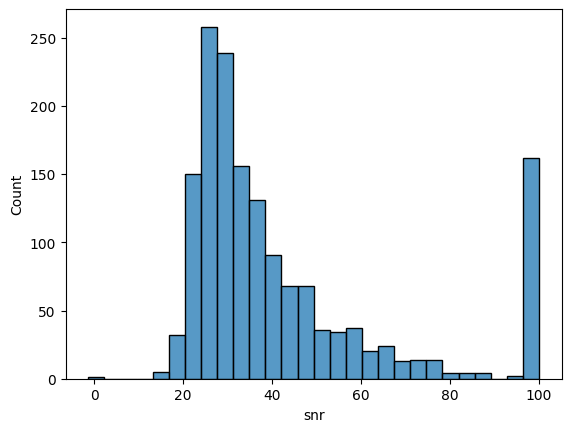

In [8]:
seaborn.histplot(merged["snr"])

# Fine tune audio configuration

In [158]:
generic_configuration = load_config(config_path)
tune_params={
    # 'num_mels': 80,          # In general, you don't need to change this. 
    # 'fft_size': 1024,        # In general, you don't need to change this.
    # 'hop_length': 256,       # In general, you don't need to change this.
    # 'win_length': 1024,      # In general, you don't need to change this.
    'preemphasis': 0.99,     # In general, 0 gives better voice recovery but makes training harder. If your model does not train, try 0.97 - 0.99.
    'min_level_db': -100,
    'ref_level_db': -10,       # The base DB; increase until all background noise is removed in the spectrogram, then lower until you hear better speech below.   
    'power': 1.5,            # Change this value and listen to the synthesized voice. 1.2 - 1.5 are resonable values.
    'griffin_lim_iters': 60, # Quality does not improve for values > 60
    'mel_fmin': 0.0,         # Adjust this and check mel-spectrogram-based voice synthesis below.
    'mel_fmax': 4000.0,      # Adjust this and check mel-spectrogram-based voice synthesis below.
    # 'do_trim_silence': True  # If you dataset has some silience at the beginning or end, this trims it. Check the AP.load_wav() below,if it causes any difference for the loaded audio file.
}

# Override select parts of loaded config with parameters above
tuned_config = dict(generic_configuration.audio.copy())
tuned_config.update(tune_params)
audio_processor = AudioProcessor(**tuned_config);
test_audio_path = merged["path_denoised"].iloc[1000]
test_audio = audio_processor.load_wav(test_audio_path)
IPython.display.Audio(data=test_audio, rate=frame_rate)

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:-10
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.99
 | > griffin_lim_iters:60
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:4000.0
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


In [130]:
def compare_values(file, config, attribute, values):
    """
    attributes (str): the names of the attribute you like to test.
    values (list): list of values to compare.
    """
    audio_processor = AudioProcessor(**config);
    figure = plt.figure(figsize=(20.0, 16.0))
    wavs = []
    for idx, val in enumerate(values):
        setattr(audio_processor, attribute, val)
        wav = audio_processor.load_wav(file)
        spec = audio_processor.spectrogram(wav)
        spec_norm = audio_processor.denormalize(spec.T)
        plt.subplot(len(values), 2, 2*idx + 1)
        plt.imshow(spec_norm.T, aspect="auto", origin="lower")
        #         plt.colorbar()
        plt.tight_layout()
        wav_gen = audio_processor.inv_spectrogram(spec)
        wavs.append(wav_gen)
        plt.subplot(len(values), 2, 2*idx + 2)
        display.waveplot(wav, alpha=0.5, color="blue")
        display.waveplot(wav_gen, alpha=0.25, color="green")
        plt.title("{}={}".format(attribute, val))
        plt.tight_layout()
    
    wav = audio_processor.load_wav(file)
    print(" > Ground-truth")
    IPython.display.display(IPython.display.Audio(wav, rate=audio_processor.sample_rate))
    
    for idx, wav_gen in enumerate(wavs):
        val = values[idx]
        print(" > {} = {}".format(attribute, val))
        IPython.display.display(IPython.display.Audio(wav_gen, rate=audio_processor.sample_rate))
    return figure

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.99
 | > griffin_lim_iters:60
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Ground-truth


 > preemphasis = 0


 > preemphasis = 0.5


 > preemphasis = 0.99


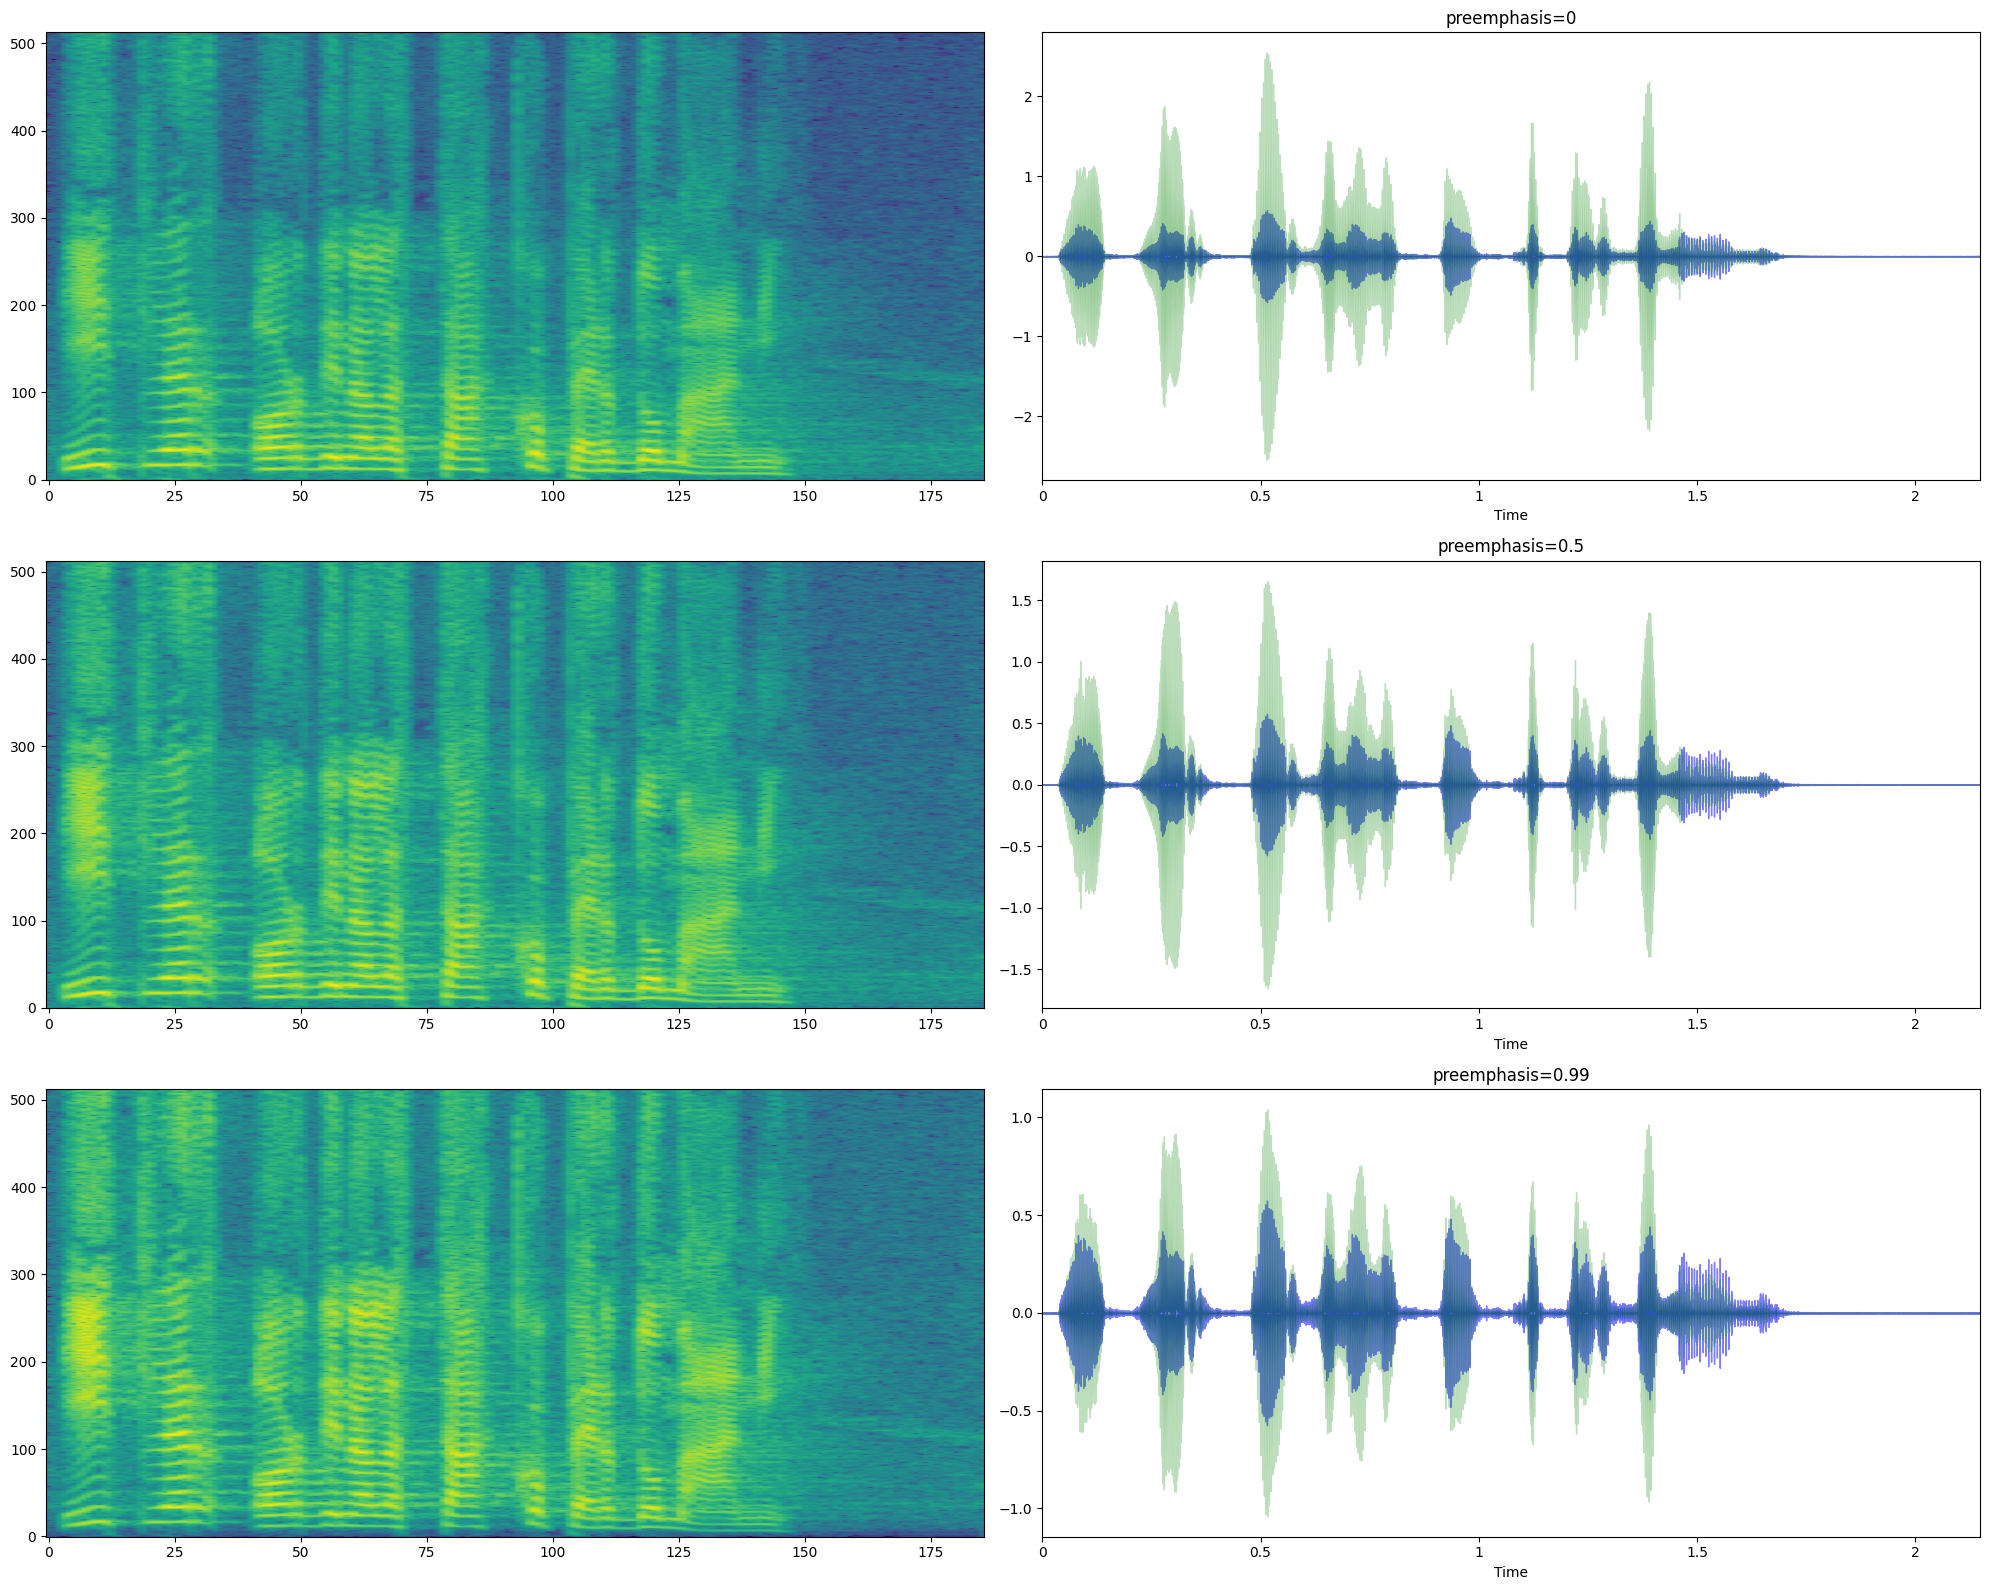

In [131]:
compare_values(test_audio_path, tuned_config, "preemphasis", [0, 0.5, 0.99])

# Write files to SSD and prepare metadata file

In [177]:
merged["audio_file"] = merged["path_denoised"]

In [182]:
final = merged.loc[
    (merged["snr"] > 19)
    & (merged["duration"] < 20)
    & (merged["clean_transcript"].str.len() > 0),
    ["audio_file", "clean_transcript"]
].rename(
    columns={"clean_transcript": "text"}
)
final["audio_file"] = final["audio_file"].apply(lambda x: pathlib.Path(x).relative_to(pathlib.Path(x).parent.parent))

In [183]:
final.to_csv("../data/audio_metadata.csv", index=False, sep="|")

In [184]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509 entries, 0 to 1566
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   audio_file  1509 non-null   object
 1   text        1509 non-null   object
dtypes: object(2)
memory usage: 35.4+ KB


In [181]:
final.head()

,audio_file,text
0,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,come scoppiano le guerre
1,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,in realtà quello che vi racconterò io credo ch...
2,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,"disastrosa, piena di sofferenza, piena di ince..."
3,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,esempio nell'europa del da cui cominciamo stasera
4,7_La_Prima_Guerra_Mondiale__Come_scoppiano_le_...,come scoppia la prima guerra mondiale. in fond...
